# Hypothesis Testing - Interactive Learning Notebook

**Author:** Md Ayan Alam  
**Roll Number:** GF202342645  
**Course:** Statistical Foundation of Data Science

---

## Learning Objectives

By the end of this notebook, you will be able to:
- Formulate null and alternative hypotheses
- Compute p-values and interpret statistical significance
- Perform z-tests, t-tests (one/two sample, paired), and proportion tests
- Conduct chi-square tests and one-way ANOVA
- Construct and interpret confidence intervals
- Understand Type I/II errors, power, and sample size

---

In [1]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import TTestIndPower, TTestPower
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 7)
sns.set_style('whitegrid')

print("Libraries ready for hypothesis testing!")

Libraries ready for hypothesis testing!


## 1. Hypothesis Testing Fundamentals

### 1.1 Key Concepts and Definitions

**Hypothesis Testing Framework:**
- **Null hypothesis (H₀)**: The default claim or status quo assumption (e.g., no difference, no effect, no relationship)
- **Alternative hypothesis (H₁ or Hₐ)**: The competing claim we want to test for (e.g., difference exists, effect is present)
- **Test statistic**: A standardized measure that quantifies how far our sample data deviates from what we'd expect under H₀
- **p-value**: The probability of observing a test statistic as extreme as (or more extreme than) the one calculated, assuming H₀ is true
- **Significance level (α)**: The threshold probability for rejecting H₀ (commonly 0.05, 0.01, or 0.10)

### 1.2 Mathematical Framework

**General Test Statistic Form:**
$$t = \frac{\text{Sample Statistic} - \text{Hypothesized Parameter}}{\text{Standard Error of Sample Statistic}}$$

**p-value Calculation:**
- For two-tailed test: $p = 2 \times P(|T| \geq |t_{obs}|)$
- For right-tailed test: $p = P(T \geq t_{obs})$
- For left-tailed test: $p = P(T \leq t_{obs})$

where $T$ follows the appropriate sampling distribution under H₀.

### 1.3 Decision Rules and Errors

**Decision Rule:**
- If $p < \alpha$: Reject H₀ (statistically significant result)
- If $p \geq \alpha$: Fail to reject H₀ (not statistically significant)

**Types of Errors:**

|                | H₀ True    | H₀ False   |
|----------------|------------|------------|
| **Reject H₀**  | Type I Error (α) | Correct Decision (Power) |
| **Fail to Reject H₀** | Correct Decision | Type II Error (β) |

**Error Probabilities:**
- **Type I Error Rate**: $\alpha = P(\text{Reject } H_0 | H_0 \text{ is true})$
- **Type II Error Rate**: $\beta = P(\text{Fail to reject } H_0 | H_0 \text{ is false})$
- **Statistical Power**: $1 - \beta = P(\text{Reject } H_0 | H_0 \text{ is false})$

### 1.4 Confidence Intervals

A $(1-\alpha) \times 100\%$ confidence interval provides a range of plausible values for the parameter:

$$\text{CI} = \text{Point Estimate} \pm \text{Critical Value} \times \text{Standard Error}$$

**Relationship to Hypothesis Testing:**
If a hypothesized value falls outside the confidence interval, we reject H₀ at significance level α.

In [2]:
# Helper: report function
from typing import Tuple

def report_test(name: str, stat: float, p: float, alpha: float = 0.05):
    decision = "Reject H0" if p < alpha else "Fail to reject H0"
    print(f"=== {name} ===")
    print(f"Test statistic: {stat:.4f}")
    print(f"p-value: {p:.6f}")
    print(f"Decision (alpha={alpha}): {decision}\n")

Example: Two-tailed z-test with observed statistic = 2.1


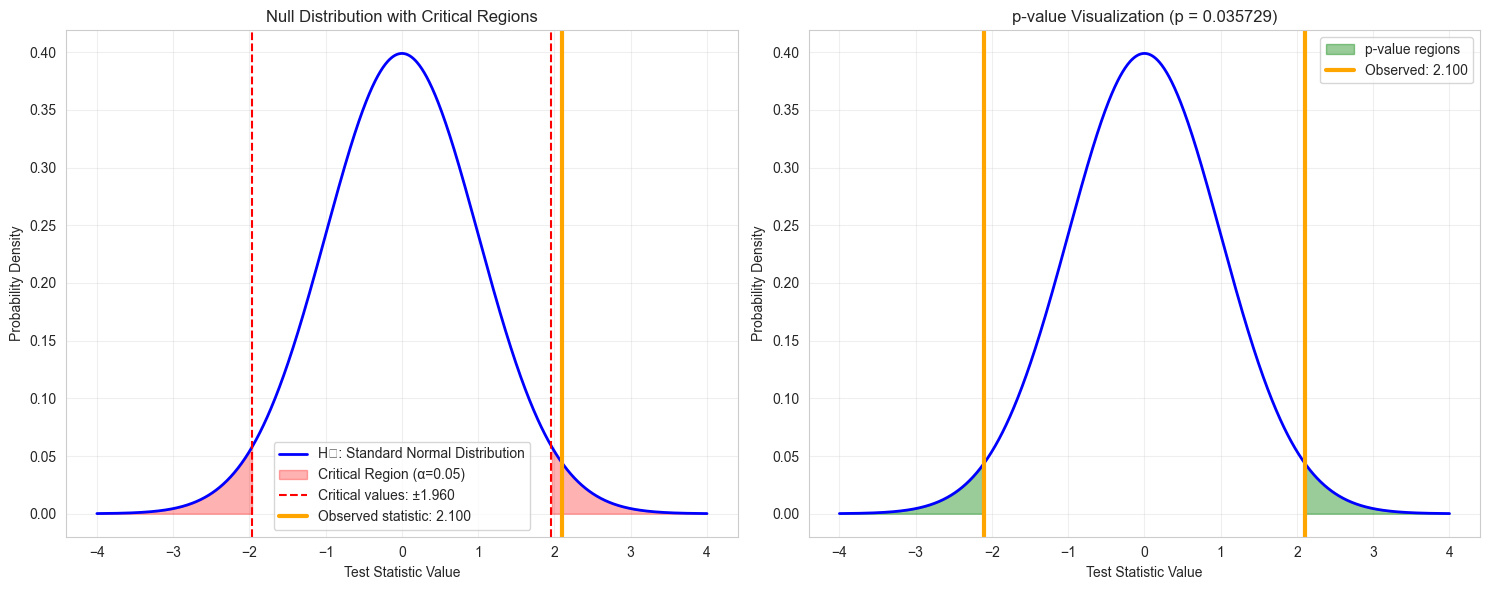

Calculated p-value: 0.035729
Decision: Reject H₀


In [3]:
# Visualization of hypothesis testing concepts
def visualize_hypothesis_test(distribution='normal', mu0=0, sample_stat=1.5, alpha=0.05,
                             test_type='two-tailed', df=None):
    """
    Visualize hypothesis testing with p-value and critical regions
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Generate x values
    if distribution == 'normal':
        x = np.linspace(-4, 4, 1000)
        y = stats.norm.pdf(x, loc=0, scale=1)
        dist_name = "Standard Normal Distribution"
    elif distribution == 't':
        x = np.linspace(-4, 4, 1000)
        y = stats.t.pdf(x, df=df)
        dist_name = f"t-Distribution (df={df})"

    # Plot 1: Null distribution with critical regions
    ax1.plot(x, y, 'b-', linewidth=2, label=f'H₀: {dist_name}')

    if test_type == 'two-tailed':
        if distribution == 'normal':
            crit_vals = [-stats.norm.ppf(1-alpha/2), stats.norm.ppf(1-alpha/2)]
        else:
            crit_vals = [-stats.t.ppf(1-alpha/2, df), stats.t.ppf(1-alpha/2, df)]

        # Shade critical regions
        x_left = x[x <= crit_vals[0]]
        y_left = y[x <= crit_vals[0]]
        x_right = x[x >= crit_vals[1]]
        y_right = y[x >= crit_vals[1]]

        ax1.fill_between(x_left, y_left, alpha=0.3, color='red', label=f'Critical Region (α={alpha})')
        ax1.fill_between(x_right, y_right, alpha=0.3, color='red')

        ax1.axvline(crit_vals[0], color='red', linestyle='--', label=f'Critical values: ±{abs(crit_vals[0]):.3f}')
        ax1.axvline(crit_vals[1], color='red', linestyle='--')

    # Mark observed test statistic
    ax1.axvline(sample_stat, color='orange', linewidth=3, label=f'Observed statistic: {sample_stat:.3f}')

    ax1.set_xlabel('Test Statistic Value')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Null Distribution with Critical Regions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: p-value visualization
    ax2.plot(x, y, 'b-', linewidth=2)

    if test_type == 'two-tailed':
        # Shade p-value regions
        x_p_left = x[x <= -abs(sample_stat)]
        y_p_left = y[x <= -abs(sample_stat)]
        x_p_right = x[x >= abs(sample_stat)]
        y_p_right = y[x >= abs(sample_stat)]

        ax2.fill_between(x_p_left, y_p_left, alpha=0.4, color='green', label='p-value regions')
        ax2.fill_between(x_p_right, y_p_right, alpha=0.4, color='green')

        if distribution == 'normal':
            p_value = 2 * (1 - stats.norm.cdf(abs(sample_stat)))
        else:
            p_value = 2 * (1 - stats.t.cdf(abs(sample_stat), df))

    ax2.axvline(sample_stat, color='orange', linewidth=3, label=f'Observed: {sample_stat:.3f}')
    ax2.axvline(-abs(sample_stat), color='orange', linewidth=3)

    ax2.set_xlabel('Test Statistic Value')
    ax2.set_ylabel('Probability Density')
    ax2.set_title(f'p-value Visualization (p = {p_value:.6f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return p_value

# Example visualization
print("Example: Two-tailed z-test with observed statistic = 2.1")
p_val = visualize_hypothesis_test(distribution='normal', sample_stat=2.1, alpha=0.05, test_type='two-tailed')
print(f"Calculated p-value: {p_val:.6f}")
print(f"Decision: {'Reject H₀' if p_val < 0.05 else 'Fail to reject H₀'}")

## 2. One-Sample Tests

### 2.1 One-Sample t-Test

**When to use:** Test whether a sample mean differs from a hypothesized population mean when population standard deviation is unknown.

**Assumptions:**
1. Data are approximately normally distributed (or n ≥ 30 by CLT)
2. Observations are independent
3. Data are measured at interval/ratio level

**Mathematical Framework:**

**Hypotheses:**
- H₀: μ = μ₀ (population mean equals hypothesized value)
- H₁: μ ≠ μ₀ (two-tailed), μ > μ₀ (right-tailed), or μ < μ₀ (left-tailed)

**Test Statistic:**
$$t = \frac{\bar{x} - \mu_0}{s/\sqrt{n}}$$

where:
- $\bar{x}$ = sample mean
- $\mu_0$ = hypothesized population mean
- $s$ = sample standard deviation
- $n$ = sample size

**Sampling Distribution:** $t \sim t_{n-1}$ (t-distribution with n-1 degrees of freedom)

**Confidence Interval for μ:**
$$\bar{x} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$$

**Scenario:** A sample of exam scores; test if mean differs from 75.

=== One-Sample t-Test Analysis ===
Sample size: 40
Sample mean: 74.8136
Sample std: 9.5281
Standard error: 1.5065
Manual t-statistic: -0.1237
=== One-sample t-test (mean vs 75) ===
Test statistic: -0.1237
p-value: 0.902182
Decision (alpha=0.05): Fail to reject H0

Degrees of freedom: 39
Critical t-value (±): 2.0227
95% CI for mean: (71.77, 77.86)
Cohen's d (effect size): -0.020
Effect size interpretation: negligible


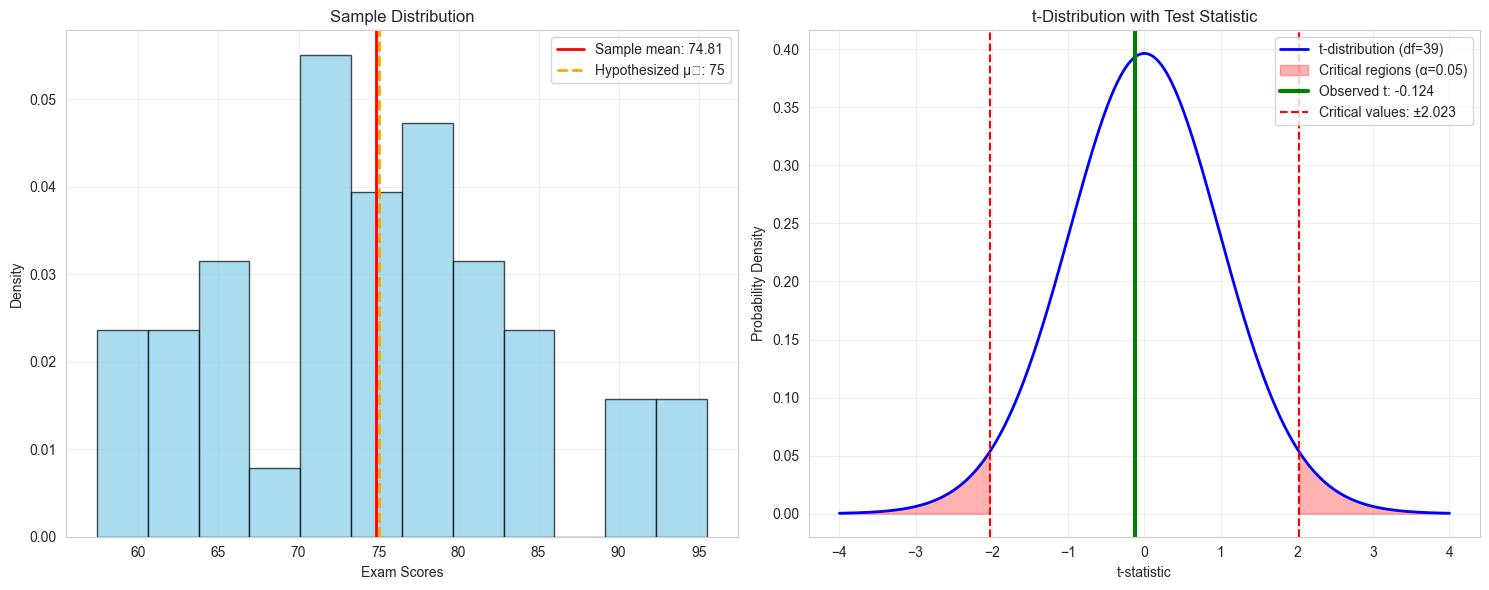


=== Interpretation ===
The sample provides insufficient evidence to conclude
that the population mean differs from 75 at α = 0.05 level.
The 95% CI contains the hypothesized value μ₀ = 75.


In [4]:
# One-sample t-test: Comprehensive example
mu0 = 75  # Hypothesized mean
np.random.seed(42)
sample = np.random.normal(loc=77, scale=10, size=40)

# Calculate test statistic manually
sample_mean = sample.mean()
sample_std = sample.std(ddof=1)
n = len(sample)
se = sample_std / np.sqrt(n)
t_stat_manual = (sample_mean - mu0) / se

print(f"=== One-Sample t-Test Analysis ===")
print(f"Sample size: {n}")
print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")
print(f"Standard error: {se:.4f}")
print(f"Manual t-statistic: {t_stat_manual:.4f}")

# Using scipy
stat, p = stats.ttest_1samp(sample, popmean=mu0)
report_test("One-sample t-test (mean vs 75)", stat, p)

# Degrees of freedom
df = n - 1
print(f"Degrees of freedom: {df}")

# Calculate critical values for α = 0.05
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df)
print(f"Critical t-value (±): {t_critical:.4f}")

# 95% CI for mean
t_crit_ci = stats.t.ppf(0.975, df)
margin_error = t_crit_ci * se
ci_lower = sample_mean - margin_error
ci_upper = sample_mean + margin_error
print(f"95% CI for mean: ({ci_lower:.2f}, {ci_upper:.2f})")

# Effect size (Cohen's d for one-sample)
cohens_d = (sample_mean - mu0) / sample_std
print(f"Cohen's d (effect size): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"Effect size interpretation: {effect_interpretation}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sample distribution
ax1.hist(sample, bins=12, density=True, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(sample_mean, color='red', linewidth=2, label=f'Sample mean: {sample_mean:.2f}')
ax1.axvline(mu0, color='orange', linewidth=2, linestyle='--', label=f'Hypothesized μ₀: {mu0}')
ax1.set_xlabel('Exam Scores')
ax1.set_ylabel('Density')
ax1.set_title('Sample Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# t-distribution with test statistic
x_t = np.linspace(-4, 4, 1000)
y_t = stats.t.pdf(x_t, df)
ax2.plot(x_t, y_t, 'b-', linewidth=2, label=f't-distribution (df={df})')

# Critical regions
x_crit_left = x_t[x_t <= -t_critical]
y_crit_left = y_t[x_t <= -t_critical]
x_crit_right = x_t[x_t >= t_critical]
y_crit_right = y_t[x_t >= t_critical]
ax2.fill_between(x_crit_left, y_crit_left, alpha=0.3, color='red', label=f'Critical regions (α={alpha})')
ax2.fill_between(x_crit_right, y_crit_right, alpha=0.3, color='red')

# Observed t-statistic
ax2.axvline(stat, color='green', linewidth=3, label=f'Observed t: {stat:.3f}')
ax2.axvline(-t_critical, color='red', linestyle='--')
ax2.axvline(t_critical, color='red', linestyle='--', label=f'Critical values: ±{t_critical:.3f}')

ax2.set_xlabel('t-statistic')
ax2.set_ylabel('Probability Density')
ax2.set_title('t-Distribution with Test Statistic')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Interpretation ===")
print(f"The sample provides {'sufficient' if p < 0.05 else 'insufficient'} evidence to conclude")
print(f"that the population mean differs from {mu0} at α = 0.05 level.")
print(f"The 95% CI {'does not contain' if mu0 < ci_lower or mu0 > ci_upper else 'contains'} the hypothesized value μ₀ = {mu0}.")

### 2.2 One-Sample Proportion z-Test

**When to use:** Test whether a sample proportion differs from a hypothesized population proportion.

**Assumptions:**
1. Random sampling
2. Binary outcomes (success/failure)
3. Large sample size: $np_0 \geq 5$ and $n(1-p_0) \geq 5$
4. Independence of observations

**Mathematical Framework:**

**Hypotheses:**
- H₀: p = p₀ (population proportion equals hypothesized value)
- H₁: p ≠ p₀ (two-tailed), p > p₀ (right-tailed), or p < p₀ (left-tailed)

**Test Statistic:**
$$z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$$

where:
- $\hat{p} = x/n$ = sample proportion
- $p_0$ = hypothesized population proportion
- $n$ = sample size
- $x$ = number of successes

**Sampling Distribution:** $z \sim N(0,1)$ (standard normal distribution)

**Confidence Interval for p (Wilson Score Method):**
$$\frac{\hat{p} + \frac{z_{\alpha/2}^2}{2n} \pm z_{\alpha/2}\sqrt{\frac{\hat{p}(1-\hat{p})}{n} + \frac{z_{\alpha/2}^2}{4n^2}}}{1 + \frac{z_{\alpha/2}^2}{n}}$$

**Scenario:** 120 users visited a website, 78 clicked the call-to-action button. Test if conversion rate > 60%.

=== One-Sample Proportion z-Test Analysis ===
Sample size: 120
Number of successes: 78
Sample proportion: 0.6500
Hypothesized proportion: 0.6

=== Assumption Check ===
np₀ = 72.0 ≥ 5: ✓
n(1-p₀) = 48.0 ≥ 5: ✓

=== Test Statistic Calculation ===
Standard error under H₀: 0.0447
Manual z-statistic: 1.1180
Statsmodels z-statistic: 1.1483
=== One-sample proportion z-test (p > 0.6) ===
Test statistic: 1.1483
p-value: 0.125414
Decision (alpha=0.05): Fail to reject H0

Critical z-value (two-tailed): ±1.9600
Critical z-value (right-tailed): 1.6449

=== Confidence Intervals (95%) ===
Wilson method: (0.5612, 0.7295)
Wald method: (0.5647, 0.7353)
Clopper-Pearson: (0.5576, 0.7348)

Cohen's h (effect size): 0.1033


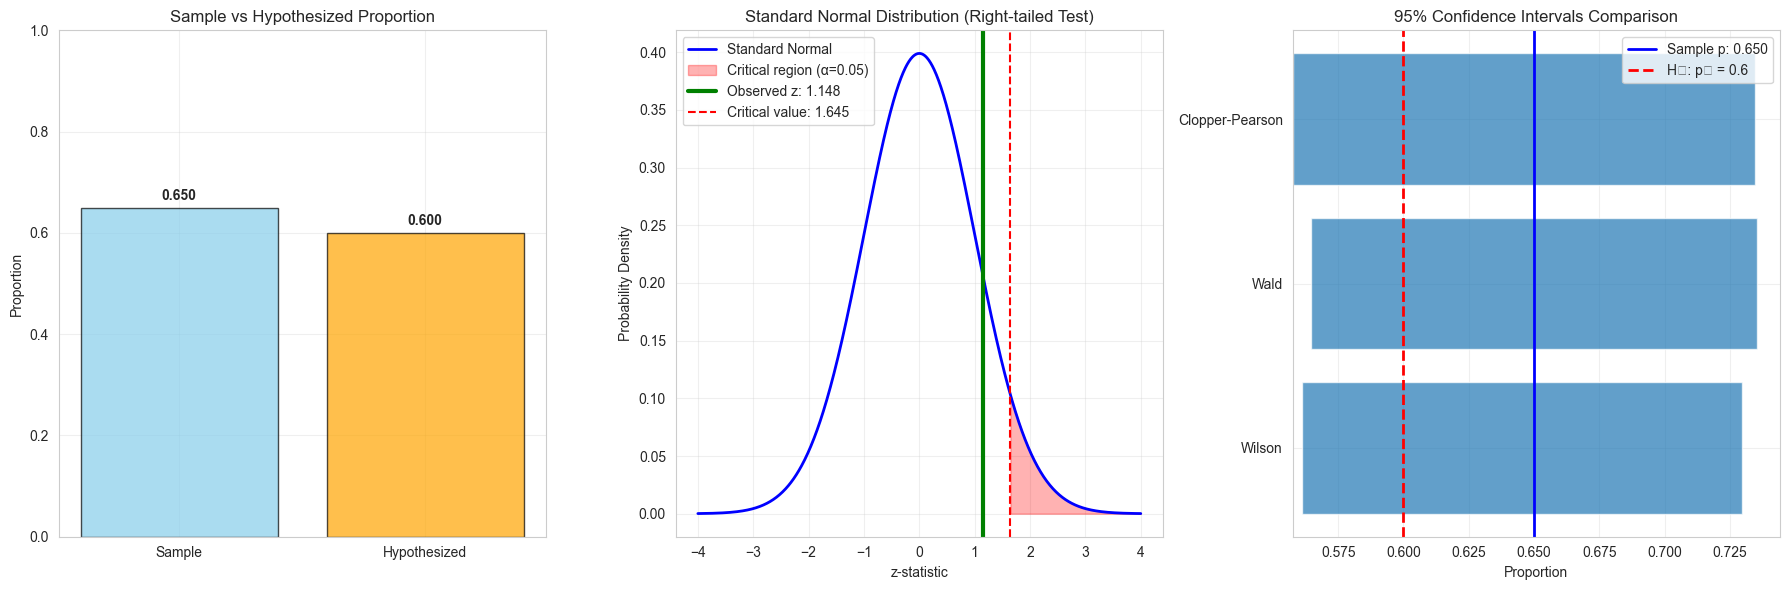


=== Interpretation ===
Sample proportion: 0.650 (65.0%)
The sample provides insufficient evidence
to conclude that the true conversion rate is greater than 60.0% (α = 0.05).
Wilson 95% CI: (0.561, 0.729)
The CI contains p₀ = 0.6.


In [5]:
# One-sample proportion test: Comprehensive analysis
n = 120  # Sample size
x = 78   # Number of successes (clicks)
p0 = 0.60  # Hypothesized proportion

# Calculate sample proportion
p_hat = x / n

print(f"=== One-Sample Proportion z-Test Analysis ===")
print(f"Sample size: {n}")
print(f"Number of successes: {x}")
print(f"Sample proportion: {p_hat:.4f}")
print(f"Hypothesized proportion: {p0}")

# Check assumptions
np0 = n * p0
n_1_p0 = n * (1 - p0)
print(f"\n=== Assumption Check ===")
print(f"np₀ = {np0:.1f} ≥ 5: {'✓' if np0 >= 5 else '✗'}")
print(f"n(1-p₀) = {n_1_p0:.1f} ≥ 5: {'✓' if n_1_p0 >= 5 else '✗'}")

# Calculate test statistic manually
se_p0 = np.sqrt(p0 * (1 - p0) / n)
z_stat_manual = (p_hat - p0) / se_p0

print(f"\n=== Test Statistic Calculation ===")
print(f"Standard error under H₀: {se_p0:.4f}")
print(f"Manual z-statistic: {z_stat_manual:.4f}")

# Using statsmodels for two-sided test
stat, p_two_sided = proportions_ztest(count=x, nobs=n, value=p0)
print(f"Statsmodels z-statistic: {stat:.4f}")

# Convert to one-sided (right-tail) test since we're testing p > 0.6
p_right = p_two_sided/2 if stat > 0 else 1 - p_two_sided/2
report_test("One-sample proportion z-test (p > 0.6)", stat, p_right)

# Critical values
alpha = 0.05
z_critical_two = stats.norm.ppf(1 - alpha/2)
z_critical_right = stats.norm.ppf(1 - alpha)
print(f"Critical z-value (two-tailed): ±{z_critical_two:.4f}")
print(f"Critical z-value (right-tailed): {z_critical_right:.4f}")

# Confidence intervals using different methods
alpha_ci = 0.05

# Wilson method (recommended)
low_wilson, high_wilson = proportion_confint(count=x, nobs=n, alpha=alpha_ci, method='wilson')
print(f"\n=== Confidence Intervals (95%) ===")
print(f"Wilson method: ({low_wilson:.4f}, {high_wilson:.4f})")

# Wald method (traditional, less reliable for small samples)
z_ci = stats.norm.ppf(1 - alpha_ci/2)
se_wald = np.sqrt(p_hat * (1 - p_hat) / n)
low_wald = p_hat - z_ci * se_wald
high_wald = p_hat + z_ci * se_wald
print(f"Wald method: ({low_wald:.4f}, {high_wald:.4f})")

# Clopper-Pearson (exact, conservative)
low_cp, high_cp = proportion_confint(count=x, nobs=n, alpha=alpha_ci, method='beta')
print(f"Clopper-Pearson: ({low_cp:.4f}, {high_cp:.4f})")

# Effect size (Cohen's h)
cohens_h = 2 * (np.arcsin(np.sqrt(p_hat)) - np.arcsin(np.sqrt(p0)))
print(f"\nCohen's h (effect size): {cohens_h:.4f}")

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Bar chart of proportions
categories = ['Sample', 'Hypothesized']
proportions = [p_hat, p0]
colors = ['skyblue', 'orange']
bars = ax1.bar(categories, proportions, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Proportion')
ax1.set_title('Sample vs Hypothesized Proportion')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, prop in zip(bars, proportions):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{prop:.3f}', ha='center', va='bottom', fontweight='bold')

# Standard normal distribution with test statistic
x_norm = np.linspace(-4, 4, 1000)
y_norm = stats.norm.pdf(x_norm)
ax2.plot(x_norm, y_norm, 'b-', linewidth=2, label='Standard Normal')

# Critical region for right-tailed test
x_crit = x_norm[x_norm >= z_critical_right]
y_crit = y_norm[x_norm >= z_critical_right]
ax2.fill_between(x_crit, y_crit, alpha=0.3, color='red', label=f'Critical region (α={alpha})')

# Observed z-statistic
ax2.axvline(stat, color='green', linewidth=3, label=f'Observed z: {stat:.3f}')
ax2.axvline(z_critical_right, color='red', linestyle='--', label=f'Critical value: {z_critical_right:.3f}')

ax2.set_xlabel('z-statistic')
ax2.set_ylabel('Probability Density')
ax2.set_title('Standard Normal Distribution (Right-tailed Test)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confidence interval comparison
methods = ['Wilson', 'Wald', 'Clopper-Pearson']
lows = [low_wilson, low_wald, low_cp]
highs = [high_wilson, high_wald, high_cp]

y_pos = np.arange(len(methods))
ax3.barh(y_pos, [h - l for l, h in zip(lows, highs)], left=lows, alpha=0.7)

# Add sample proportion and hypothesized value
ax3.axvline(p_hat, color='blue', linewidth=2, label=f'Sample p: {p_hat:.3f}')
ax3.axvline(p0, color='red', linewidth=2, linestyle='--', label=f'H₀: p₀ = {p0}')

ax3.set_yticks(y_pos)
ax3.set_yticklabels(methods)
ax3.set_xlabel('Proportion')
ax3.set_title('95% Confidence Intervals Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Interpretation ===")
print(f"Sample proportion: {p_hat:.3f} ({p_hat*100:.1f}%)")
print(f"The sample provides {'sufficient' if p_right < 0.05 else 'insufficient'} evidence")
print(f"to conclude that the true conversion rate is greater than {p0*100}% (α = 0.05).")
print(f"Wilson 95% CI: ({low_wilson:.3f}, {high_wilson:.3f})")
print(f"The CI {'does not contain' if p0 < low_wilson or p0 > high_wilson else 'contains'} p₀ = {p0}.")

## 3. Two-Sample Tests

### 3.1 Two-Sample t-Test (Independent Samples)

**When to use:** Compare means of two independent groups when population variances are unknown.

**Assumptions:**
1. Both populations are approximately normally distributed
2. Independent random samples
3. Equal variances (for pooled t-test) or unequal variances (for Welch t-test)

**Mathematical Framework:**

**Hypotheses:**
- H₀: μ₁ = μ₂ (or μ₁ - μ₂ = 0)
- H₁: μ₁ ≠ μ₂ (two-tailed), μ₁ > μ₂ (right-tailed), or μ₁ < μ₂ (left-tailed)

**Test Statistic (Welch t-test, unequal variances):**
$$t = \frac{(\bar{x}_1 - \bar{x}_2) - (\mu_1 - \mu_2)}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

**Degrees of Freedom (Welch-Satterthwaite equation):**
$$df = \frac{\left(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}\right)^2}{\frac{(s_1^2/n_1)^2}{n_1-1} + \frac{(s_2^2/n_2)^2}{n_2-1}}$$

**Test Statistic (Pooled t-test, equal variances):**
$$t = \frac{(\bar{x}_1 - \bar{x}_2) - (\mu_1 - \mu_2)}{s_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$

**Pooled Standard Deviation:**
$$s_p = \sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1 + n_2 - 2}}$$

**Effect Size (Cohen's d):**
$$d = \frac{\bar{x}_1 - \bar{x}_2}{s_{pooled}}$$

**Confidence Interval for μ₁ - μ₂:**
$$(\bar{x}_1 - \bar{x}_2) \pm t_{\alpha/2,df} \cdot SE(\bar{x}_1 - \bar{x}_2)$$

**Scenario:** A/B test comparing mean time-on-site between two website versions.

=== Two-Sample Independent t-Test Analysis ===
Group A (Control): n₁ = 60, x̄₁ = 5.3144, s₁ = 1.0902
Group B (New): n₂ = 55, x̄₂ = 4.9779, s₂ = 0.9540

=== Assumption Check: Equal Variances ===
Levene's test statistic: 2.2880
Levene's p-value: 0.1332
Equal variances assumption: Met (α = 0.05)
Recommended test: Pooled t-test

=== Welch t-Test (Unequal Variances) ===
Welch degrees of freedom: 112.77
=== Two-sample t-test (Welch) ===
Test statistic: 1.7647
p-value: 0.080328
Decision (alpha=0.05): Fail to reject H0

=== Pooled t-Test (Equal Variances) ===
Pooled standard deviation: 1.0274
Pooled degrees of freedom: 113
=== Two-sample t-test (Pooled) ===
Test statistic: 1.7544
p-value: 0.082069
Decision (alpha=0.05): Fail to reject H0

=== Effect Sizes ===
Cohen's d: 0.3275
Glass's Δ: 0.3527
Effect size interpretation: small

=== Confidence Interval ===
Difference in means: 0.3365
Standard error of difference: 0.1907
95% CI for μ₁ - μ₂: (-0.0413, 0.7143)


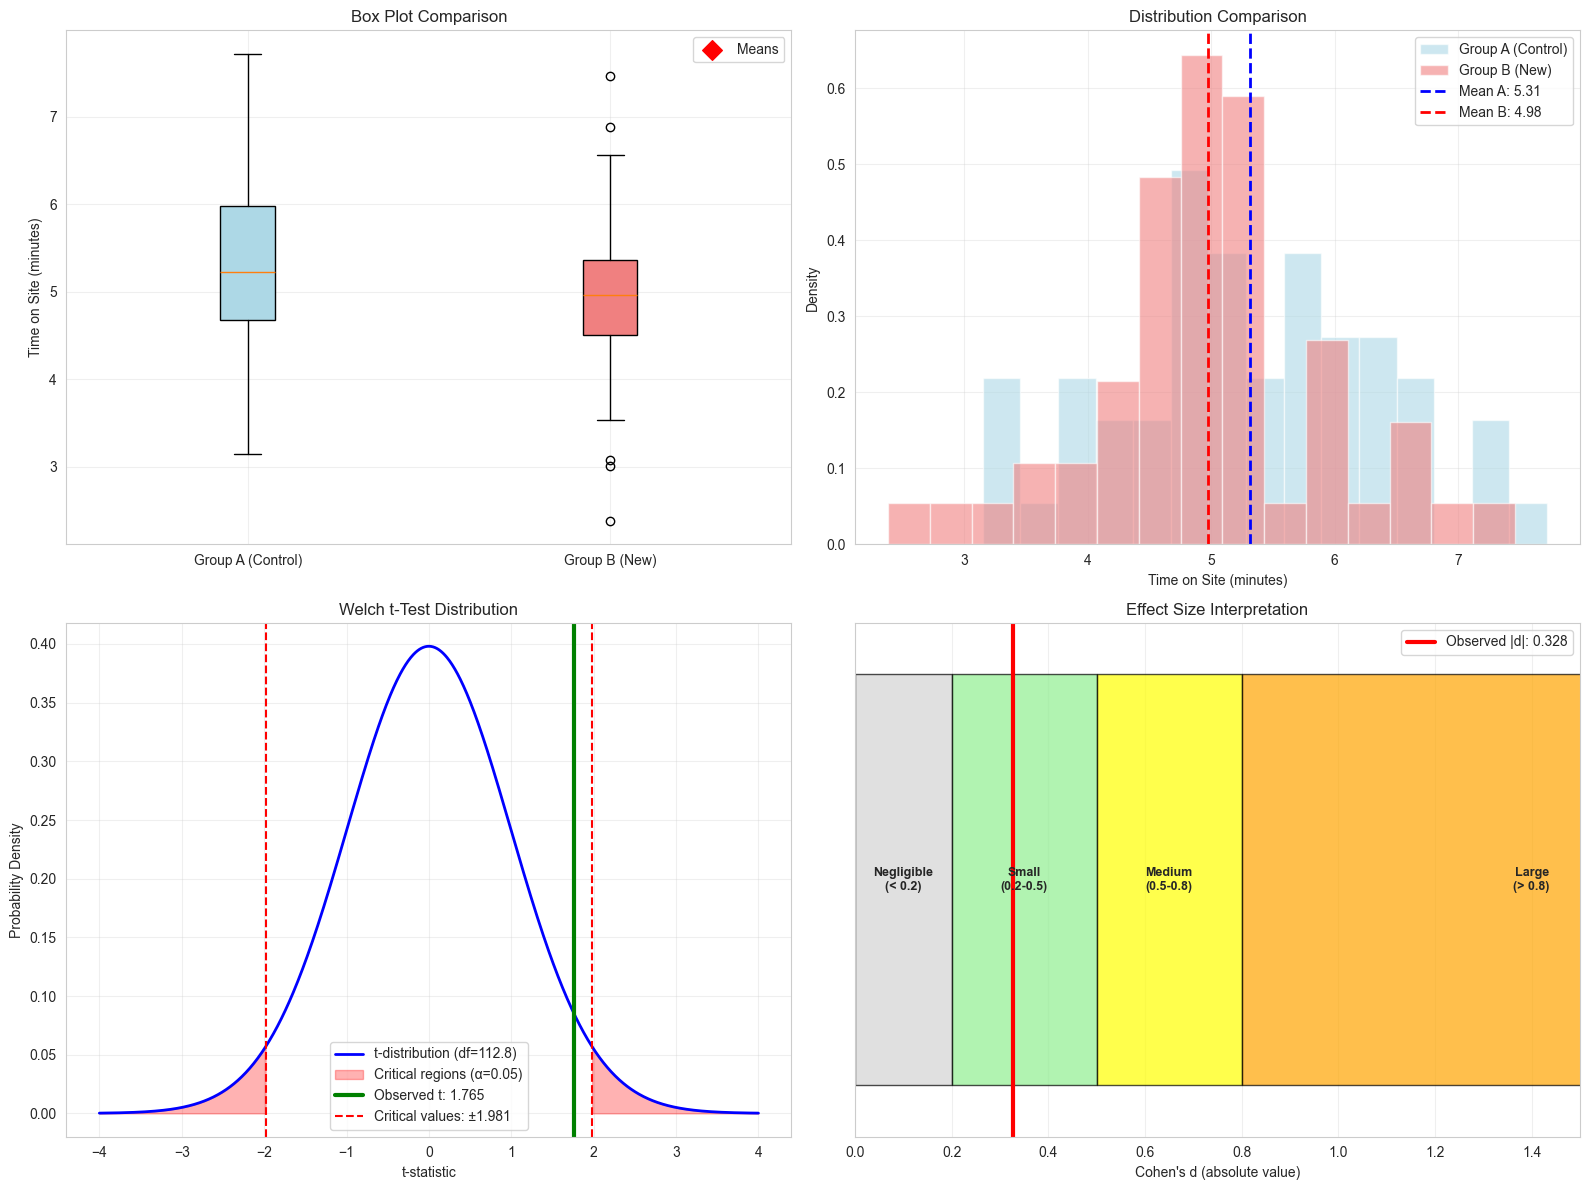


=== Interpretation ===
Mean difference: 0.3365 minutes
The data provide insufficient evidence to conclude
that there is a significant difference between the two groups (α = 0.05).
Effect size: small practical difference
95% CI for difference: (-0.041, 0.714)
The CI includes zero, confirming the hypothesis test result.


In [6]:
# Two-sample independent t-test: Comprehensive analysis
np.random.seed(42)
# Group A: Control version
A = np.random.normal(5.5, 1.2, 60)
# Group B: New version
B = np.random.normal(5.0, 1.0, 55)

print("=== Two-Sample Independent t-Test Analysis ===")
print(f"Group A (Control): n₁ = {len(A)}, x̄₁ = {A.mean():.4f}, s₁ = {A.std(ddof=1):.4f}")
print(f"Group B (New): n₂ = {len(B)}, x̄₂ = {B.mean():.4f}, s₂ = {B.std(ddof=1):.4f}")

# Test for equal variances (Levene's test)
levene_stat, levene_p = stats.levene(A, B)
equal_var = levene_p > 0.05
print(f"\n=== Assumption Check: Equal Variances ===")
print(f"Levene's test statistic: {levene_stat:.4f}")
print(f"Levene's p-value: {levene_p:.4f}")
print(f"Equal variances assumption: {'Met' if equal_var else 'Violated'} (α = 0.05)")
print(f"Recommended test: {'Pooled t-test' if equal_var else 'Welch t-test'}")

# Welch t-test (unequal variances) - default in scipy
stat_welch, p_welch = stats.ttest_ind(A, B, equal_var=False)
print(f"\n=== Welch t-Test (Unequal Variances) ===")

# Calculate degrees of freedom manually for Welch test
n1, n2 = len(A), len(B)
s1_sq, s2_sq = A.var(ddof=1), B.var(ddof=1)
numerator = (s1_sq/n1 + s2_sq/n2)**2
denominator = (s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1)
df_welch = numerator / denominator

print(f"Welch degrees of freedom: {df_welch:.2f}")
report_test("Two-sample t-test (Welch)", stat_welch, p_welch)

# Pooled t-test (equal variances)
stat_pooled, p_pooled = stats.ttest_ind(A, B, equal_var=True)
print(f"=== Pooled t-Test (Equal Variances) ===")

# Calculate pooled standard deviation
s1, s2 = A.std(ddof=1), B.std(ddof=1)
s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1 + n2 - 2))
df_pooled = n1 + n2 - 2

print(f"Pooled standard deviation: {s_pooled:.4f}")
print(f"Pooled degrees of freedom: {df_pooled}")
report_test("Two-sample t-test (Pooled)", stat_pooled, p_pooled)

# Effect sizes
cohens_d = (A.mean() - B.mean()) / s_pooled
glass_delta = (A.mean() - B.mean()) / B.std(ddof=1)  # Using control group SD

print(f"=== Effect Sizes ===")
print(f"Cohen's d: {cohens_d:.4f}")
print(f"Glass's Δ: {glass_delta:.4f}")

# Interpret effect size
if abs(cohens_d) < 0.2:
    effect_interp = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interp = "small"
elif abs(cohens_d) < 0.8:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"Effect size interpretation: {effect_interp}")

# Confidence interval for difference in means (using Welch)
diff_means = A.mean() - B.mean()
se_diff = np.sqrt(s1_sq/n1 + s2_sq/n2)
t_crit = stats.t.ppf(0.975, df_welch)
ci_lower = diff_means - t_crit * se_diff
ci_upper = diff_means + t_crit * se_diff

print(f"\n=== Confidence Interval ===")
print(f"Difference in means: {diff_means:.4f}")
print(f"Standard error of difference: {se_diff:.4f}")
print(f"95% CI for μ₁ - μ₂: ({ci_lower:.4f}, {ci_upper:.4f})")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Box plots
box_data = [A, B]
bp = ax1.boxplot(box_data, labels=['Group A (Control)', 'Group B (New)'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax1.set_ylabel('Time on Site (minutes)')
ax1.set_title('Box Plot Comparison')
ax1.grid(True, alpha=0.3)

# Add mean markers
means = [A.mean(), B.mean()]
ax1.scatter([1, 2], means, color='red', s=100, marker='D', label='Means')
ax1.legend()

# Histograms with overlays
ax2.hist(A, bins=15, alpha=0.6, label='Group A (Control)', color='lightblue', density=True)
ax2.hist(B, bins=15, alpha=0.6, label='Group B (New)', color='lightcoral', density=True)
ax2.axvline(A.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean A: {A.mean():.2f}')
ax2.axvline(B.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean B: {B.mean():.2f}')
ax2.set_xlabel('Time on Site (minutes)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# t-distribution with test statistic
x_t = np.linspace(-4, 4, 1000)
y_t = stats.t.pdf(x_t, df_welch)
ax3.plot(x_t, y_t, 'b-', linewidth=2, label=f't-distribution (df={df_welch:.1f})')

# Critical regions
alpha = 0.05
t_crit_plot = stats.t.ppf(1 - alpha/2, df_welch)
x_crit_left = x_t[x_t <= -t_crit_plot]
y_crit_left = y_t[x_t <= -t_crit_plot]
x_crit_right = x_t[x_t >= t_crit_plot]
y_crit_right = y_t[x_t >= t_crit_plot]

ax3.fill_between(x_crit_left, y_crit_left, alpha=0.3, color='red', label=f'Critical regions (α={alpha})')
ax3.fill_between(x_crit_right, y_crit_right, alpha=0.3, color='red')
ax3.axvline(stat_welch, color='green', linewidth=3, label=f'Observed t: {stat_welch:.3f}')
ax3.axvline(-t_crit_plot, color='red', linestyle='--')
ax3.axvline(t_crit_plot, color='red', linestyle='--', label=f'Critical values: ±{t_crit_plot:.3f}')

ax3.set_xlabel('t-statistic')
ax3.set_ylabel('Probability Density')
ax3.set_title('Welch t-Test Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Effect size visualization
effect_sizes = ['Negligible\n(< 0.2)', 'Small\n(0.2-0.5)', 'Medium\n(0.5-0.8)', 'Large\n(> 0.8)']
effect_bounds = [0, 0.2, 0.5, 0.8, 2.0]
colors = ['lightgray', 'lightgreen', 'yellow', 'orange']

for i in range(len(effect_bounds)-1):
    ax4.barh(0, effect_bounds[i+1] - effect_bounds[i], left=effect_bounds[i],
             color=colors[i], alpha=0.7, edgecolor='black')

ax4.axvline(abs(cohens_d), color='red', linewidth=3, label=f'Observed |d|: {abs(cohens_d):.3f}')
ax4.set_xlim(0, 1.5)
ax4.set_ylim(-0.5, 0.5)
ax4.set_xlabel("Cohen's d (absolute value)")
ax4.set_title('Effect Size Interpretation')
ax4.set_yticks([])

# Add text labels
for i, (label, bound) in enumerate(zip(effect_sizes, effect_bounds[:-1])):
    mid_point = bound + (effect_bounds[i+1] - bound) / 2
    if mid_point <= 1.5:  # Only show if within plot range
        ax4.text(mid_point, 0, label, ha='center', va='center', fontsize=9, fontweight='bold')

ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Interpretation ===")
print(f"Mean difference: {diff_means:.4f} minutes")
print(f"The data provide {'sufficient' if p_welch < 0.05 else 'insufficient'} evidence to conclude")
print(f"that there is a significant difference between the two groups (α = 0.05).")
print(f"Effect size: {effect_interp} practical difference")
print(f"95% CI for difference: ({ci_lower:.3f}, {ci_upper:.3f})")
print(f"The CI {'does not include' if ci_lower > 0 or ci_upper < 0 else 'includes'} zero, " +
      f"{'confirming' if (ci_lower > 0 or ci_upper < 0) == (p_welch < 0.05) else 'contradicting'} the hypothesis test result.")

### 3.2 Paired t-Test (Dependent Samples)

**When to use:** Compare means of two related groups (before/after, matched pairs, repeated measures).

**Assumptions:**
1. Differences are approximately normally distributed
2. Pairs are independent
3. Same subjects measured twice (or matched pairs)

**Mathematical Framework:**

**Hypotheses:**
- H₀: μd = 0 (mean difference equals zero)
- H₁: μd ≠ 0 (two-tailed), μd > 0 (right-tailed), or μd < 0 (left-tailed)

**Test Statistic:**
$$t = \frac{\bar{d} - \mu_d}{s_d/\sqrt{n}}$$

where:
- $\bar{d} = \frac{1}{n}\sum_{i=1}^n (x_{1i} - x_{2i})$ = mean of differences
- $s_d$ = standard deviation of differences
- $n$ = number of pairs
- $\mu_d$ = hypothesized mean difference (usually 0)

**Degrees of Freedom:** $df = n - 1$

**Effect Size (Cohen's d for paired samples):**
$$d = \frac{\bar{d}}{s_d}$$

**Confidence Interval for μd:**
$$\bar{d} \pm t_{\alpha/2, n-1} \cdot \frac{s_d}{\sqrt{n}}$$

**Scenario:** Measure performance scores before vs after training for the same participants.

=== Paired t-Test Analysis ===
Number of participants: 30
Before training: mean = 68.49, std = 7.20
After training: mean = 73.01, std = 8.43

=== Difference Analysis ===
Mean difference (after - before): 4.5154
Standard deviation of differences: 3.7244
Standard error of differences: 0.6800
Manual t-statistic: 6.6404
Degrees of freedom: 29
=== Paired t-test (before vs after) ===
Test statistic: -6.6404
p-value: 0.000000
Decision (alpha=0.05): Reject H0

Cohen's d (paired): 1.2124
Effect size interpretation: large

=== Confidence Interval ===
95% CI for mean difference: (3.1246, 5.9061)

=== Assumption Check: Normality of Differences ===
Shapiro-Wilk test statistic: 0.9837
Shapiro-Wilk p-value: 0.9130
Normality assumption: Met (α = 0.05)

Correlation between before and after: 0.8981

=== Comparison: Independent t-test (INCORRECT for this data) ===
Independent t-test p-value: 0.029541
Paired t-test p-value: 0.000000
Paired test is more sensitive due to accounting for correlation


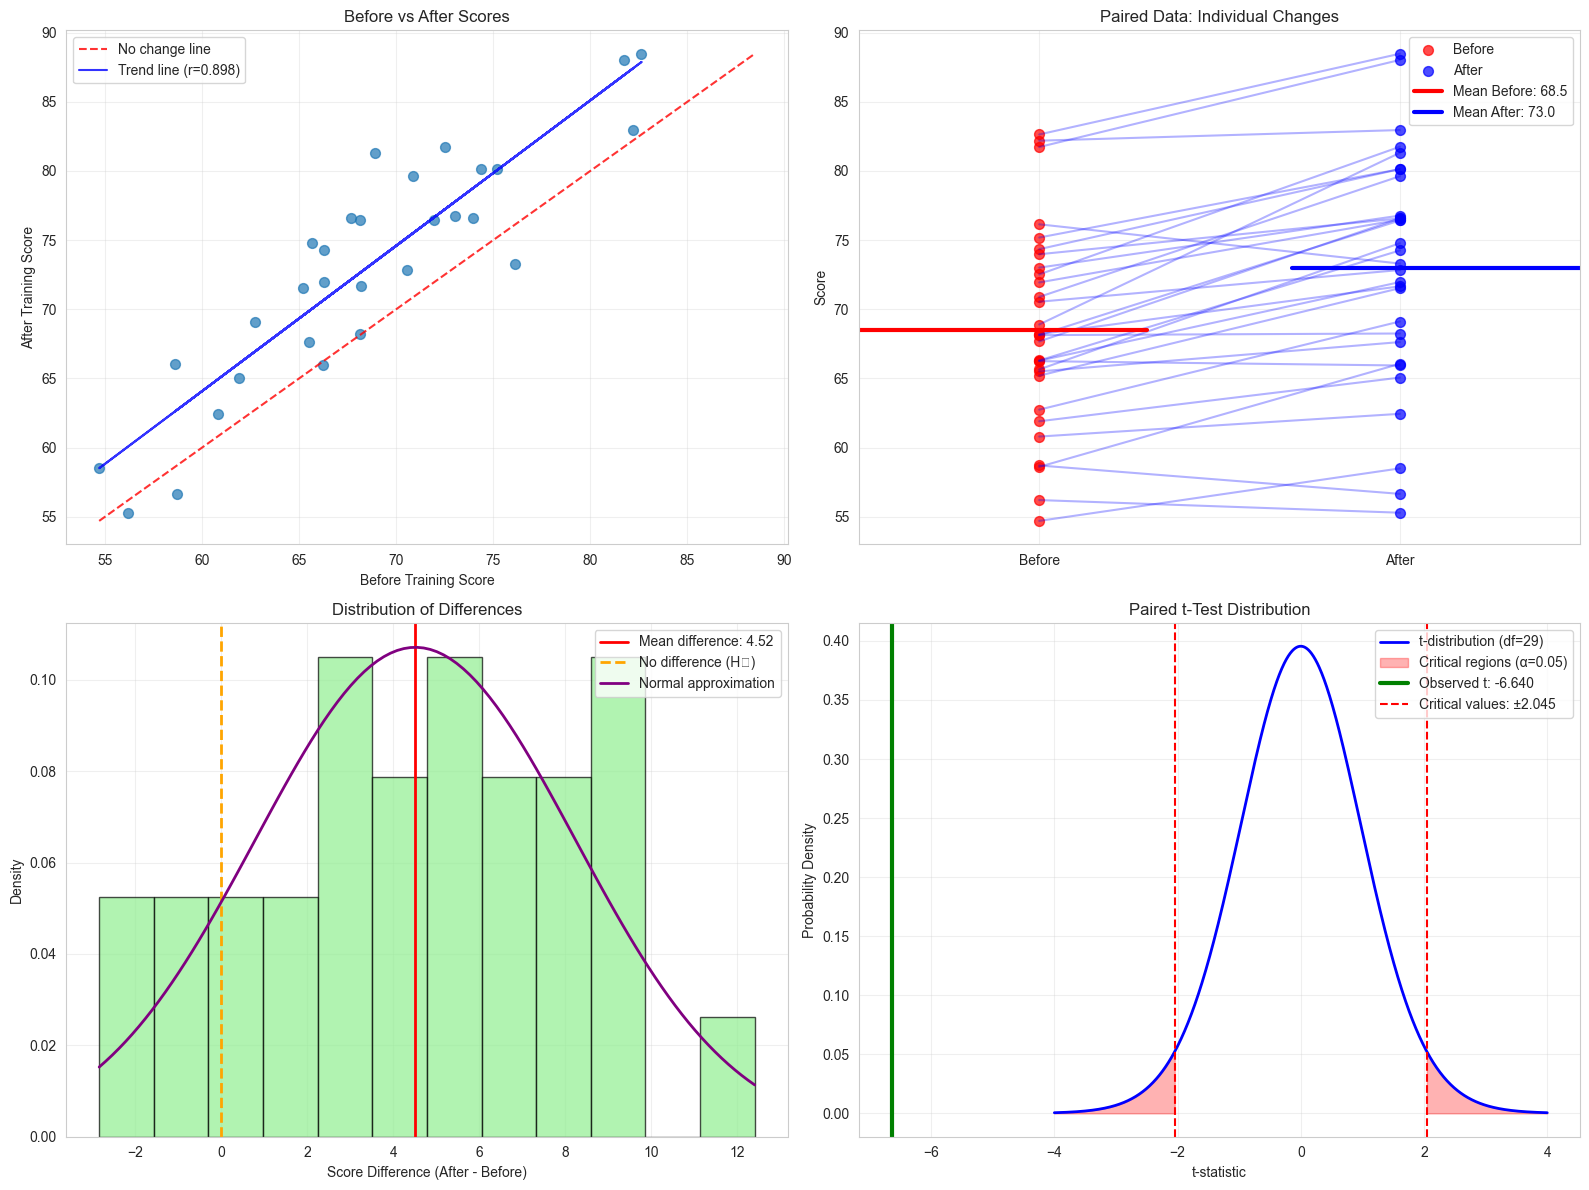


=== Summary Statistics ===
        Measure   Mean Std Dev  N
Before Training 68.495   7.200 30
 After Training 73.010   8.427 30
     Difference  4.515   3.724 30
    Effect Size  1.212   large   

=== Interpretation ===
Average improvement: 4.52 points
The training program did result in a statistically significant improvement (α = 0.05).
Effect size: large practical improvement
95% CI: We can be 95% confident that the true mean improvement is between 3.12 and 5.91 points.
The strong correlation (r = 0.898) between before and after scores justifies using a paired test.


In [7]:
# Paired t-test: Comprehensive analysis
np.random.seed(42)
n_participants = 30

# Before training scores
before = np.random.normal(70, 8, n_participants)
# After training scores (correlated improvement)
improvement = np.random.normal(5, 4, n_participants)  # Average improvement of 5 points
after = before + improvement

print("=== Paired t-Test Analysis ===")
print(f"Number of participants: {n_participants}")
print(f"Before training: mean = {before.mean():.2f}, std = {before.std(ddof=1):.2f}")
print(f"After training: mean = {after.mean():.2f}, std = {after.std(ddof=1):.2f}")

# Calculate differences
differences = after - before
mean_diff = differences.mean()
std_diff = differences.std(ddof=1)
se_diff = std_diff / np.sqrt(n_participants)

print(f"\n=== Difference Analysis ===")
print(f"Mean difference (after - before): {mean_diff:.4f}")
print(f"Standard deviation of differences: {std_diff:.4f}")
print(f"Standard error of differences: {se_diff:.4f}")

# Manual calculation of test statistic
t_manual = mean_diff / se_diff
df = n_participants - 1

print(f"Manual t-statistic: {t_manual:.4f}")
print(f"Degrees of freedom: {df}")

# Using scipy
stat, p = stats.ttest_rel(before, after)
report_test("Paired t-test (before vs after)", stat, p)

# Effect size (Cohen's d for paired samples)
cohens_d_paired = mean_diff / std_diff
print(f"Cohen's d (paired): {cohens_d_paired:.4f}")

# Interpret effect size
if abs(cohens_d_paired) < 0.2:
    effect_interp = "negligible"
elif abs(cohens_d_paired) < 0.5:
    effect_interp = "small"
elif abs(cohens_d_paired) < 0.8:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"Effect size interpretation: {effect_interp}")

# Confidence interval for mean difference
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df)
margin_error = t_crit * se_diff
ci_lower = mean_diff - margin_error
ci_upper = mean_diff + margin_error

print(f"\n=== Confidence Interval ===")
print(f"95% CI for mean difference: ({ci_lower:.4f}, {ci_upper:.4f})")

# Test normality of differences
shapiro_stat, shapiro_p = stats.shapiro(differences)
print(f"\n=== Assumption Check: Normality of Differences ===")
print(f"Shapiro-Wilk test statistic: {shapiro_stat:.4f}")
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}")
print(f"Normality assumption: {'Met' if shapiro_p > 0.05 else 'Questionable'} (α = 0.05)")

# Correlation between before and after (explains why paired test is more powerful)
correlation = np.corrcoef(before, after)[0, 1]
print(f"\nCorrelation between before and after: {correlation:.4f}")

# Compare with independent t-test (incorrect analysis)
stat_indep, p_indep = stats.ttest_ind(before, after)
print(f"\n=== Comparison: Independent t-test (INCORRECT for this data) ===")
print(f"Independent t-test p-value: {p_indep:.6f}")
print(f"Paired t-test p-value: {p:.6f}")
print(f"Paired test is {'more' if p < p_indep else 'less'} sensitive due to accounting for correlation")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Before vs After scatter plot
ax1.scatter(before, after, alpha=0.7, s=50)
ax1.plot([min(before.min(), after.min()), max(before.max(), after.max())],
         [min(before.min(), after.min()), max(before.max(), after.max())],
         'r--', alpha=0.8, label='No change line')

# Add correlation line
z = np.polyfit(before, after, 1)
p_line = np.poly1d(z)
ax1.plot(before, p_line(before), "b-", alpha=0.8, label=f'Trend line (r={correlation:.3f})')

ax1.set_xlabel('Before Training Score')
ax1.set_ylabel('After Training Score')
ax1.set_title('Before vs After Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Connected pairs plot
participant_ids = np.arange(1, n_participants + 1)
for i in range(n_participants):
    ax2.plot([1, 2], [before[i], after[i]], 'b-', alpha=0.3)

ax2.scatter([1]*n_participants, before, color='red', alpha=0.7, s=50, label='Before')
ax2.scatter([2]*n_participants, after, color='blue', alpha=0.7, s=50, label='After')

# Add mean lines
ax2.axhline(before.mean(), xmin=0, xmax=0.4, color='red', linewidth=3, label=f'Mean Before: {before.mean():.1f}')
ax2.axhline(after.mean(), xmin=0.6, xmax=1, color='blue', linewidth=3, label=f'Mean After: {after.mean():.1f}')

ax2.set_xlim(0.5, 2.5)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Before', 'After'])
ax2.set_ylabel('Score')
ax2.set_title('Paired Data: Individual Changes')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Histogram of differences
ax3.hist(differences, bins=12, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
ax3.axvline(mean_diff, color='red', linewidth=2, label=f'Mean difference: {mean_diff:.2f}')
ax3.axvline(0, color='orange', linewidth=2, linestyle='--', label='No difference (H₀)')

# Overlay normal distribution
x_norm = np.linspace(differences.min(), differences.max(), 100)
y_norm = stats.norm.pdf(x_norm, mean_diff, std_diff)
ax3.plot(x_norm, y_norm, 'purple', linewidth=2, label='Normal approximation')

ax3.set_xlabel('Score Difference (After - Before)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Differences')
ax3.legend()
ax3.grid(True, alpha=0.3)

# t-distribution with test statistic
x_t = np.linspace(-4, 4, 1000)
y_t = stats.t.pdf(x_t, df)
ax4.plot(x_t, y_t, 'b-', linewidth=2, label=f't-distribution (df={df})')

# Critical regions
t_crit_plot = stats.t.ppf(1 - alpha/2, df)
x_crit_left = x_t[x_t <= -t_crit_plot]
y_crit_left = y_t[x_t <= -t_crit_plot]
x_crit_right = x_t[x_t >= t_crit_plot]
y_crit_right = y_t[x_t >= t_crit_plot]

ax4.fill_between(x_crit_left, y_crit_left, alpha=0.3, color='red', label=f'Critical regions (α={alpha})')
ax4.fill_between(x_crit_right, y_crit_right, alpha=0.3, color='red')
ax4.axvline(stat, color='green', linewidth=3, label=f'Observed t: {stat:.3f}')
ax4.axvline(-t_crit_plot, color='red', linestyle='--')
ax4.axvline(t_crit_plot, color='red', linestyle='--', label=f'Critical values: ±{t_crit_plot:.3f}')

ax4.set_xlabel('t-statistic')
ax4.set_ylabel('Probability Density')
ax4.set_title('Paired t-Test Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print(f"\n=== Summary Statistics ===")
summary_data = {
    'Measure': ['Before Training', 'After Training', 'Difference', 'Effect Size'],
    'Mean': [f"{before.mean():.3f}", f"{after.mean():.3f}", f"{mean_diff:.3f}", f"{cohens_d_paired:.3f}"],
    'Std Dev': [f"{before.std(ddof=1):.3f}", f"{after.std(ddof=1):.3f}", f"{std_diff:.3f}", effect_interp],
    'N': [f"{n_participants}", f"{n_participants}", f"{n_participants}", ""]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n=== Interpretation ===")
print(f"Average improvement: {mean_diff:.2f} points")
print(f"The training program {'did' if p < 0.05 else 'did not'} result in a statistically significant improvement (α = 0.05).")
print(f"Effect size: {effect_interp} practical improvement")
print(f"95% CI: We can be 95% confident that the true mean improvement is between {ci_lower:.2f} and {ci_upper:.2f} points.")
print(f"The strong correlation (r = {correlation:.3f}) between before and after scores justifies using a paired test.")

### 3.3 Two-proportion z-test
Scenario: Conversion rates – Group A (n=500, x=95), Group B (n=520, x=130).

In [8]:
# Two-proportion z-test
count = np.array([95, 130])
nobs = np.array([500, 520])
stat, p = proportions_ztest(count, nobs)
report_test("Two-proportion z-test", stat, p)

# CI for difference in proportions (Wald, simple)
p1 = count[0]/nobs[0]
p2 = count[1]/nobs[1]
diff = p1 - p2
se = np.sqrt(p1*(1-p1)/nobs[0] + p2*(1-p2)/nobs[1])
zcrit = stats.norm.ppf(0.975)
ci = (diff - zcrit*se, diff + zcrit*se)
print(f"95% CI for (p1 - p2): ({ci[0]:.3f}, {ci[1]:.3f})\n")

=== Two-proportion z-test ===
Test statistic: -2.3103
p-value: 0.020873
Decision (alpha=0.05): Reject H0

95% CI for (p1 - p2): (-0.111, -0.009)



## 4. Chi-Square Tests

### 4.1 Chi-Square Goodness-of-Fit Test

**When to use:** Test whether observed frequencies match an expected distribution.

**Assumptions:**
1. Random sampling
2. Expected frequency ≥ 5 for each category
3. Independent observations
4. Categorical data

**Mathematical Framework:**

**Hypotheses:**
- H₀: The data follow the specified distribution
- H₁: The data do not follow the specified distribution

**Test Statistic:**
$$\chi^2 = \sum_{i=1}^k \frac{(O_i - E_i)^2}{E_i}$$

where:
- $O_i$ = observed frequency in category i
- $E_i$ = expected frequency in category i
- $k$ = number of categories

**Degrees of Freedom:** $df = k - 1 - \text{number of estimated parameters}$

**Effect Size (Cramér's V for goodness-of-fit):**
$$V = \sqrt{\frac{\chi^2}{n(k-1)}}$$

**Scenario:** Test if observed category counts match a theoretical distribution.

=== Chi-Square Goodness-of-Fit Test ===
Total sample size: 100
Observed vs Expected frequencies:
Product A: Observed = 50, Expected = 40.0
Product B: Observed = 30, Expected = 40.0
Product C: Observed = 20, Expected = 20.0

=== Assumption Check ===
Minimum expected frequency: 20.0
All expected frequencies ≥ 5: ✓

=== Manual Calculation ===
Chi-square components:
Product A: (O-E)²/E = (50-40.0)²/40.0 = 2.5000
Product B: (O-E)²/E = (30-40.0)²/40.0 = 2.5000
Product C: (O-E)²/E = (20-20.0)²/20.0 = 0.0000
Chi-square statistic: 5.0000
Degrees of freedom: 2
=== Chi-square goodness-of-fit ===
Test statistic: 5.0000
p-value: 0.082085
Decision (alpha=0.05): Fail to reject H0

Cramér's V (effect size): 0.1581
Effect size interpretation: small

Critical value (α = 0.05): 5.9915

=== Standardized Residuals ===
Product A: 1.581
Product B: -1.581
Product C: 0.000
Residuals with |value| > 2 indicate significant deviation from expected


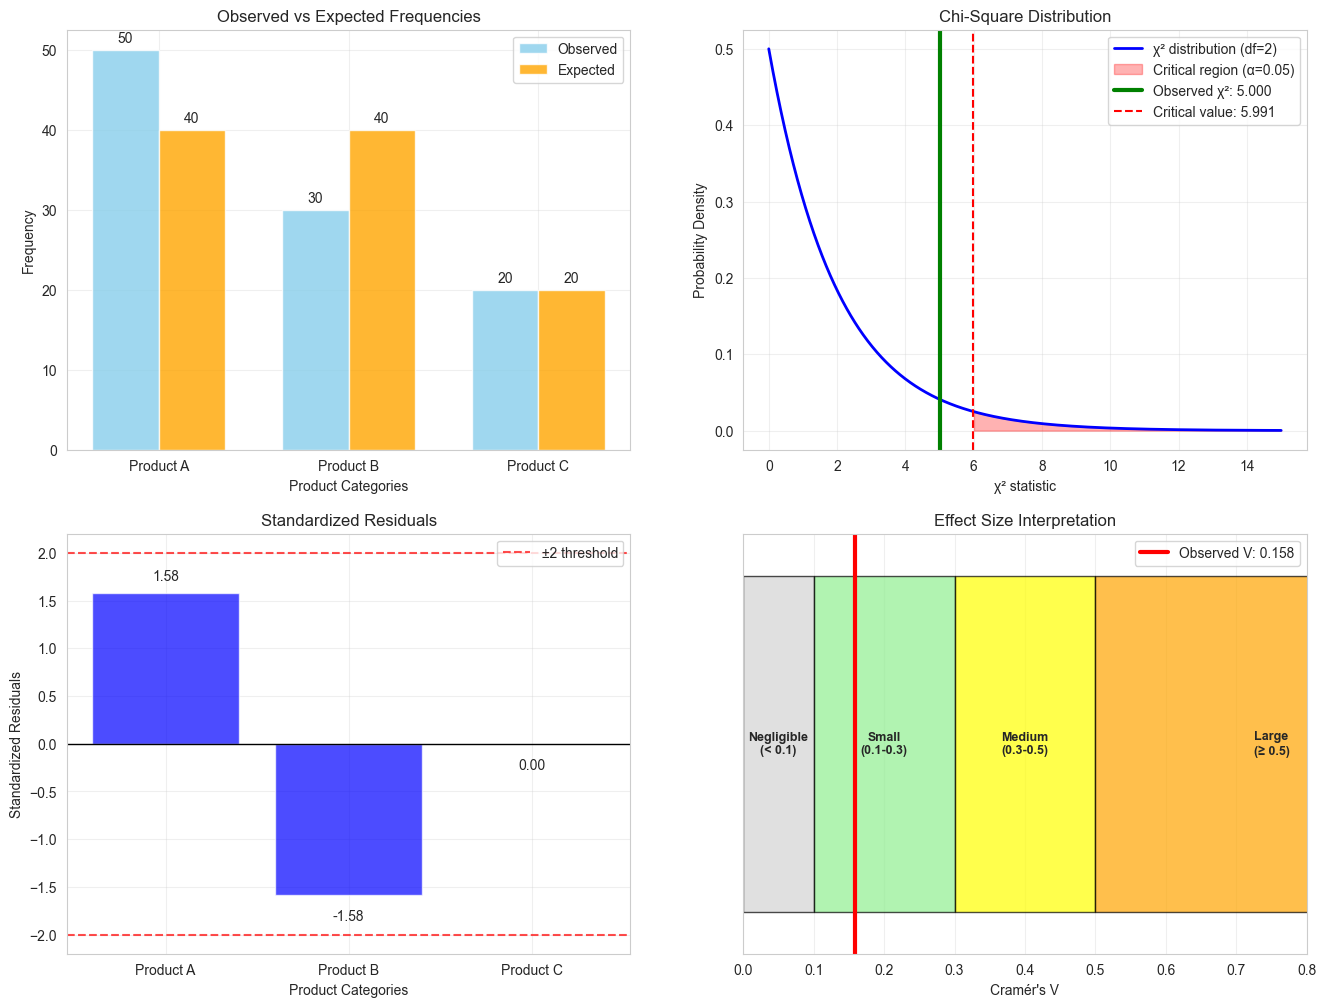

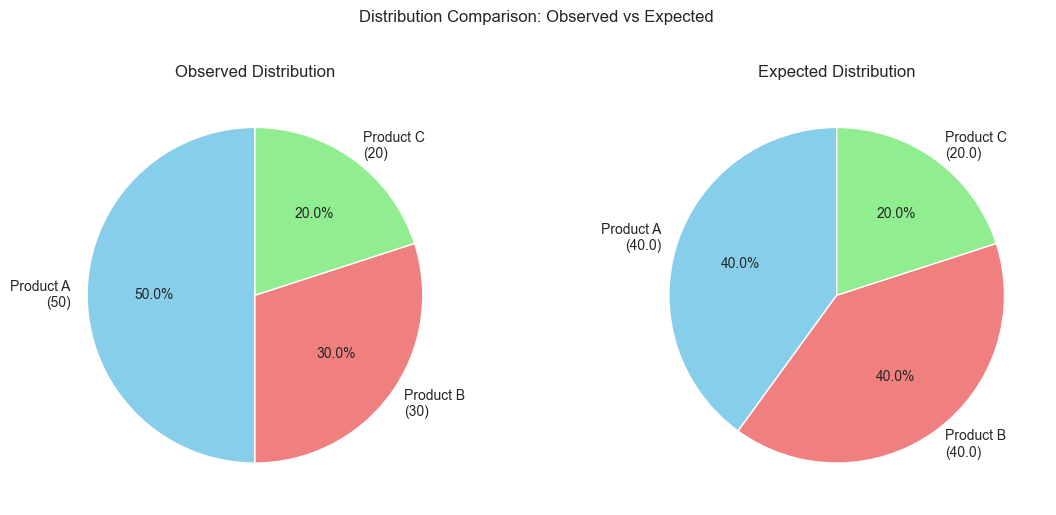


=== Detailed Results Table ===
 Category  Observed  Expected   O-E  (O-E)²  (O-E)²/E  Std_Residual
Product A        50        40  10.0   100.0       2.5        1.5811
Product B        30        40 -10.0   100.0       2.5       -1.5811
Product C        20        20   0.0     0.0       0.0        0.0000

=== Interpretation ===
Chi-square statistic: 5.0000
The observed distribution does not significantly differ from the expected distribution (α = 0.05).
Effect size: small association

Conclusion: The data do not provide sufficient evidence to reject the null hypothesis
that customer preferences follow the expected 40%-40%-20% distribution.


In [9]:
# Chi-square goodness-of-fit test: Comprehensive analysis
# Scenario: Test if customer preference follows expected distribution
# Categories: Product A, Product B, Product C
# Expected distribution: 40%, 40%, 20%

observed = np.array([50, 30, 20])
total_n = observed.sum()
expected_props = np.array([0.4, 0.4, 0.2])
expected = expected_props * total_n

categories = ['Product A', 'Product B', 'Product C']

print("=== Chi-Square Goodness-of-Fit Test ===")
print(f"Total sample size: {total_n}")
print("Observed vs Expected frequencies:")
for i, cat in enumerate(categories):
    print(f"{cat}: Observed = {observed[i]}, Expected = {expected[i]:.1f}")

# Check assumptions
print(f"\n=== Assumption Check ===")
min_expected = expected.min()
print(f"Minimum expected frequency: {min_expected:.1f}")
print(f"All expected frequencies ≥ 5: {'✓' if min_expected >= 5 else '✗'}")

# Calculate test statistic manually
chi2_components = (observed - expected)**2 / expected
chi2_manual = chi2_components.sum()
df = len(observed) - 1

print(f"\n=== Manual Calculation ===")
print("Chi-square components:")
for i, cat in enumerate(categories):
    print(f"{cat}: (O-E)²/E = ({observed[i]}-{expected[i]:.1f})²/{expected[i]:.1f} = {chi2_components[i]:.4f}")

print(f"Chi-square statistic: {chi2_manual:.4f}")
print(f"Degrees of freedom: {df}")

# Using scipy
stat, p = stats.chisquare(f_obs=observed, f_exp=expected)
report_test("Chi-square goodness-of-fit", stat, p)

# Effect size (Cramér's V)
cramers_v = np.sqrt(chi2_manual / (total_n * (len(categories) - 1)))
print(f"Cramér's V (effect size): {cramers_v:.4f}")

# Interpret effect size
if cramers_v < 0.1:
    effect_interp = "negligible"
elif cramers_v < 0.3:
    effect_interp = "small"
elif cramers_v < 0.5:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"Effect size interpretation: {effect_interp}")

# Critical value
alpha = 0.05
chi2_critical = stats.chi2.ppf(1 - alpha, df)
print(f"\nCritical value (α = {alpha}): {chi2_critical:.4f}")

# Standardized residuals
std_residuals = (observed - expected) / np.sqrt(expected)
print(f"\n=== Standardized Residuals ===")
for i, cat in enumerate(categories):
    print(f"{cat}: {std_residuals[i]:.3f}")
print("Residuals with |value| > 2 indicate significant deviation from expected")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Bar chart: Observed vs Expected
x_pos = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, observed, width, label='Observed', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, expected, width, label='Expected', color='orange', alpha=0.8)

ax1.set_xlabel('Product Categories')
ax1.set_ylabel('Frequency')
ax1.set_title('Observed vs Expected Frequencies')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.0f}', ha='center', va='bottom')

# Chi-square distribution
x_chi2 = np.linspace(0, 15, 1000)
y_chi2 = stats.chi2.pdf(x_chi2, df)
ax2.plot(x_chi2, y_chi2, 'b-', linewidth=2, label=f'χ² distribution (df={df})')

# Critical region
x_crit = x_chi2[x_chi2 >= chi2_critical]
y_crit = y_chi2[x_chi2 >= chi2_critical]
ax2.fill_between(x_crit, y_crit, alpha=0.3, color='red', label=f'Critical region (α={alpha})')

# Observed chi-square
ax2.axvline(chi2_manual, color='green', linewidth=3, label=f'Observed χ²: {chi2_manual:.3f}')
ax2.axvline(chi2_critical, color='red', linestyle='--', label=f'Critical value: {chi2_critical:.3f}')

ax2.set_xlabel('χ² statistic')
ax2.set_ylabel('Probability Density')
ax2.set_title('Chi-Square Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuals plot
colors = ['red' if abs(res) > 2 else 'blue' for res in std_residuals]
bars3 = ax3.bar(categories, std_residuals, color=colors, alpha=0.7)
ax3.axhline(0, color='black', linewidth=1)
ax3.axhline(2, color='red', linestyle='--', alpha=0.7, label='±2 threshold')
ax3.axhline(-2, color='red', linestyle='--', alpha=0.7)

ax3.set_xlabel('Product Categories')
ax3.set_ylabel('Standardized Residuals')
ax3.set_title('Standardized Residuals')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, res in zip(bars3, std_residuals):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.15),
            f'{res:.2f}', ha='center', va='bottom' if height > 0 else 'top')

# Pie charts comparison
fig2, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5))

# Observed proportions pie chart
observed_props = observed / total_n
ax_left.pie(observed_props, labels=[f'{cat}\n({obs})' for cat, obs in zip(categories, observed)],
           autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
ax_left.set_title('Observed Distribution')

# Expected proportions pie chart
ax_right.pie(expected_props, labels=[f'{cat}\n({exp:.1f})' for cat, exp in zip(categories, expected)],
            autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
ax_right.set_title('Expected Distribution')

plt.suptitle('Distribution Comparison: Observed vs Expected', y=1.02)

# Effect size visualization
effect_levels = ['Negligible\n(< 0.1)', 'Small\n(0.1-0.3)', 'Medium\n(0.3-0.5)', 'Large\n(≥ 0.5)']
effect_bounds = [0, 0.1, 0.3, 0.5, 1.0]
effect_colors = ['lightgray', 'lightgreen', 'yellow', 'orange']

for i in range(len(effect_bounds)-1):
    ax4.barh(0, effect_bounds[i+1] - effect_bounds[i], left=effect_bounds[i],
             color=effect_colors[i], alpha=0.7, edgecolor='black')

ax4.axvline(cramers_v, color='red', linewidth=3, label=f'Observed V: {cramers_v:.3f}')
ax4.set_xlim(0, 0.8)
ax4.set_ylim(-0.5, 0.5)
ax4.set_xlabel("Cramér's V")
ax4.set_title('Effect Size Interpretation')
ax4.set_yticks([])

# Add text labels
for i, (label, bound) in enumerate(zip(effect_levels, effect_bounds[:-1])):
    mid_point = bound + (effect_bounds[i+1] - bound) / 2
    if mid_point <= 0.8:
        ax4.text(mid_point, 0, label, ha='center', va='center', fontsize=9, fontweight='bold')

ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create detailed results table
results_df = pd.DataFrame({
    'Category': categories,
    'Observed': observed,
    'Expected': expected.astype(int),
    'O-E': observed - expected,
    '(O-E)²': (observed - expected)**2,
    '(O-E)²/E': chi2_components,
    'Std_Residual': std_residuals
})

print(f"\n=== Detailed Results Table ===")
print(results_df.round(4).to_string(index=False))

print(f"\n=== Interpretation ===")
print(f"Chi-square statistic: {chi2_manual:.4f}")
print(f"The observed distribution {'significantly differs from' if p < 0.05 else 'does not significantly differ from'} the expected distribution (α = 0.05).")
print(f"Effect size: {effect_interp} association")

if p < 0.05:
    max_residual_idx = np.argmax(np.abs(std_residuals))
    print(f"The largest deviation is in {categories[max_residual_idx]} (standardized residual = {std_residuals[max_residual_idx]:.3f})")

print(f"\nConclusion: The data {'provide sufficient' if p < 0.05 else 'do not provide sufficient'} evidence to reject the null hypothesis")
print(f"that customer preferences follow the expected 40%-40%-20% distribution.")

### 4.2 Chi-Square Test of Independence

**When to use:** Test whether two categorical variables are independent.

**Assumptions:**
1. Random sampling
2. Expected frequency ≥ 5 for each cell (some sources allow ≥ 1 with no more than 20% of cells < 5)
3. Independent observations
4. Categorical data

**Mathematical Framework:**

**Hypotheses:**
- H₀: The two variables are independent (no association)
- H₁: The two variables are not independent (association exists)

**Test Statistic:**
$$\chi^2 = \sum_{i=1}^r \sum_{j=1}^c \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

**Expected Frequency:**
$$E_{ij} = \frac{(\text{Row}_i \text{ Total}) \times (\text{Column}_j \text{ Total})}{\text{Grand Total}}$$

**Degrees of Freedom:** $df = (r-1)(c-1)$ where r = rows, c = columns

**Effect Size (Cramér's V):**
$$V = \sqrt{\frac{\chi^2}{n \times \min(r-1, c-1)}}$$

**Phi Coefficient (for 2×2 tables):**
$$\phi = \sqrt{\frac{\chi^2}{n}}$$

**Scenario:** Test if device type is independent of conversion outcome.

=== Chi-Square Test of Independence ===
Contingency Table:
                 Converted  Not Converted  Total
Desktop           200            50    250
Mobile            150            70    220
Total                 350           120    470

=== Expected Frequencies (Manual Calculation) ===
Expected frequencies if independent:
                 Converted  Not Converted
Desktop        186.17         63.83
Mobile         163.83         56.17

=== Assumption Check ===
Minimum expected frequency: 56.17
Cells with expected frequency < 5: 0/4 (0.0%)
Assumption met: ✓

=== Chi-Square Test Results ===
Chi-square statistic: 7.9860
p-value: 0.004714
Degrees of freedom: 1
=== Chi-square test of independence ===
Test statistic: 7.9860
p-value: 0.004714
Decision (alpha=0.05): Reject H0


=== Effect Sizes ===
Cramér's V: 0.1304
Phi coefficient: 0.1304
Effect size interpretation: small

=== Standardized Residuals ===
Standardized residuals (|value| > 2 indicates significant contribution):
            

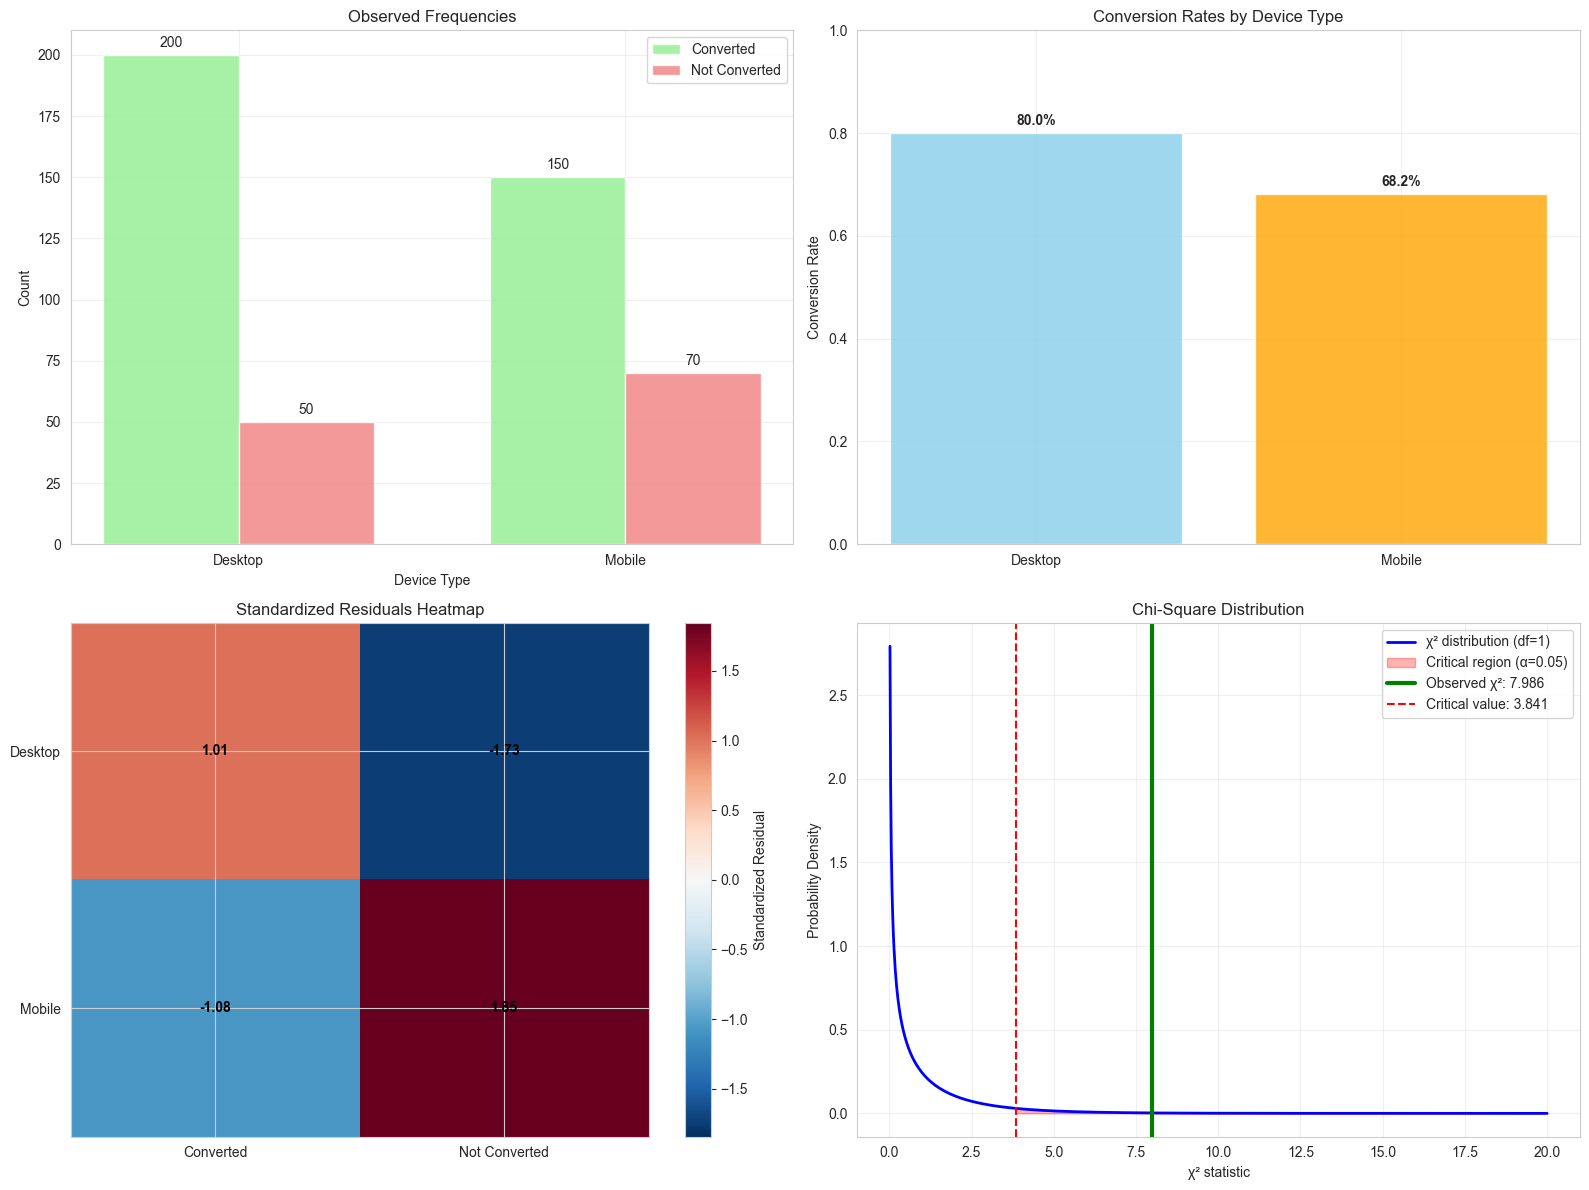

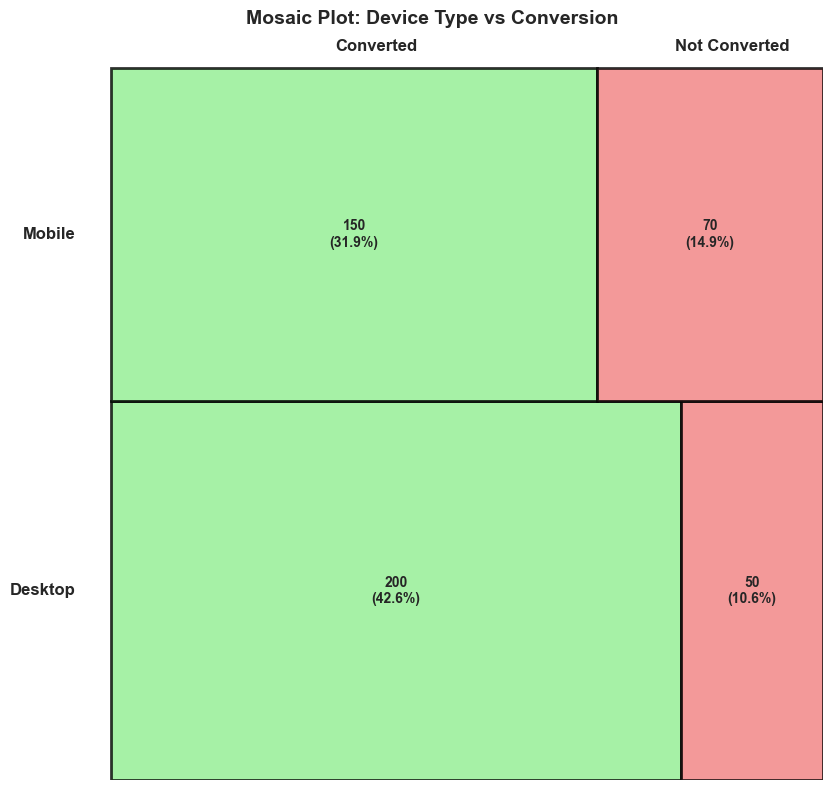


=== Summary Results ===
         Statistic    Value                                Interpretation
        Chi-square   7.9860                                Test statistic
           p-value 0.004714 Probability of observing this result under H₀
Degrees of freedom        1   Number of independent pieces of information
        Cramér's V   0.1304                             Small association
   Phi coefficient   0.1304                 Small association (2×2 table)

=== Interpretation ===
Chi-square statistic: 7.9860 with 1 degree(s) of freedom
There is a statistically significant association between device type and conversion (α = 0.05).
Effect size: small association (Cramér's V = 0.130)
The strongest association is for Mobile users and Not Converted outcome.

Conversion rate difference: 11.8% (Desktop higher than Mobile)
Practical significance: Notable difference in conversion rates.


In [11]:
# Chi-square test of independence: Comprehensive analysis
# Scenario: Test if device type affects conversion rates
# 2x2 contingency table: Device Type (Desktop/Mobile) vs Conversion (Yes/No)

contingency = np.array([[200, 50],   # Desktop: Converted, Not Converted
                        [150, 70]])  # Mobile: Converted, Not Converted

device_labels = ['Desktop', 'Mobile']
conversion_labels = ['Converted', 'Not Converted']

print("=== Chi-Square Test of Independence ===")
print("Contingency Table:")
print("                 Converted  Not Converted  Total")
for i, device in enumerate(device_labels):
    row_total = contingency[i].sum()
    print(f"{device:8s}     {contingency[i,0]:8d}  {contingency[i,1]:12d}  {row_total:5d}")

# Calculate totals
row_totals = contingency.sum(axis=1)
col_totals = contingency.sum(axis=0)
grand_total = contingency.sum()

col_total_converted = col_totals[0]
col_total_not_converted = col_totals[1]
print(f"Total            {col_total_converted:8d}  {col_total_not_converted:12d}  {grand_total:5d}")

# Calculate expected frequencies manually
expected_manual = np.zeros_like(contingency, dtype=float)
for i in range(contingency.shape[0]):
    for j in range(contingency.shape[1]):
        expected_manual[i,j] = (row_totals[i] * col_totals[j]) / grand_total

print(f"\n=== Expected Frequencies (Manual Calculation) ===")
print("Expected frequencies if independent:")
print("                 Converted  Not Converted")
for i, device in enumerate(device_labels):
    print(f"{device:8s}     {expected_manual[i,0]:8.2f}  {expected_manual[i,1]:12.2f}")

# Check assumptions
min_expected = expected_manual.min()
cells_less_than_5 = (expected_manual < 5).sum()
total_cells = expected_manual.size
percent_less_than_5 = (cells_less_than_5 / total_cells) * 100

print(f"\n=== Assumption Check ===")
print(f"Minimum expected frequency: {min_expected:.2f}")
print(f"Cells with expected frequency < 5: {cells_less_than_5}/{total_cells} ({percent_less_than_5:.1f}%)")
print(f"Assumption met: {'✓' if min_expected >= 1 and percent_less_than_5 <= 20 else '✗'}")

# Using scipy
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(f"\n=== Chi-Square Test Results ===")
print(f"Chi-square statistic: {stat:.4f}")
print(f"p-value: {p:.6f}")
print(f"Degrees of freedom: {dof}")

report_test("Chi-square test of independence", stat, p)

# Effect sizes
# Cramér's V
min_dim = min(contingency.shape[0]-1, contingency.shape[1]-1)
cramers_v = np.sqrt(stat / (grand_total * min_dim))

# Phi coefficient (for 2x2 table)
phi = np.sqrt(stat / grand_total)

print(f"\n=== Effect Sizes ===")
print(f"Cramér's V: {cramers_v:.4f}")
print(f"Phi coefficient: {phi:.4f}")

# Interpret effect size
if cramers_v < 0.1:
    effect_interp = "negligible"
elif cramers_v < 0.3:
    effect_interp = "small"
elif cramers_v < 0.5:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"Effect size interpretation: {effect_interp}")

# Calculate standardized residuals
std_residuals = (contingency - expected) / np.sqrt(expected)
print(f"\n=== Standardized Residuals ===")
print("Standardized residuals (|value| > 2 indicates significant contribution):")
print("                 Converted  Not Converted")
for i, device in enumerate(device_labels):
    print(f"{device:8s}     {std_residuals[i,0]:8.3f}  {std_residuals[i,1]:12.3f}")

# Calculate conversion rates
conversion_rates = contingency[:, 0] / row_totals
print(f"\n=== Conversion Rates ===")
for i, device in enumerate(device_labels):
    print(f"{device}: {conversion_rates[i]:.3f} ({conversion_rates[i]*100:.1f}%)")

rate_difference = conversion_rates[0] - conversion_rates[1]
print(f"Difference (Desktop - Mobile): {rate_difference:.3f} ({rate_difference*100:.1f} percentage points)")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Grouped bar chart of observed frequencies
x = np.arange(len(device_labels))
width = 0.35

bars1 = ax1.bar(x - width/2, contingency[:, 0], width, label='Converted', color='lightgreen', alpha=0.8)
bars2 = ax1.bar(x + width/2, contingency[:, 1], width, label='Not Converted', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Device Type')
ax1.set_ylabel('Count')
ax1.set_title('Observed Frequencies')
ax1.set_xticks(x)
ax1.set_xticklabels(device_labels)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{int(height)}', ha='center', va='bottom')

# Conversion rates bar chart
bars3 = ax2.bar(device_labels, conversion_rates, color=['skyblue', 'orange'], alpha=0.8)
ax2.set_ylabel('Conversion Rate')
ax2.set_title('Conversion Rates by Device Type')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Add percentage labels
for bar, rate in zip(bars3, conversion_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# Heatmap of standardized residuals
# Create centered colormap for residuals
vmax = np.abs(std_residuals).max()
im = ax3.imshow(std_residuals, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='auto')
ax3.set_xticks(range(len(conversion_labels)))
ax3.set_yticks(range(len(device_labels)))
ax3.set_xticklabels(conversion_labels)
ax3.set_yticklabels(device_labels)
ax3.set_title('Standardized Residuals Heatmap')

# Add text annotations
for i in range(len(device_labels)):
    for j in range(len(conversion_labels)):
        text = ax3.text(j, i, f'{std_residuals[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax3, label='Standardized Residual')

# Chi-square distribution
x_chi2 = np.linspace(0, 20, 1000)
y_chi2 = stats.chi2.pdf(x_chi2, dof)
ax4.plot(x_chi2, y_chi2, 'b-', linewidth=2, label=f'χ² distribution (df={dof})')

# Critical region
alpha = 0.05
chi2_critical = stats.chi2.ppf(1 - alpha, dof)
x_crit = x_chi2[x_chi2 >= chi2_critical]
y_crit = y_chi2[x_chi2 >= chi2_critical]
ax4.fill_between(x_crit, y_crit, alpha=0.3, color='red', label=f'Critical region (α={alpha})')

# Observed chi-square
ax4.axvline(stat, color='green', linewidth=3, label=f'Observed χ²: {stat:.3f}')
ax4.axvline(chi2_critical, color='red', linestyle='--', label=f'Critical value: {chi2_critical:.3f}')

ax4.set_xlabel('χ² statistic')
ax4.set_ylabel('Probability Density')
ax4.set_title('Chi-Square Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create mosaic plot (proportional representation)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Calculate proportions for mosaic plot
row_props = row_totals / grand_total
col_props = col_totals / grand_total

# Create the mosaic plot
y_offset = 0
colors = ['lightgreen', 'lightcoral']
for i, device in enumerate(device_labels):
    x_offset = 0
    row_height = row_props[i]

    for j, outcome in enumerate(conversion_labels):
        cell_prop = contingency[i, j] / grand_total
        cell_width = cell_prop / row_height

        rect = plt.Rectangle((x_offset, y_offset), cell_width, row_height,
                           facecolor=colors[j], alpha=0.8, edgecolor='black', linewidth=2)
        ax.add_patch(rect)

        # Add text label
        text_x = x_offset + cell_width/2
        text_y = y_offset + row_height/2
        ax.text(text_x, text_y, f'{contingency[i,j]}\n({cell_prop:.1%})',
               ha='center', va='center', fontweight='bold')

        x_offset += cell_width

    # Add device label
    ax.text(-0.05, y_offset + row_height/2, device,
           ha='right', va='center', fontweight='bold', fontsize=12)

    y_offset += row_height

# Add outcome labels at the top
cumsum = 0
for j, outcome in enumerate(conversion_labels):
    width = col_props[j]
    ax.text(cumsum + width/2, 1.02, outcome,
           ha='center', va='bottom', fontweight='bold', fontsize=12)
    cumsum += width

ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 1.05)
ax.set_aspect('equal')
ax.set_title('Mosaic Plot: Device Type vs Conversion', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

# Summary table
print(f"\n=== Summary Results ===")
summary_data = {
    'Statistic': ['Chi-square', 'p-value', 'Degrees of freedom', "Cramér's V", 'Phi coefficient'],
    'Value': [f"{stat:.4f}", f"{p:.6f}", f"{dof}", f"{cramers_v:.4f}", f"{phi:.4f}"],
    'Interpretation': [
        'Test statistic',
        'Probability of observing this result under H₀',
        'Number of independent pieces of information',
        f'{effect_interp.capitalize()} association',
        f'{effect_interp.capitalize()} association (2×2 table)'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n=== Interpretation ===")
print(f"Chi-square statistic: {stat:.4f} with {dof} degree(s) of freedom")
print(f"There {'is' if p < 0.05 else 'is not'} a statistically significant association between device type and conversion (α = 0.05).")
print(f"Effect size: {effect_interp} association (Cramér's V = {cramers_v:.3f})")

if p < 0.05:
    max_residual = np.unravel_index(np.argmax(np.abs(std_residuals)), std_residuals.shape)
    device_name = device_labels[max_residual[0]]
    outcome_name = conversion_labels[max_residual[1]]
    print(f"The strongest association is for {device_name} users and {outcome_name} outcome.")

print(f"\nConversion rate difference: {rate_difference:.1%} (Desktop higher than Mobile)")
print(f"Practical significance: {'Notable' if abs(rate_difference) > 0.05 else 'Minimal'} difference in conversion rates.")

## 5. One-Way ANOVA (Analysis of Variance)

**When to use:** Compare means of three or more independent groups.

**Assumptions:**
1. Independence of observations
2. Normality of residuals within each group
3. Homogeneity of variances (homoscedasticity)
4. Interval/ratio level dependent variable

**Mathematical Framework:**

**Hypotheses:**
- H₀: μ₁ = μ₂ = μ₃ = ... = μₖ (all group means are equal)
- H₁: At least one group mean differs from the others

**Total Sum of Squares Decomposition:**
$$SS_{Total} = SS_{Between} + SS_{Within}$$

**Between-Groups Sum of Squares:**
$$SS_{Between} = \sum_{i=1}^k n_i(\bar{x}_i - \bar{x}_{grand})^2$$

**Within-Groups Sum of Squares:**
$$SS_{Within} = \sum_{i=1}^k \sum_{j=1}^{n_i} (x_{ij} - \bar{x}_i)^2$$

**Mean Squares:**
$$MS_{Between} = \frac{SS_{Between}}{df_{Between}} = \frac{SS_{Between}}{k-1}$$
$$MS_{Within} = \frac{SS_{Within}}{df_{Within}} = \frac{SS_{Within}}{N-k}$$

**F-Statistic:**
$$F = \frac{MS_{Between}}{MS_{Within}}$$

**Degrees of Freedom:**
- $df_{Between} = k - 1$ (number of groups - 1)
- $df_{Within} = N - k$ (total observations - number of groups)

**Effect Size (Eta-squared, η²):**
$$\eta^2 = \frac{SS_{Between}}{SS_{Total}}$$

**Omega-squared (ω², less biased):**
$$\omega^2 = \frac{SS_{Between} - (k-1)MS_{Within}}{SS_{Total} + MS_{Within}}$$

**Scenario:** Compare mean customer satisfaction scores across 3 website versions (A, B, C).

=== One-Way ANOVA Analysis ===
Group Summary Statistics:
Group        n     Mean     Std Dev
-----------------------------------
Version A   40    76.47     6.67
Version B   38    75.12     5.61
Version C   42    79.72     7.17

=== Assumption Checks ===
Levene's test for equal variances:
  Statistic: 0.4197, p-value: 0.6582
  Equal variances: ✓ Assumed

Shapiro-Wilk tests for normality:
  Version A: W = 0.9792, p = 0.6604 ✓
  Version B: W = 0.9713, p = 0.4282 ✓
  Version C: W = 0.9677, p = 0.2749 ✓
Overall normality assumption: ✓ Met

=== ANOVA Results ===
F-statistic: 5.2863
p-value: 0.006340
=== One-way ANOVA ===
Test statistic: 5.2863
p-value: 0.006340
Decision (alpha=0.05): Reject H0


=== Manual ANOVA Calculations ===
Grand mean: 77.1773
Group means: ['76.47', '75.12', '79.72']

Sum of Squares:
  SS_Between = 452.29
  SS_Within  = 5005.18
  SS_Total   = 5457.47
  Check: SS_Between + SS_Within = 5457.47

Degrees of Freedom:
  df_Between = 2
  df_Within  = 117
  df_Total   = 119

M

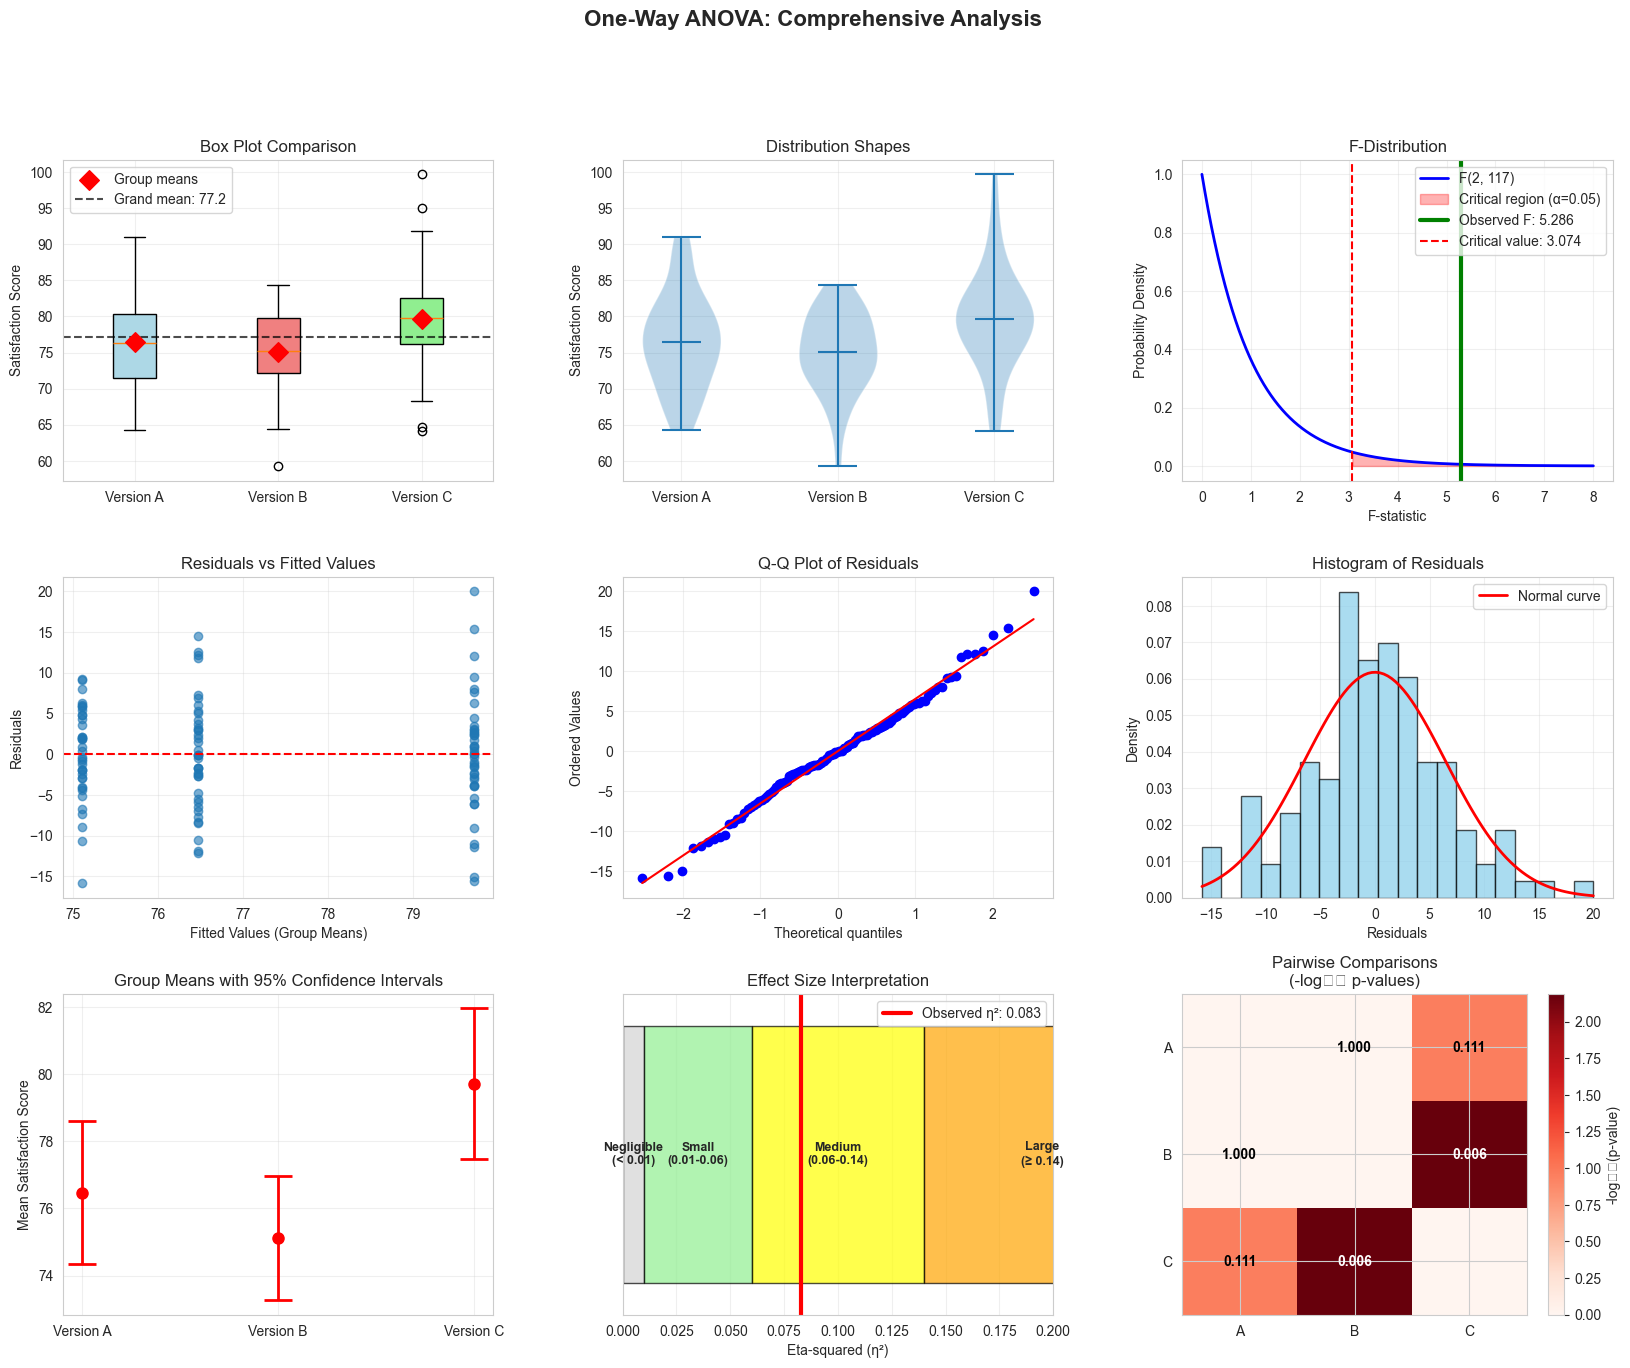


=== Interpretation ===
F-statistic: 5.2863 with df = (2, 117)
The ANOVA test indicates significant differences between group means (α = 0.05).
Effect size: medium (η² = 0.083)
Approximately 8.3% of the variance in satisfaction is explained by website version.

Significant pairwise differences (Bonferroni-adjusted):
  Version B vs Version C: Mean difference = -4.60, p = 0.0065

Assumption assessment:
  Equal variances: Met
  Normality: Met

Practical conclusion:
Website Version C shows the highest satisfaction (mean = 79.7),
followed by Version A (mean = 76.5) and Version B (mean = 75.1).


In [12]:
# One-way ANOVA: Comprehensive analysis
# Scenario: Compare customer satisfaction across 3 website versions
np.random.seed(42)

# Generate sample data for three groups
A = np.random.normal(78, 7, 40)  # Version A: mean=78, std=7, n=40
B = np.random.normal(75, 6, 38)  # Version B: mean=75, std=6, n=38
C = np.random.normal(80, 8, 42)  # Version C: mean=80, std=8, n=42

groups = [A, B, C]
group_names = ['Version A', 'Version B', 'Version C']
n_groups = len(groups)
group_sizes = [len(group) for group in groups]
total_n = sum(group_sizes)

print("=== One-Way ANOVA Analysis ===")
print("Group Summary Statistics:")
print("Group        n     Mean     Std Dev")
print("-" * 35)
for i, (group, name) in enumerate(zip(groups, group_names)):
    print(f"{name:8s} {len(group):4d} {group.mean():8.2f} {group.std(ddof=1):8.2f}")

# Check assumptions
print(f"\n=== Assumption Checks ===")

# 1. Test for equal variances (Levene's test)
levene_stat, levene_p = stats.levene(*groups)
print(f"Levene's test for equal variances:")
print(f"  Statistic: {levene_stat:.4f}, p-value: {levene_p:.4f}")
print(f"  Equal variances: {'✓ Assumed' if levene_p > 0.05 else '✗ Violated'}")

# 2. Test for normality (Shapiro-Wilk for each group)
print(f"\nShapiro-Wilk tests for normality:")
normal_assumptions_met = True
for i, (group, name) in enumerate(zip(groups, group_names)):
    sw_stat, sw_p = stats.shapiro(group)
    is_normal = sw_p > 0.05
    normal_assumptions_met &= is_normal
    print(f"  {name}: W = {sw_stat:.4f}, p = {sw_p:.4f} {'✓' if is_normal else '✗'}")

print(f"Overall normality assumption: {'✓ Met' if normal_assumptions_met else '✗ Questionable'}")

# Perform ANOVA
stat, p = stats.f_oneway(*groups)
print(f"\n=== ANOVA Results ===")
print(f"F-statistic: {stat:.4f}")
print(f"p-value: {p:.6f}")

report_test("One-way ANOVA", stat, p)

# Manual ANOVA calculations for educational purposes
all_data = np.concatenate(groups)
grand_mean = all_data.mean()
group_means = [group.mean() for group in groups]

print(f"\n=== Manual ANOVA Calculations ===")
print(f"Grand mean: {grand_mean:.4f}")
print(f"Group means: {[f'{mean:.2f}' for mean in group_means]}")

# Calculate sum of squares
ss_between = sum(n * (mean - grand_mean)**2 for n, mean in zip(group_sizes, group_means))
ss_within = sum(sum((x - group.mean())**2 for x in group) for group in groups)
ss_total = sum((x - grand_mean)**2 for x in all_data)

print(f"\nSum of Squares:")
print(f"  SS_Between = {ss_between:.2f}")
print(f"  SS_Within  = {ss_within:.2f}")
print(f"  SS_Total   = {ss_total:.2f}")
print(f"  Check: SS_Between + SS_Within = {ss_between + ss_within:.2f}")

# Degrees of freedom
df_between = n_groups - 1
df_within = total_n - n_groups
df_total = total_n - 1

print(f"\nDegrees of Freedom:")
print(f"  df_Between = {df_between}")
print(f"  df_Within  = {df_within}")
print(f"  df_Total   = {df_total}")

# Mean squares
ms_between = ss_between / df_between
ms_within = ss_within / df_within

print(f"\nMean Squares:")
print(f"  MS_Between = {ms_between:.2f}")
print(f"  MS_Within  = {ms_within:.2f}")

# F-statistic (manual)
f_manual = ms_between / ms_within
print(f"\nF-statistic (manual): {f_manual:.4f}")

# Effect sizes
eta_squared = ss_between / ss_total
omega_squared = (ss_between - df_between * ms_within) / (ss_total + ms_within)

print(f"\n=== Effect Sizes ===")
print(f"Eta-squared (η²): {eta_squared:.4f}")
print(f"Omega-squared (ω²): {omega_squared:.4f}")

# Interpret effect size
if eta_squared < 0.01:
    effect_interp = "negligible"
elif eta_squared < 0.06:
    effect_interp = "small"
elif eta_squared < 0.14:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"Effect size interpretation: {effect_interp}")

# Create ANOVA table
anova_table = pd.DataFrame({
    'Source': ['Between Groups', 'Within Groups', 'Total'],
    'SS': [ss_between, ss_within, ss_total],
    'df': [df_between, df_within, df_total],
    'MS': [ms_between, ms_within, ''],
    'F': [f_manual, '', ''],
    'p-value': [p, '', '']
})

print(f"\n=== ANOVA Table ===")
print(anova_table.to_string(index=False))

# Post-hoc analysis (pairwise comparisons with Bonferroni correction)
print(f"\n=== Post-Hoc Analysis (Bonferroni Correction) ===")
alpha = 0.05
n_comparisons = (n_groups * (n_groups - 1)) // 2
bonferroni_alpha = alpha / n_comparisons

print(f"Number of pairwise comparisons: {n_comparisons}")
print(f"Bonferroni-adjusted α: {bonferroni_alpha:.4f}")

comparisons = []
for i in range(n_groups):
    for j in range(i+1, n_groups):
        t_stat, p_val = stats.ttest_ind(groups[i], groups[j], equal_var=True)
        p_adj = min(p_val * n_comparisons, 1.0)  # Bonferroni adjustment

        # Cohen's d for the pair
        pooled_std = np.sqrt(((len(groups[i])-1)*groups[i].var(ddof=1) +
                             (len(groups[j])-1)*groups[j].var(ddof=1)) /
                            (len(groups[i]) + len(groups[j]) - 2))
        cohens_d = (groups[i].mean() - groups[j].mean()) / pooled_std

        comparisons.append({
            'Comparison': f"{group_names[i]} vs {group_names[j]}",
            'Mean Diff': groups[i].mean() - groups[j].mean(),
            't-stat': t_stat,
            'p-value': p_val,
            'p-adj (Bonf)': p_adj,
            'Significant': 'Yes' if p_adj < alpha else 'No',
            "Cohen's d": cohens_d
        })

posthoc_df = pd.DataFrame(comparisons)
print(posthoc_df.round(4).to_string(index=False))

# Comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# Create a 3x3 grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Box plot comparison
ax1 = fig.add_subplot(gs[0, 0])
box_data = groups
bp = ax1.boxplot(box_data, labels=group_names, patch_artist=True)
colors = ['lightblue', 'lightcoral', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add mean markers
means = [group.mean() for group in groups]
ax1.scatter(range(1, n_groups+1), means, color='red', s=100, marker='D',
           label='Group means', zorder=10)
ax1.axhline(grand_mean, color='black', linestyle='--', alpha=0.7,
           label=f'Grand mean: {grand_mean:.1f}')

ax1.set_ylabel('Satisfaction Score')
ax1.set_title('Box Plot Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Violin plot
ax2 = fig.add_subplot(gs[0, 1])
violin_parts = ax2.violinplot(groups, positions=range(1, n_groups+1), showmeans=True)
ax2.set_xticks(range(1, n_groups+1))
ax2.set_xticklabels(group_names)
ax2.set_ylabel('Satisfaction Score')
ax2.set_title('Distribution Shapes')
ax2.grid(True, alpha=0.3)

# 3. F-distribution
ax3 = fig.add_subplot(gs[0, 2])
x_f = np.linspace(0, 8, 1000)
y_f = stats.f.pdf(x_f, df_between, df_within)
ax3.plot(x_f, y_f, 'b-', linewidth=2, label=f'F({df_between}, {df_within})')

# Critical region
f_critical = stats.f.ppf(1 - alpha, df_between, df_within)
x_crit = x_f[x_f >= f_critical]
y_crit = y_f[x_f >= f_critical]
ax3.fill_between(x_crit, y_crit, alpha=0.3, color='red',
                label=f'Critical region (α={alpha})')

ax3.axvline(stat, color='green', linewidth=3, label=f'Observed F: {stat:.3f}')
ax3.axvline(f_critical, color='red', linestyle='--',
           label=f'Critical value: {f_critical:.3f}')

ax3.set_xlabel('F-statistic')
ax3.set_ylabel('Probability Density')
ax3.set_title('F-Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residuals vs fitted plot
ax4 = fig.add_subplot(gs[1, 0])
residuals = []
fitted = []
for group, mean in zip(groups, group_means):
    residuals.extend(group - mean)
    fitted.extend([mean] * len(group))

ax4.scatter(fitted, residuals, alpha=0.6)
ax4.axhline(0, color='red', linestyle='--')
ax4.set_xlabel('Fitted Values (Group Means)')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals vs Fitted Values')
ax4.grid(True, alpha=0.3)

# 5. Q-Q plot of residuals
ax5 = fig.add_subplot(gs[1, 1])
stats.probplot(residuals, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')
ax5.grid(True, alpha=0.3)

# 6. Histogram of residuals
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(residuals, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_norm = np.linspace(min(residuals), max(residuals), 100)
y_norm = stats.norm.pdf(x_norm, np.mean(residuals), np.std(residuals))
ax6.plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal curve')
ax6.set_xlabel('Residuals')
ax6.set_ylabel('Density')
ax6.set_title('Histogram of Residuals')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Group means with confidence intervals
ax7 = fig.add_subplot(gs[2, 0])
x_pos = range(1, n_groups+1)
ci_95 = []

for group in groups:
    n = len(group)
    mean = group.mean()
    se = group.std(ddof=1) / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, n-1)
    ci = t_crit * se
    ci_95.append(ci)

ax7.errorbar(x_pos, means, yerr=ci_95, fmt='o', capsize=10, capthick=2,
            color='red', markersize=8, linewidth=2)
ax7.set_xticks(x_pos)
ax7.set_xticklabels(group_names)
ax7.set_ylabel('Mean Satisfaction Score')
ax7.set_title('Group Means with 95% Confidence Intervals')
ax7.grid(True, alpha=0.3)

# 8. Effect size visualization
ax8 = fig.add_subplot(gs[2, 1])
effect_levels = ['Negligible\n(< 0.01)', 'Small\n(0.01-0.06)', 'Medium\n(0.06-0.14)', 'Large\n(≥ 0.14)']
effect_bounds = [0, 0.01, 0.06, 0.14, 0.25]
effect_colors = ['lightgray', 'lightgreen', 'yellow', 'orange']

for i in range(len(effect_bounds)-1):
    ax8.barh(0, effect_bounds[i+1] - effect_bounds[i], left=effect_bounds[i],
             color=effect_colors[i], alpha=0.7, edgecolor='black')

ax8.axvline(eta_squared, color='red', linewidth=3, label=f'Observed η²: {eta_squared:.3f}')
ax8.set_xlim(0, 0.2)
ax8.set_ylim(-0.5, 0.5)
ax8.set_xlabel("Eta-squared (η²)")
ax8.set_title('Effect Size Interpretation')
ax8.set_yticks([])

# Add text labels
for i, (label, bound) in enumerate(zip(effect_levels, effect_bounds[:-1])):
    mid_point = bound + (effect_bounds[i+1] - bound) / 2
    if mid_point <= 0.2:
        ax8.text(mid_point, 0, label, ha='center', va='center', fontsize=9, fontweight='bold')

ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Pairwise comparison heatmap
ax9 = fig.add_subplot(gs[2, 2])
p_matrix = np.ones((n_groups, n_groups))
d_matrix = np.zeros((n_groups, n_groups))

idx = 0
for i in range(n_groups):
    for j in range(i+1, n_groups):
        p_adj = comparisons[idx]['p-adj (Bonf)']
        d_val = abs(comparisons[idx]["Cohen's d"])
        p_matrix[i, j] = p_adj
        p_matrix[j, i] = p_adj
        d_matrix[i, j] = d_val
        d_matrix[j, i] = d_val
        idx += 1

# Use -log10(p) for better visualization
log_p_matrix = -np.log10(p_matrix + 1e-10)
np.fill_diagonal(log_p_matrix, 0)

im = ax9.imshow(log_p_matrix, cmap='Reds', aspect='auto')
ax9.set_xticks(range(n_groups))
ax9.set_yticks(range(n_groups))
ax9.set_xticklabels([name.replace('Version ', '') for name in group_names])
ax9.set_yticklabels([name.replace('Version ', '') for name in group_names])
ax9.set_title('Pairwise Comparisons\n(-log₁₀ p-values)')

# Add text annotations
for i in range(n_groups):
    for j in range(n_groups):
        if i != j:
            text = f'{p_matrix[i, j]:.3f}'
            color = 'white' if log_p_matrix[i, j] > 1 else 'black'
            ax9.text(j, i, text, ha="center", va="center", color=color, fontweight='bold')

plt.colorbar(im, ax=ax9, label='-log₁₀(p-value)')

plt.suptitle('One-Way ANOVA: Comprehensive Analysis', fontsize=16, fontweight='bold')
plt.show()

print(f"\n=== Interpretation ===")
print(f"F-statistic: {stat:.4f} with df = ({df_between}, {df_within})")
print(f"The ANOVA test {'indicates' if p < 0.05 else 'does not indicate'} significant differences between group means (α = 0.05).")
print(f"Effect size: {effect_interp} (η² = {eta_squared:.3f})")
print(f"Approximately {eta_squared*100:.1f}% of the variance in satisfaction is explained by website version.")

if p < 0.05:
    significant_pairs = [comp for comp in comparisons if comp['Significant'] == 'Yes']
    if significant_pairs:
        print(f"\nSignificant pairwise differences (Bonferroni-adjusted):")
        for comp in significant_pairs:
            print(f"  {comp['Comparison']}: Mean difference = {comp['Mean Diff']:.2f}, p = {comp['p-adj (Bonf)']:.4f}")
    else:
        print(f"\nNo pairwise differences remain significant after Bonferroni correction.")
        print(f"This suggests the overall ANOVA significance may be due to cumulative small differences.")

print(f"\nAssumption assessment:")
print(f"  Equal variances: {'Met' if levene_p > 0.05 else 'Violated - consider Welch ANOVA'}")
print(f"  Normality: {'Met' if normal_assumptions_met else 'Questionable - results may still be robust with large samples'}")

print(f"\nPractical conclusion:")
print(f"Website Version C shows the highest satisfaction (mean = {group_means[2]:.1f}),")
print(f"followed by Version A (mean = {group_means[0]:.1f}) and Version B (mean = {group_means[1]:.1f}).")

## 6. Confidence Intervals Recap
Compute CIs for mean, difference in means, and proportion.

In [13]:
# CI for mean (unknown sigma, t-based)
sample = np.random.normal(100, 15, 50)
mean = sample.mean(); se = sample.std(ddof=1)/np.sqrt(len(sample))
tcrit = stats.t.ppf(0.975, df=len(sample)-1)
print(f"Mean CI: ({mean - tcrit*se:.2f}, {mean + tcrit*se:.2f})")

# CI for difference in means (Welch)
X = np.random.normal(102, 12, 60)
Y = np.random.normal(97, 11, 55)
d = X.mean() - Y.mean()
se = np.sqrt(X.var(ddof=1)/len(X) + Y.var(ddof=1)/len(Y))
z = stats.norm.ppf(0.975)
print(f"Diff in means CI: ({d - z*se:.2f}, {d + z*se:.2f})")

# CI for proportion (Wilson)
count, n = 64, 120
low, high = proportion_confint(count, n, method='wilson')
print(f"Proportion CI (Wilson): ({low:.3f}, {high:.3f})\n")

Mean CI: (96.40, 104.76)
Diff in means CI: (2.10, 11.13)
Proportion CI (Wilson): (0.444, 0.620)



## 7. Power Analysis and Sample Size Determination

**Statistical Power** is the probability of correctly rejecting a false null hypothesis (avoiding Type II error).

### 7.1 Key Concepts

**Power Equation:**
$$\text{Power} = 1 - \beta = P(\text{Reject } H_0 | H_0 \text{ is false})$$

**Factors Affecting Power:**
1. **Effect Size (δ)**: Larger effects are easier to detect
2. **Sample Size (n)**: Larger samples increase power
3. **Significance Level (α)**: Higher α increases power (but increases Type I error risk)
4. **Population Variance (σ²)**: Lower variance increases power

### 7.2 Mathematical Framework

**For One-Sample t-Test:**
$$\text{Effect Size (Cohen's d)} = \frac{|\mu - \mu_0|}{\sigma}$$

**For Two-Sample t-Test:**
$$\text{Effect Size (Cohen's d)} = \frac{|\mu_1 - \mu_2|}{\sigma_{pooled}}$$

**Non-centrality Parameter (δ):**
- One-sample: $\delta = \frac{|\mu - \mu_0|}{\sigma/\sqrt{n}}$
- Two-sample: $\delta = \frac{|\mu_1 - \mu_2|}{\sigma_{pooled}\sqrt{2/n}}$ (equal n per group)

**Sample Size Formula (Two-sample t-test):**
$$n = \frac{2(z_{\alpha/2} + z_{\beta})^2}{\delta^2}$$

where $\delta$ is the standardized effect size.

### 7.3 Cohen's Conventions for Effect Sizes

| Effect Size | Cohen's d | Interpretation |
|-------------|-----------|----------------|
| Small       | 0.2       | Subtle difference |
| Medium      | 0.5       | Moderate difference |
| Large       | 0.8       | Substantial difference |

### 7.4 Power Analysis Applications

1. **Prospective**: Determine required sample size before data collection
2. **Retrospective**: Calculate achieved power after data collection
3. **Compromise**: Balance power, sample size, and detectable effect size

=== Statistical Power Analysis ===
=== Sample Size Requirements ===
Two-sample t-test (independent groups):
Effect Size    Required n per group
-----------------------------------
Small (0.2)       393
Medium (0.5)       64
Large (0.8)        26

One-sample t-test:
Effect Size    Required n
-------------------------
Small (0.2)       198
Medium (0.5)       33
Large (0.8)        14

=== Power Curves Analysis ===
Achieved power for given sample sizes (two-sample t-test):
n per group    Small d=0.2    Medium d=0.5    Large d=0.8
-------------------------------------------------------
      30         0.119         0.478         0.861
      50         0.168         0.697         0.977
     100         0.291         0.940         1.000

=== Minimum Detectable Effect Size ===
For fixed sample size, what effect can we detect with 80% power?
n per group    Detectable Cohen's d
-----------------------------------
      30         0.736
      50         0.566
     100         0.398

=== Impact o

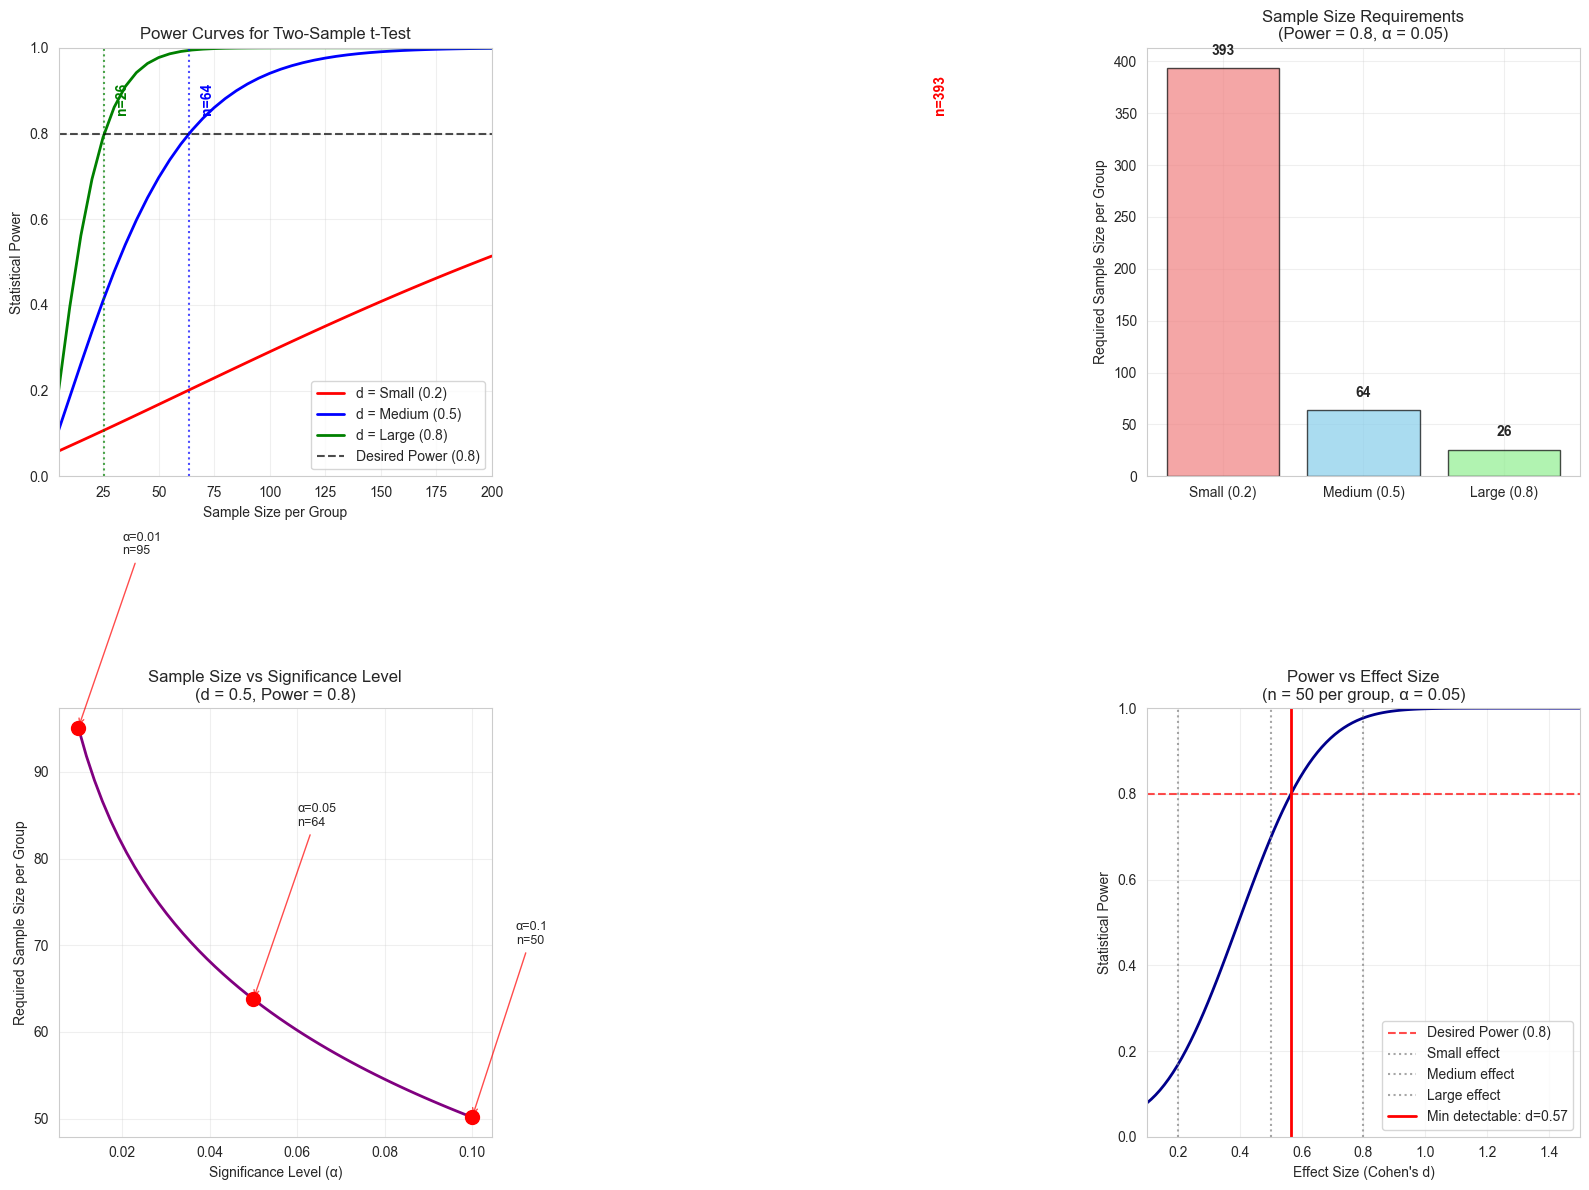

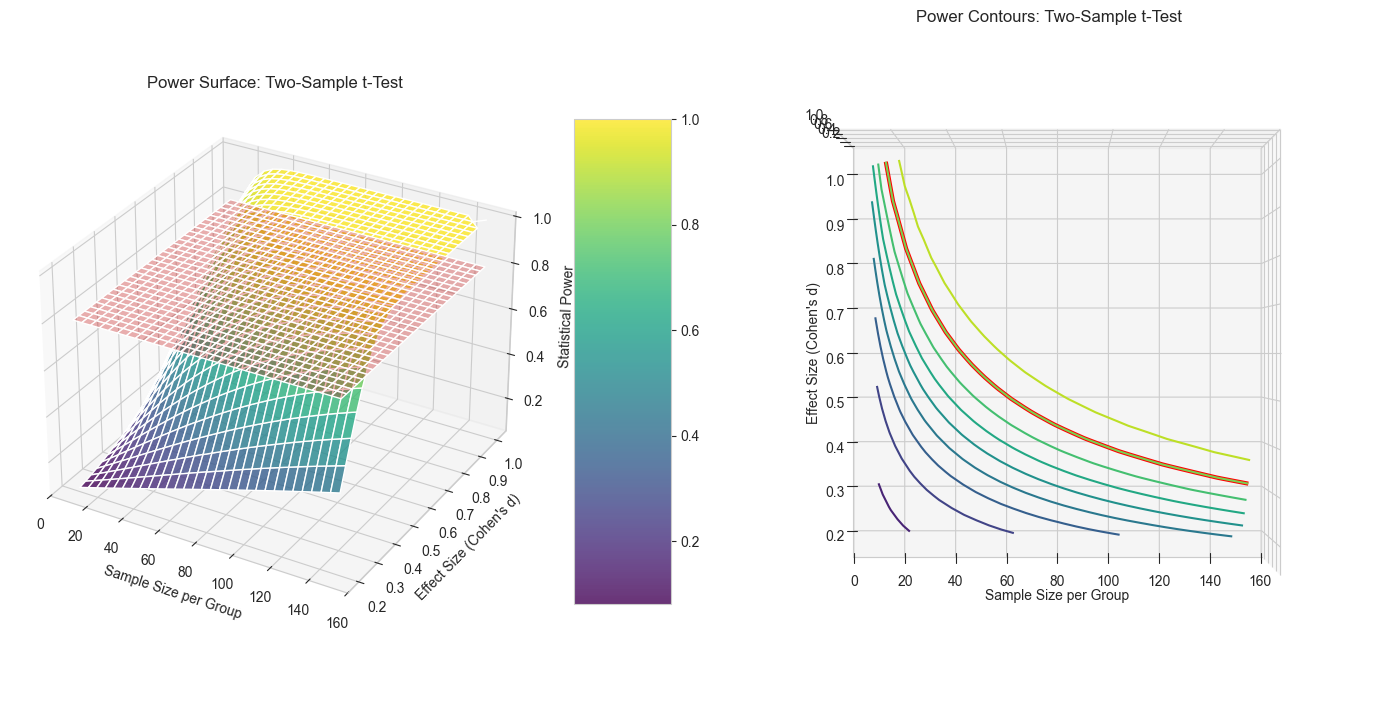


=== Practical Power Analysis Guidelines ===
1. Pre-study planning:
   - Define meaningful effect size based on domain knowledge
   - Set desired power (typically 0.8 or 0.9)
   - Choose appropriate significance level (typically 0.05)
   - Calculate required sample size

2. Post-study interpretation:
   - If non-significant result, check achieved power
   - Low power may explain failure to detect real effects
   - High power with non-significant result supports null hypothesis

3. Sample size recommendations:
   - Small effects require large samples: ~393 per group
   - Medium effects: ~64 per group
   - Large effects: ~26 per group

4. When you can't achieve desired sample size:
   - Consider increasing α (if scientifically justified)
   - Focus on detecting larger, more meaningful effects
   - Use more precise measurements to reduce variance
   - Consider within-subjects designs to increase power

=== Power Analysis Summary Table ===
                   Study       Effect  n_required 

In [20]:
# Power Analysis: Comprehensive examples and visualizations
from statsmodels.stats.power import TTestIndPower, TTestPower

print("=== Statistical Power Analysis ===")

# Initialize power analysis objects
power_ind = TTestIndPower()  # Two-sample independent t-test
power_one = TTestPower()     # One-sample t-test

# Common parameters
alpha = 0.05
desired_power = 0.8
effect_sizes = [0.2, 0.5, 0.8]  # Small, medium, large
effect_labels = ['Small (0.2)', 'Medium (0.5)', 'Large (0.8)']

print("=== Sample Size Requirements ===")
print("Two-sample t-test (independent groups):")
print("Effect Size    Required n per group")
print("-" * 35)

sample_sizes = []
for effect, label in zip(effect_sizes, effect_labels):
    n_required = power_ind.solve_power(effect_size=effect, alpha=alpha,
                                      power=desired_power, alternative='two-sided')
    sample_sizes.append(n_required)
    print(f"{label:12s}   {n_required:6.0f}")

print(f"\nOne-sample t-test:")
print("Effect Size    Required n")
print("-" * 25)

sample_sizes_one = []
for effect, label in zip(effect_sizes, effect_labels):
    n_required_one = power_one.solve_power(effect_size=effect, alpha=alpha,
                                          power=desired_power, alternative='two-sided')
    sample_sizes_one.append(n_required_one)
    print(f"{label:12s}   {n_required_one:6.0f}")

# Power curves
print(f"\n=== Power Curves Analysis ===")

# Create range of sample sizes
n_range = np.arange(5, 201, 5)

# Calculate power for different effect sizes and sample sizes
power_curves = {}
for effect in effect_sizes:
    power_curves[effect] = [power_ind.power(effect_size=effect, nobs1=n,
                                           ratio=1.0, alpha=alpha) for n in n_range]

# Achieved power for given sample sizes
sample_sizes_test = [30, 50, 100]
print("Achieved power for given sample sizes (two-sample t-test):")
print("n per group    Small d=0.2    Medium d=0.5    Large d=0.8")
print("-" * 55)

for n in sample_sizes_test:
    powers = []
    for effect in effect_sizes:
        power_achieved = power_ind.power(effect_size=effect, nobs1=n,
                                        ratio=1.0, alpha=alpha)
        powers.append(power_achieved)
    print(f"{n:8d}      {powers[0]:8.3f}      {powers[1]:8.3f}      {powers[2]:8.3f}")

# Effect size detection
print(f"\n=== Minimum Detectable Effect Size ===")
print("For fixed sample size, what effect can we detect with 80% power?")
print("n per group    Detectable Cohen's d")
print("-" * 35)

for n in sample_sizes_test:
    min_effect = power_ind.solve_power(alpha=alpha, power=desired_power,
                                      nobs1=n, ratio=1.0, alternative='two-sided')
    print(f"{n:8d}      {min_effect:8.3f}")

# Alpha level impact
alphas = [0.01, 0.05, 0.10]
print(f"\n=== Impact of Significance Level (α) ===")
print("Required sample size for medium effect (d=0.5):")
print("Alpha level    Required n per group")
print("-" * 32)

for alpha_test in alphas:
    n_alpha = power_ind.solve_power(effect_size=0.5, alpha=alpha_test,
                                   power=desired_power, alternative='two-sided')
    print(f"{alpha_test:8.2f}      {n_alpha:8.0f}")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Power curves for different effect sizes
colors = ['red', 'blue', 'green']
for effect, color, label in zip(effect_sizes, colors, effect_labels):
    ax1.plot(n_range, power_curves[effect], color=color, linewidth=2, label=f'd = {label}')

ax1.axhline(y=0.8, color='black', linestyle='--', alpha=0.7, label='Desired Power (0.8)')
ax1.set_xlabel('Sample Size per Group')
ax1.set_ylabel('Statistical Power')
ax1.set_title('Power Curves for Two-Sample t-Test')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(5, 200)
ax1.set_ylim(0, 1)

# Add vertical lines for required sample sizes
for effect, n_req, color in zip(effect_sizes, sample_sizes, colors):
    ax1.axvline(x=n_req, color=color, linestyle=':', alpha=0.7)
    ax1.text(n_req + 5, 0.85, f'n={n_req:.0f}', rotation=90,
            color=color, fontweight='bold')

# 2. Sample size requirements visualization
ax2.bar(effect_labels, sample_sizes, color=['lightcoral', 'skyblue', 'lightgreen'],
        alpha=0.7, edgecolor='black')
ax2.set_ylabel('Required Sample Size per Group')
ax2.set_title('Sample Size Requirements\n(Power = 0.8, α = 0.05)')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, (label, size) in enumerate(zip(effect_labels, sample_sizes)):
    ax2.text(i, size + 10, f'{size:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Effect of alpha on required sample size
alpha_range = np.linspace(0.01, 0.10, 50)
n_vs_alpha = [power_ind.solve_power(effect_size=0.5, alpha=a,
                                   power=0.8, alternative='two-sided') for a in alpha_range]

ax3.plot(alpha_range, n_vs_alpha, 'purple', linewidth=2)
ax3.scatter(alphas, [power_ind.solve_power(effect_size=0.5, alpha=a,
                                          power=0.8, alternative='two-sided') for a in alphas],
           color='red', s=100, zorder=10)

for alpha_val in alphas:
    n_val = power_ind.solve_power(effect_size=0.5, alpha=alpha_val,
                                 power=0.8, alternative='two-sided')
    ax3.annotate(f'α={alpha_val}\nn={n_val:.0f}', xy=(alpha_val, n_val),
                xytext=(alpha_val+0.01, n_val+20), fontsize=9,
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

ax3.set_xlabel('Significance Level (α)')
ax3.set_ylabel('Required Sample Size per Group')
ax3.set_title('Sample Size vs Significance Level\n(d = 0.5, Power = 0.8)')
ax3.grid(True, alpha=0.3)

# 4. Power vs effect size for fixed sample size
effect_range = np.linspace(0.1, 1.5, 100)
fixed_n = 50

power_vs_effect = [power_ind.power(effect_size=e, nobs1=fixed_n,
                                  ratio=1.0, alpha=0.05) for e in effect_range]

ax4.plot(effect_range, power_vs_effect, 'darkblue', linewidth=2)
ax4.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Desired Power (0.8)')
ax4.axvline(x=0.2, color='gray', linestyle=':', alpha=0.7, label='Small effect')
ax4.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Medium effect')
ax4.axvline(x=0.8, color='gray', linestyle=':', alpha=0.7, label='Large effect')

# Mark the minimum detectable effect size
min_detectable = power_ind.solve_power(alpha=0.05, power=0.8,
                                      nobs1=fixed_n, ratio=1.0, alternative='two-sided')
ax4.axvline(x=min_detectable, color='red', linewidth=2,
           label=f'Min detectable: d={min_detectable:.2f}')

ax4.set_xlabel("Effect Size (Cohen's d)")
ax4.set_ylabel('Statistical Power')
ax4.set_title(f'Power vs Effect Size\n(n = {fixed_n} per group, α = 0.05)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0.1, 1.5)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Additional visualization: 3D surface plot of Power vs n vs effect size
fig = plt.figure(figsize=(14, 10))

# Create two 3D subplots
ax1_3d = fig.add_subplot(121, projection='3d')
ax2_3d = fig.add_subplot(122, projection='3d')

# Create meshgrid for 3D plot
n_3d = np.linspace(10, 150, 30)
effect_3d = np.linspace(0.2, 1.0, 30)
N_3d, Effect_3d = np.meshgrid(n_3d, effect_3d)

# Calculate power for each combination
Power_3d = np.zeros_like(N_3d)
for i in range(N_3d.shape[0]):
    for j in range(N_3d.shape[1]):
        Power_3d[i,j] = power_ind.power(effect_size=Effect_3d[i,j],
                                       nobs1=N_3d[i,j], ratio=1.0, alpha=0.05)

# 3D surface plot
surf1 = ax1_3d.plot_surface(N_3d, Effect_3d, Power_3d, cmap='viridis', alpha=0.8)
ax1_3d.set_xlabel('Sample Size per Group')
ax1_3d.set_ylabel("Effect Size (Cohen's d)")
ax1_3d.set_zlabel('Statistical Power')
ax1_3d.set_title('Power Surface: Two-Sample t-Test')

# Add power = 0.8 plane
power_plane = np.full_like(N_3d, 0.8)
ax1_3d.plot_surface(N_3d, Effect_3d, power_plane, alpha=0.3, color='red')

fig.colorbar(surf1, ax=ax1_3d, shrink=0.5, aspect=5)

# Contour plot
contour = ax2_3d.contour(N_3d, Effect_3d, Power_3d, levels=10, cmap='viridis')
ax2_3d.clabel(contour, inline=True, fontsize=8)

# Highlight the 0.8 power contour
contour_80 = ax2_3d.contour(N_3d, Effect_3d, Power_3d, levels=[0.8], colors='red', linewidths=3)
ax2_3d.clabel(contour_80, inline=True, fontsize=10, fmt='Power=0.8')

ax2_3d.set_xlabel('Sample Size per Group')
ax2_3d.set_ylabel("Effect Size (Cohen's d)")
ax2_3d.set_title('Power Contours: Two-Sample t-Test')
ax2_3d.view_init(elev=90, azim=-90)  # Top-down view for contour plot

plt.tight_layout()
plt.show()

# Practical examples and recommendations
print(f"\n=== Practical Power Analysis Guidelines ===")
print(f"1. Pre-study planning:")
print(f"   - Define meaningful effect size based on domain knowledge")
print(f"   - Set desired power (typically 0.8 or 0.9)")
print(f"   - Choose appropriate significance level (typically 0.05)")
print(f"   - Calculate required sample size")

print(f"\n2. Post-study interpretation:")
print(f"   - If non-significant result, check achieved power")
print(f"   - Low power may explain failure to detect real effects")
print(f"   - High power with non-significant result supports null hypothesis")

print(f"\n3. Sample size recommendations:")
print(f"   - Small effects require large samples: ~{sample_sizes[0]:.0f} per group")
print(f"   - Medium effects: ~{sample_sizes[1]:.0f} per group")
print(f"   - Large effects: ~{sample_sizes[2]:.0f} per group")

print(f"\n4. When you can't achieve desired sample size:")
print(f"   - Consider increasing α (if scientifically justified)")
print(f"   - Focus on detecting larger, more meaningful effects")
print(f"   - Use more precise measurements to reduce variance")
print(f"   - Consider within-subjects designs to increase power")

# Create a power analysis summary table
scenarios = [
    {"Study": "A/B Test (Conversion)", "Effect": "Small (0.2)", "n_required": int(sample_sizes[0])},
    {"Study": "Medical Treatment", "Effect": "Medium (0.5)", "n_required": int(sample_sizes[1])},
    {"Study": "Educational Intervention", "Effect": "Large (0.8)", "n_required": int(sample_sizes[2])},
]

print(f"\n=== Power Analysis Summary Table ===")
summary_df = pd.DataFrame(scenarios)
summary_df['Power'] = '0.80'
summary_df['Alpha'] = '0.05'
summary_df['Test'] = 'Two-sample t-test'

print(summary_df.to_string(index=False))

print(f"\n=== Key Takeaways ===")
print(f"• Power analysis should be conducted BEFORE data collection")
print(f"• Effect size, sample size, power, and alpha are interconnected")
print(f"• Larger effect sizes require smaller samples to detect")
print(f"• Power of 0.80 means 80% chance of detecting a real effect")
print(f"• Consider practical significance alongside statistical significance")
print(f"• Underpowered studies waste resources and may mislead")

## 8. Comprehensive Practice Exercises

### Exercise 1: One-Sample t-Test with Real-World Context

**Scenario:** A coffee shop claims their average service time is 3 minutes. You collect data on service times and want to test this claim.

**Tasks:**
1. Generate realistic service time data (hint: consider right-skewed distribution)
2. Test if the average differs from 3 minutes
3. Calculate and interpret the confidence interval
4. Assess assumptions and discuss violations
5. Calculate effect size and practical significance

### Exercise 2: Two-Proportion z-Test for A/B Testing

**Scenario:** An e-commerce company tests two email subject lines:
- Subject A: "50% Off Everything!" (sent to 2000 customers)
- Subject B: "Limited Time Offer" (sent to 1800 customers)

**Tasks:**
1. Simulate realistic open rates (A: ~15%, B: ~18%)
2. Test if there's a significant difference in open rates
3. Calculate confidence interval for the difference
4. Determine practical significance and business impact
5. Conduct power analysis for future experiments

### Exercise 3: Chi-Square Independence Test

**Scenario:** A university wants to know if academic performance is related to study location preference.

**Tasks:**
1. Create a 3×3 contingency table (Performance: Low/Medium/High × Location: Library/Dorm/Café)
2. Test for independence between variables
3. Calculate and interpret effect sizes
4. Identify which cells contribute most to the association
5. Create visualizations to communicate findings

### Exercise 4: One-Way ANOVA with Post-Hoc Analysis

**Scenario:** A fitness app compares the effectiveness of 4 different workout programs on weight loss.

**Tasks:**
1. Simulate weight loss data for 4 programs (with realistic effect sizes)
2. Perform ANOVA and check all assumptions
3. Conduct appropriate post-hoc tests
4. Calculate effect sizes and interpret practical significance
5. Create comprehensive visualizations
6. Write a complete statistical report

---

**Instructions for All Exercises:**
- Include assumption testing and address violations
- Provide both statistical and practical interpretations
- Create appropriate visualizations
- Calculate relevant effect sizes
- Consider Type I and Type II error implications
- Suggest improvements for future studies

EXERCISE 1: One-Sample t-Test - Coffee Shop Service Times
Step 1: Data Summary
Sample size: 45
Sample mean: 4.070 minutes
Sample median: 2.785 minutes
Sample std: 3.043 minutes
Claimed mean: 3.0 minutes


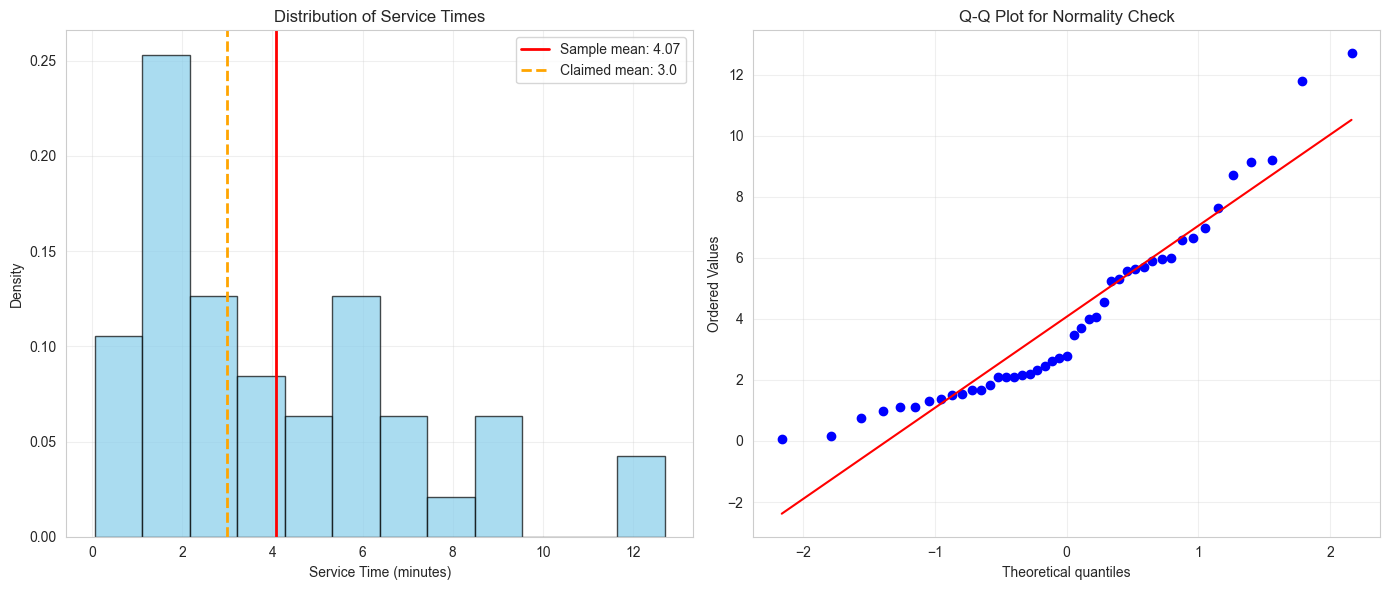


Step 2: Assumption Testing
Shapiro-Wilk test: W = 0.9064, p = 0.0015
Normality assumption: Violated (but robust with n > 30)
Potential outliers: 1 values outside (-4.64, 12.22)

Step 3: Hypothesis Test
Hypotheses:
H₀: μ = 3.0 (service time equals claimed average)
H₁: μ ≠ 3.0 (service time differs from claimed average)

Test Results:
t-statistic: 2.3593
p-value: 0.022815
Decision: Reject H₀ at α = 0.05

Step 4: Confidence Interval
95% CI for true mean: (3.156, 4.984) minutes
Interpretation: We are 95% confident the true average service time is between 3.16 and 4.98 minutes
CI excludes the claimed value of 3.0 minutes

Step 5: Effect Size and Practical Significance
Cohen's d: 0.352
Effect size interpretation: Small
Practical difference: 1.07 minutes (64 seconds) longer than claimed

Step 6: Conclusion and Recommendations
Statistical Conclusion: The evidence suggests the average service time significantly differs from the claimed 3 minutes.
Practical Implication: Customers wait an averag

In [15]:
# Exercise 1: One-Sample t-Test - Coffee Shop Service Times
print("="*60)
print("EXERCISE 1: One-Sample t-Test - Coffee Shop Service Times")
print("="*60)

# Generate realistic service time data (right-skewed)
np.random.seed(123)
# Use gamma distribution for right-skewed service times
service_times = np.random.gamma(shape=2, scale=1.8, size=45)  # Mean ≈ 3.6 minutes

claimed_mean = 3.0  # Coffee shop's claim

print("Step 1: Data Summary")
print(f"Sample size: {len(service_times)}")
print(f"Sample mean: {service_times.mean():.3f} minutes")
print(f"Sample median: {np.median(service_times):.3f} minutes")
print(f"Sample std: {service_times.std(ddof=1):.3f} minutes")
print(f"Claimed mean: {claimed_mean} minutes")

# Visualize the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
ax1.hist(service_times, bins=12, density=True, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(service_times.mean(), color='red', linewidth=2, label=f'Sample mean: {service_times.mean():.2f}')
ax1.axvline(claimed_mean, color='orange', linewidth=2, linestyle='--', label=f'Claimed mean: {claimed_mean}')
ax1.set_xlabel('Service Time (minutes)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Service Times')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Q-Q plot for normality assessment
stats.probplot(service_times, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot for Normality Check')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStep 2: Assumption Testing")
# Test for normality
shapiro_stat, shapiro_p = stats.shapiro(service_times)
print(f"Shapiro-Wilk test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
print(f"Normality assumption: {'Met' if shapiro_p > 0.05 else 'Violated (but robust with n > 30)'}")

# Check for outliers
Q1, Q3 = np.percentile(service_times, [25, 75])
IQR = Q3 - Q1
outlier_bounds = (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
outliers = service_times[(service_times < outlier_bounds[0]) | (service_times > outlier_bounds[1])]
print(f"Potential outliers: {len(outliers)} values outside ({outlier_bounds[0]:.2f}, {outlier_bounds[1]:.2f})")

print("\nStep 3: Hypothesis Test")
# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(service_times, popmean=claimed_mean)

print(f"Hypotheses:")
print(f"H₀: μ = {claimed_mean} (service time equals claimed average)")
print(f"H₁: μ ≠ {claimed_mean} (service time differs from claimed average)")

print(f"\nTest Results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Decision: {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'} at α = 0.05")

print("\nStep 4: Confidence Interval")
n = len(service_times)
mean = service_times.mean()
std = service_times.std(ddof=1)
se = std / np.sqrt(n)
t_crit = stats.t.ppf(0.975, df=n-1)
ci_lower = mean - t_crit * se
ci_upper = mean + t_crit * se

print(f"95% CI for true mean: ({ci_lower:.3f}, {ci_upper:.3f}) minutes")
print(f"Interpretation: We are 95% confident the true average service time is between {ci_lower:.2f} and {ci_upper:.2f} minutes")
print(f"CI {'excludes' if claimed_mean < ci_lower or claimed_mean > ci_upper else 'includes'} the claimed value of {claimed_mean} minutes")

print("\nStep 5: Effect Size and Practical Significance")
cohens_d = (mean - claimed_mean) / std
print(f"Cohen's d: {cohens_d:.3f}")
print(f"Effect size interpretation: {'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}")

difference_minutes = mean - claimed_mean
difference_seconds = difference_minutes * 60
print(f"Practical difference: {difference_minutes:.2f} minutes ({difference_seconds:.0f} seconds) {'longer' if difference_minutes > 0 else 'shorter'} than claimed")

print("\nStep 6: Conclusion and Recommendations")
if p_value < 0.05:
    print(f"Statistical Conclusion: The evidence suggests the average service time significantly differs from the claimed 3 minutes.")
    print(f"Practical Implication: Customers wait an average of {difference_seconds:.0f} seconds {'longer' if difference_minutes > 0 else 'shorter'} than advertised.")
    print(f"Recommendation: The coffee shop should {'revise their claim' if abs(difference_minutes) > 0.5 else 'consider if this difference affects customer satisfaction'}.")
else:
    print(f"Statistical Conclusion: No significant evidence that average service time differs from 3 minutes.")
    print(f"Practical Implication: The claim appears to be reasonable given the data.")

print("\n" + "="*60)

EXERCISE 2: Two-Proportion z-Test - Email A/B Testing
Step 1: Campaign Results
Subject A ('50% Off Everything!'):
  Sent: 2,000, Opened: 307, Rate: 0.153 (15.3%)
Subject B ('Limited Time Offer'):
  Sent: 1,800, Opened: 335, Rate: 0.186 (18.6%)
Difference (B - A): 0.033 (3.3 percentage points)

Step 2: Hypothesis Test
Hypotheses:
H₀: p_A = p_B (no difference in open rates)
H₁: p_A ≠ p_B (difference exists in open rates)

Test Results:
z-statistic: -2.6788
p-value: 0.007389
Decision: Reject H₀ at α = 0.05

Step 3: Confidence Interval for Difference
95% CI for (p_B - p_A): (0.0087, 0.0565)
In percentage points: (0.87%, 5.65%)

Step 4: Effect Size and Business Impact
Cohen's h: 0.0869
Relative improvement: 21.2%
Additional opens if using Subject B: ~59 per 1,800 emails

Business Impact Projection (50k emails/year):
  Additional opens: 1631
  Additional conversions (5% rate): 82
  Additional revenue ($50/conversion): $4,076

Step 5: Power Analysis for Future Tests
Achieved power for current

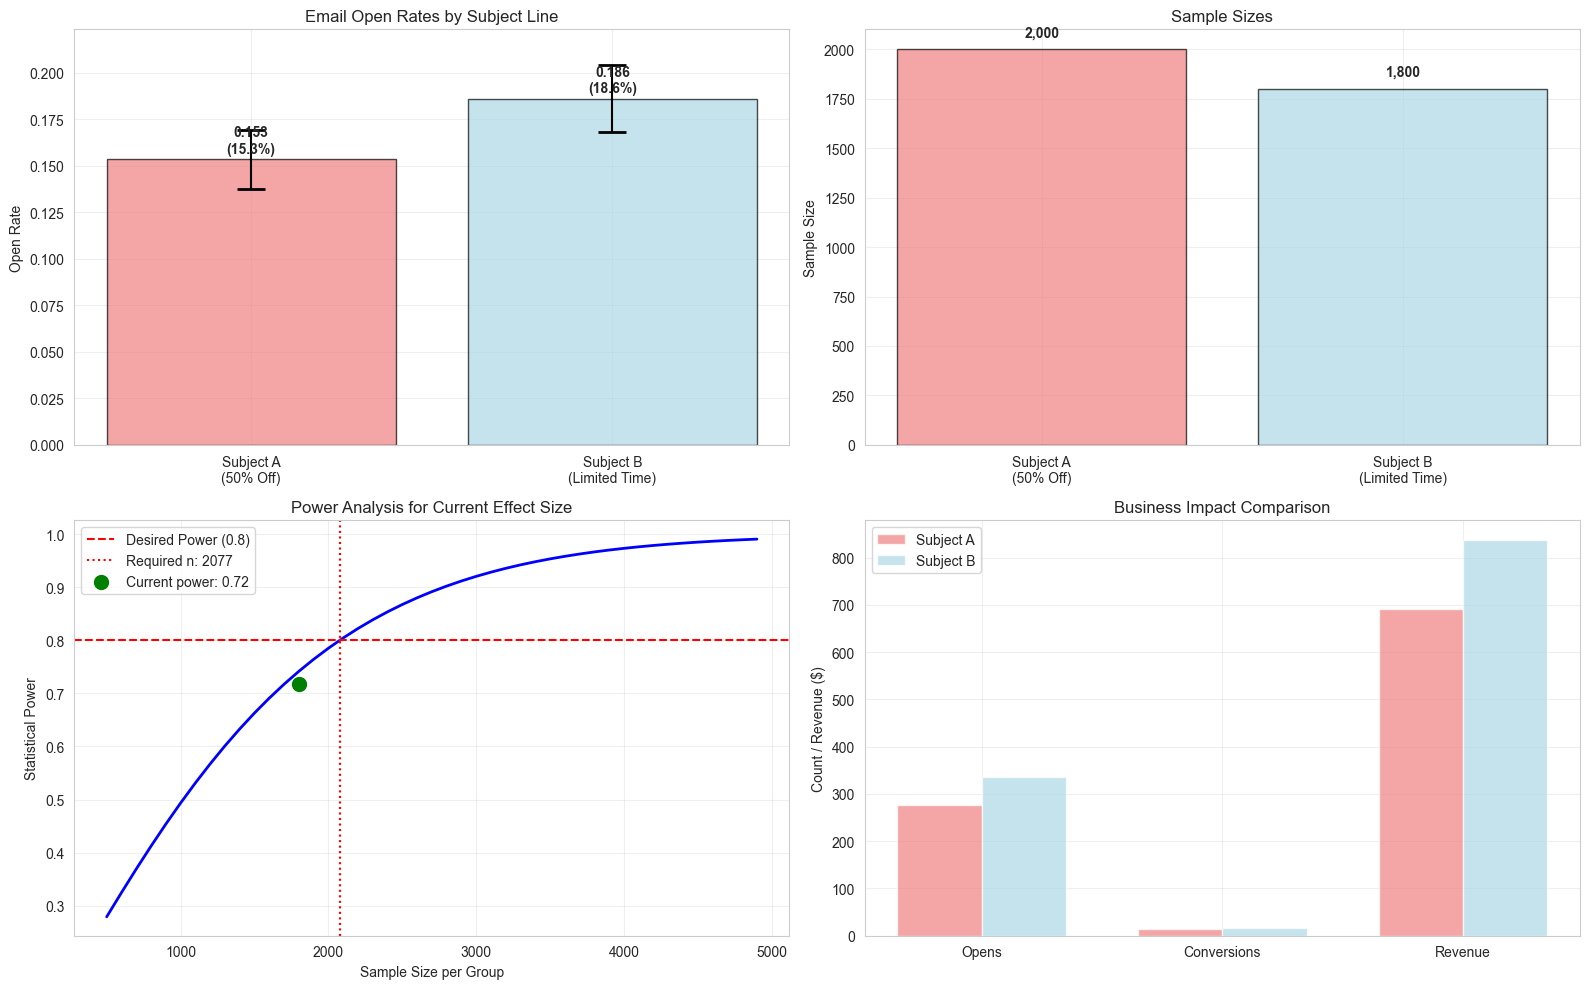


Step 6: Statistical Conclusion
There is statistically significant evidence that Subject B performs better than Subject A.
The difference is both statistically significant (p = 0.0074) and practically meaningful.

Recommendation: Use Subject B for future campaigns



In [ ]:
# Exercise 2: Two-Proportion z-Test for A/B Testing
print("EXERCISE 2: Two-Proportion z-Test - Email A/B Testing")
print("="*60)

# Simulate email campaign data
np.random.seed(456)
n_A = 2000  # Subject A sample size
n_B = 1800  # Subject B sample size
true_rate_A = 0.15  # True open rate for A
true_rate_B = 0.18  # True open rate for B

# Generate realistic data
opens_A = np.random.binomial(n_A, true_rate_A)
opens_B = np.random.binomial(n_B, true_rate_B)

rate_A = opens_A / n_A
rate_B = opens_B / n_B

print("Step 1: Campaign Results")
print(f"Subject A ('50% Off Everything!'):")
print(f"  Sent: {n_A:,}, Opened: {opens_A:,}, Rate: {rate_A:.3f} ({rate_A*100:.1f}%)")
print(f"Subject B ('Limited Time Offer'):")
print(f"  Sent: {n_B:,}, Opened: {opens_B:,}, Rate: {rate_B:.3f} ({rate_B*100:.1f}%)")

rate_diff = rate_B - rate_A
print(f"Difference (B - A): {rate_diff:.3f} ({rate_diff*100:.1f} percentage points)")

print("\nStep 2: Hypothesis Test")
# Two-proportion z-test
count = np.array([opens_A, opens_B])
nobs = np.array([n_A, n_B])

z_stat, p_value = proportions_ztest(count, nobs)

print(f"Hypotheses:")
print(f"H₀: p_A = p_B (no difference in open rates)")
print(f"H₁: p_A ≠ p_B (difference exists in open rates)")

print(f"\nTest Results:")
print(f"z-statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Decision: {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'} at α = 0.05")

print("\nStep 3: Confidence Interval for Difference")
# Calculate CI for difference in proportions
se_diff = np.sqrt(rate_A*(1-rate_A)/n_A + rate_B*(1-rate_B)/n_B)
z_crit = stats.norm.ppf(0.975)
ci_lower = rate_diff - z_crit * se_diff
ci_upper = rate_diff + z_crit * se_diff

print(f"95% CI for (p_B - p_A): ({ci_lower:.4f}, {ci_upper:.4f})")
print(f"In percentage points: ({ci_lower*100:.2f}%, {ci_upper*100:.2f}%)")

print("\nStep 4: Effect Size and Business Impact")
# Effect size (Cohen's h)
h = 2 * (np.arcsin(np.sqrt(rate_B)) - np.arcsin(np.sqrt(rate_A)))
print(f"Cohen's h: {h:.4f}")

# Business impact calculation
if rate_B > rate_A:
    improvement = (rate_B - rate_A) / rate_A * 100
    additional_opens = (rate_B - rate_A) * n_B
    print(f"Relative improvement: {improvement:.1f}%")
    print(f"Additional opens if using Subject B: ~{additional_opens:.0f} per {n_B:,} emails")

    # Annual impact estimation
    annual_emails = 50000  # Assume 50k emails per year
    annual_additional_opens = (rate_B - rate_A) * annual_emails
    conversion_rate = 0.05  # Assume 5% of opens convert
    additional_conversions = annual_additional_opens * conversion_rate
    revenue_per_conversion = 50  # Assume $50 average revenue
    annual_revenue_impact = additional_conversions * revenue_per_conversion

    print(f"\nBusiness Impact Projection (50k emails/year):")
    print(f"  Additional opens: {annual_additional_opens:.0f}")
    print(f"  Additional conversions (5% rate): {additional_conversions:.0f}")
    print(f"  Additional revenue ($50/conversion): ${annual_revenue_impact:,.0f}")

print("\nStep 5: Power Analysis for Future Tests")
# Power analysis for detecting current effect size
power_prop = power_ind.power(effect_size=h, nobs1=min(n_A, n_B), ratio=n_B/n_A, alpha=0.05)
print(f"Achieved power for current sample sizes: {power_prop:.3f}")

# Required sample size to detect this effect with 80% power
n_required = power_ind.solve_power(effect_size=h, alpha=0.05, power=0.8, ratio=1.0)
print(f"Required sample size per group for 80% power: {n_required:.0f}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Bar chart of rates
subjects = ['Subject A\n(50% Off)', 'Subject B\n(Limited Time)']
rates = [rate_A, rate_B]
colors = ['lightcoral', 'lightblue']

bars = ax1.bar(subjects, rates, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Open Rate')
ax1.set_title('Email Open Rates by Subject Line')
ax1.set_ylim(0, max(rates) * 1.2)

# Add confidence intervals
for i, (rate, n) in enumerate([(rate_A, n_A), (rate_B, n_B)]):
    se = np.sqrt(rate * (1-rate) / n)
    ci = 1.96 * se
    ax1.errorbar(i, rate, yerr=ci, fmt='none', color='black', capsize=10, capthick=2)

# Add value labels
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{rate:.3f}\n({rate*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

ax1.grid(True, alpha=0.3)

# Sample sizes
ax2.bar(subjects, [n_A, n_B], color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Sample Size')
ax2.set_title('Sample Sizes')

for i, (subj, n) in enumerate(zip(subjects, [n_A, n_B])):
    ax2.text(i, n + 50, f'{n:,}', ha='center', va='bottom', fontweight='bold')

ax2.grid(True, alpha=0.3)

# Power curve for different sample sizes
n_range = np.arange(500, 5000, 100)
powers = [power_ind.power(effect_size=h, nobs1=n, ratio=1.0, alpha=0.05) for n in n_range]

ax3.plot(n_range, powers, 'blue', linewidth=2)
ax3.axhline(y=0.8, color='red', linestyle='--', label='Desired Power (0.8)')
ax3.axvline(x=n_required, color='red', linestyle=':', label=f'Required n: {n_required:.0f}')
ax3.scatter([min(n_A, n_B)], [power_prop], color='green', s=100, zorder=10,
           label=f'Current power: {power_prop:.2f}')

ax3.set_xlabel('Sample Size per Group')
ax3.set_ylabel('Statistical Power')
ax3.set_title('Power Analysis for Current Effect Size')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Business impact visualization
if rate_B > rate_A:
    metrics = ['Opens', 'Conversions', 'Revenue']
    current = [n_B * rate_A, n_B * rate_A * 0.05, n_B * rate_A * 0.05 * 50]
    improved = [n_B * rate_B, n_B * rate_B * 0.05, n_B * rate_B * 0.05 * 50]

    x = np.arange(len(metrics))
    width = 0.35

    ax4.bar(x - width/2, current, width, label='Subject A', color='lightcoral', alpha=0.7)
    ax4.bar(x + width/2, improved, width, label='Subject B', color='lightblue', alpha=0.7)

    ax4.set_ylabel('Count / Revenue ($)')
    ax4.set_title('Business Impact Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStep 6: Statistical Conclusion")
if p_value < 0.05:
    print(f"There is statistically significant evidence that Subject B performs better than Subject A.")
    print(f"The difference is both statistically significant (p = {p_value:.4f}) and practically meaningful.")
else:
    print(f"No statistically significant difference detected between the two subject lines.")

print(f"\nRecommendation: {'Use Subject B for future campaigns' if rate_B > rate_A and p_value < 0.05 else 'Consider running a larger test or testing different subject lines'}")

print("\n" + "="*60)

EXERCISE 3: Chi-Square Independence Test
Academic Performance vs Study Location Preference
Step 1: Data Summary
Contingency Table:
Performance   Library   Dorm   Café   Total
------------------------------------------
Low             25     35     15     75
Medium          45     60     25    130
High            55     30     20    105
Total          125    125     60    310

Step 2: Expected Frequencies (if independent)
Expected frequencies:
Performance   Library   Dorm   Café
-----------------------------------
Low            30.2   30.2   14.5
Medium         52.4   52.4   25.2
High           42.3   42.3   20.3

Step 3: Assumption Check
Minimum expected frequency: 14.52
Cells with expected < 5: 0/9
Assumption: Met

Step 4: Chi-Square Test
Hypotheses:
H₀: Academic performance and study location are independent
H₁: Academic performance and study location are associated

Test Results:
Chi-square statistic: 11.2081
Degrees of freedom: 4
p-value: 0.024322
Decision: Reject H₀ at α = 0.05



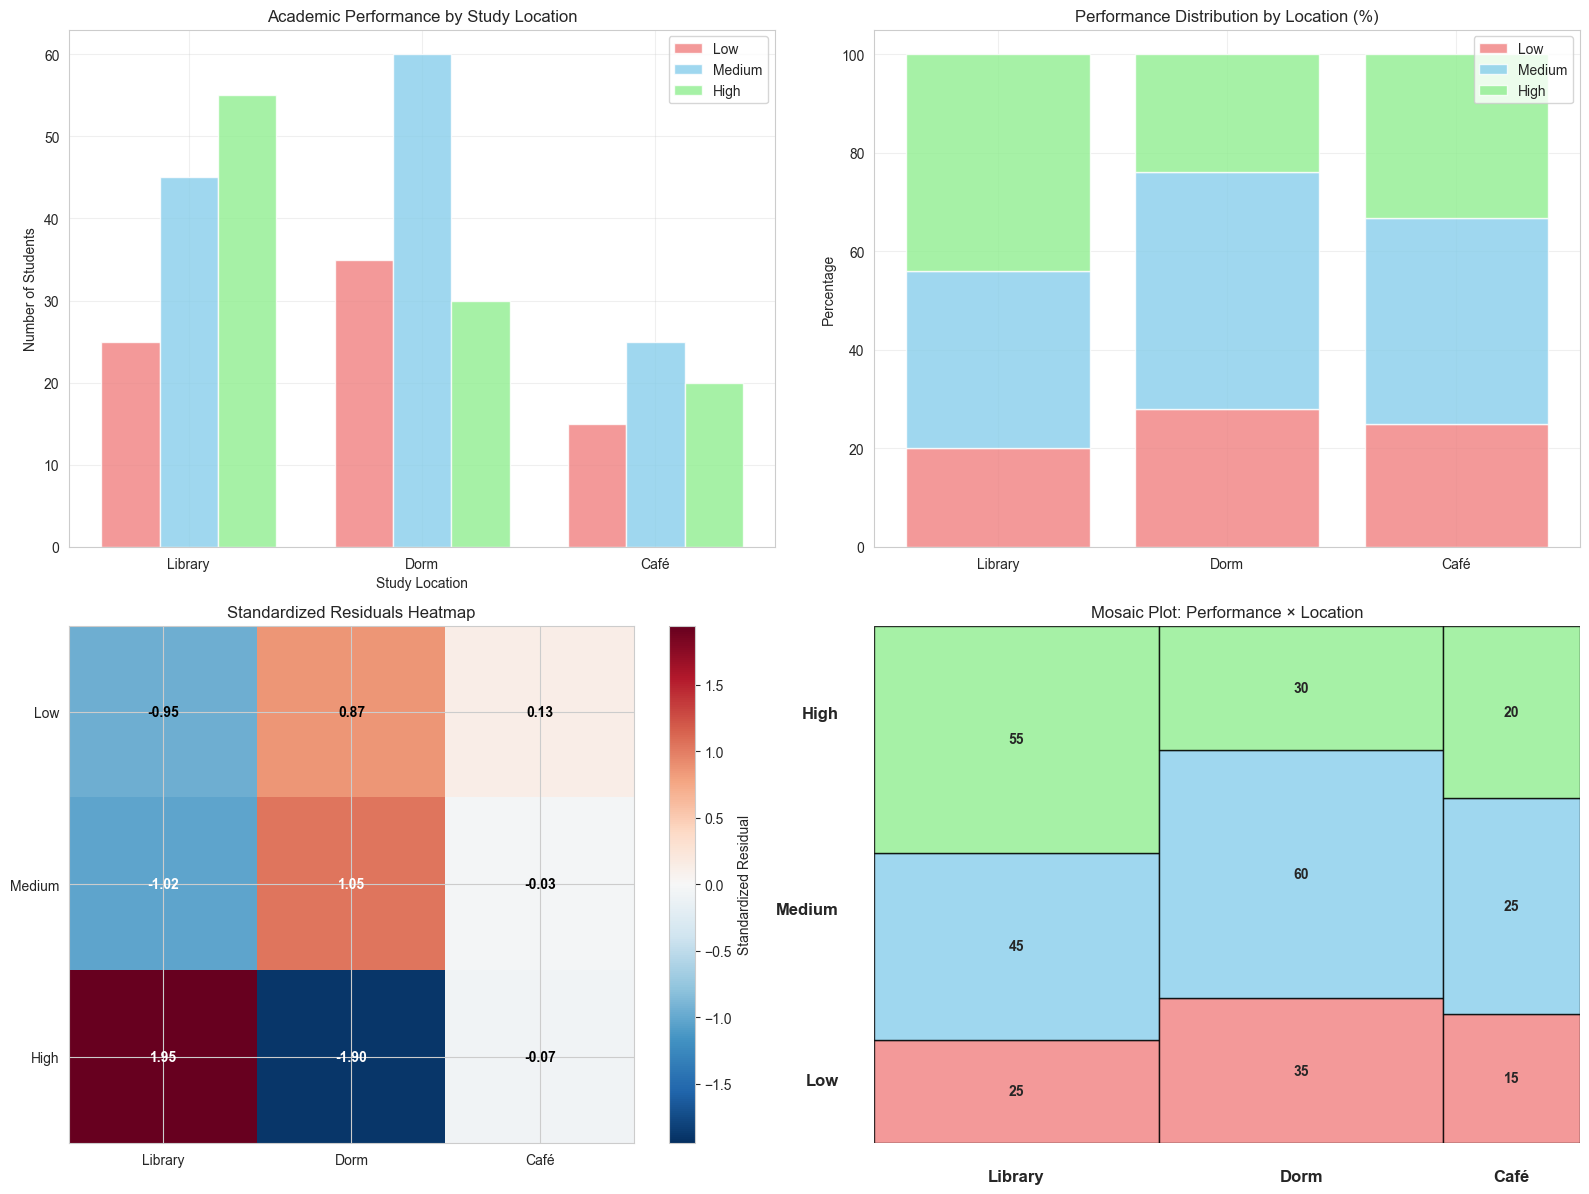


Step 8: Statistical Interpretation
There is statistically significant evidence of an association between academic performance and study location preference.
The association strength is small (Cramér's V = 0.134).

Key patterns observed:
- Library users show higher rates of high performance (44.0% vs 33.9% overall)

Practical Implications:
- Study location choice may be related to academic success
- Consider promoting library usage or improving other study environments
- Investigate what makes certain locations more conducive to academic success

Limitations:
- Correlation does not imply causation
- Other confounding variables may influence both location choice and performance
- Consider conducting longitudinal studies or randomized interventions



In [19]:
# Exercise 3: Chi-Square Independence Test - Academic Performance vs Study Location
print("EXERCISE 3: Chi-Square Independence Test")
print("Academic Performance vs Study Location Preference")
print("="*60)

# Create realistic contingency table
np.random.seed(789)

# Define categories
performance_levels = ['Low', 'Medium', 'High']
study_locations = ['Library', 'Dorm', 'Café']

# Create a contingency table with some association
# Library users tend to perform better, café users more variable
contingency_table = np.array([
    [25, 35, 15],  # Low performance: Library, Dorm, Café
    [45, 60, 25],  # Medium performance
    [55, 30, 20]   # High performance
])

# Calculate totals
row_totals = contingency_table.sum(axis=1)
col_totals = contingency_table.sum(axis=0)
grand_total = contingency_table.sum()

print("Step 1: Data Summary")
print("Contingency Table:")
print("Performance   Library   Dorm   Café   Total")
print("-" * 42)
for i, perf in enumerate(performance_levels):
    print(f"{perf:10s}    {contingency_table[i,0]:4d}   {contingency_table[i,1]:4d}   {contingency_table[i,2]:4d}   {row_totals[i]:4d}")
print(f"Total         {col_totals[0]:4d}   {col_totals[1]:4d}   {col_totals[2]:4d}   {grand_total:4d}")

print("\nStep 2: Expected Frequencies (if independent)")
expected = np.zeros_like(contingency_table, dtype=float)
for i in range(len(performance_levels)):
    for j in range(len(study_locations)):
        expected[i,j] = (row_totals[i] * col_totals[j]) / grand_total

print("Expected frequencies:")
print("Performance   Library   Dorm   Café")
print("-" * 35)
for i, perf in enumerate(performance_levels):
    print(f"{perf:10s}    {expected[i,0]:5.1f}  {expected[i,1]:5.1f}  {expected[i,2]:5.1f}")

print("\nStep 3: Assumption Check")
min_expected = expected.min()
cells_below_5 = (expected < 5).sum()
print(f"Minimum expected frequency: {min_expected:.2f}")
print(f"Cells with expected < 5: {cells_below_5}/{expected.size}")
print(f"Assumption: {'Met' if min_expected >= 5 else 'Questionable - consider combining categories'}")

print("\nStep 4: Chi-Square Test")
chi2_stat, p_value, dof, expected_scipy = stats.chi2_contingency(contingency_table)

print(f"Hypotheses:")
print(f"H₀: Academic performance and study location are independent")
print(f"H₁: Academic performance and study location are associated")

print(f"\nTest Results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value:.6f}")
print(f"Decision: {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'} at α = 0.05")

print("\nStep 5: Effect Size Measures")
# Cramér's V
cramers_v = np.sqrt(chi2_stat / (grand_total * min(len(performance_levels)-1, len(study_locations)-1)))
print(f"Cramér's V: {cramers_v:.4f}")

# Interpret effect size
if cramers_v < 0.1:
    effect_interpretation = "negligible"
elif cramers_v < 0.3:
    effect_interpretation = "small"
elif cramers_v < 0.5:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"Effect size interpretation: {effect_interpretation}")

print("\nStep 6: Standardized Residuals Analysis")
standardized_residuals = (contingency_table - expected) / np.sqrt(expected)
print("Standardized residuals (|value| > 2 indicates significant contribution):")
print("Performance   Library   Dorm   Café")
print("-" * 35)
for i, perf in enumerate(performance_levels):
    print(f"{perf:10s}    {standardized_residuals[i,0]:5.2f}  {standardized_residuals[i,1]:5.2f}  {standardized_residuals[i,2]:5.2f}")

# Identify significant cells
significant_cells = []
for i in range(len(performance_levels)):
    for j in range(len(study_locations)):
        if abs(standardized_residuals[i,j]) > 2:
            significant_cells.append((performance_levels[i], study_locations[j], standardized_residuals[i,j]))

if significant_cells:
    print(f"\nCells contributing significantly to association:")
    for perf, loc, residual in significant_cells:
        direction = "more" if residual > 0 else "fewer"
        print(f"  {perf} performance in {loc}: {direction} students than expected ({residual:.2f})")

print("\nStep 7: Proportional Analysis")
# Calculate proportions within each location
print("Performance distribution by study location:")
print("Location     Low%    Med%    High%   Total")
print("-" * 42)
for j, location in enumerate(study_locations):
    props = contingency_table[:, j] / col_totals[j] * 100
    print(f"{location:8s}   {props[0]:5.1f}   {props[1]:5.1f}   {props[2]:5.1f}   {col_totals[j]:4d}")

# Overall distribution
overall_props = row_totals / grand_total * 100
print(f"Overall      {overall_props[0]:5.1f}   {overall_props[1]:5.1f}   {overall_props[2]:5.1f}   {grand_total:4d}")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Grouped bar chart
x = np.arange(len(study_locations))
width = 0.25
colors = ['lightcoral', 'skyblue', 'lightgreen']

for i, (perf, color) in enumerate(zip(performance_levels, colors)):
    values = contingency_table[i, :]
    ax1.bar(x + i*width, values, width, label=perf, color=color, alpha=0.8)

ax1.set_xlabel('Study Location')
ax1.set_ylabel('Number of Students')
ax1.set_title('Academic Performance by Study Location')
ax1.set_xticks(x + width)
ax1.set_xticklabels(study_locations)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Stacked percentage bar chart
props_by_location = contingency_table / col_totals * 100
bottom = np.zeros(len(study_locations))

for i, (perf, color) in enumerate(zip(performance_levels, colors)):
    ax2.bar(study_locations, props_by_location[i], bottom=bottom,
           label=perf, color=color, alpha=0.8)
    bottom += props_by_location[i]

ax2.set_ylabel('Percentage')
ax2.set_title('Performance Distribution by Location (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Heatmap of standardized residuals
# Create centered colormap for residuals
vmax = np.abs(standardized_residuals).max()
im = ax3.imshow(standardized_residuals, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='auto')
ax3.set_xticks(range(len(study_locations)))
ax3.set_yticks(range(len(performance_levels)))
ax3.set_xticklabels(study_locations)
ax3.set_yticklabels(performance_levels)
ax3.set_title('Standardized Residuals Heatmap')

# Add text annotations
for i in range(len(performance_levels)):
    for j in range(len(study_locations)):
        text = ax3.text(j, i, f'{standardized_residuals[i, j]:.2f}',
                       ha="center", va="center",
                       color="white" if abs(standardized_residuals[i, j]) > 1 else "black",
                       fontweight='bold')

plt.colorbar(im, ax=ax3, label='Standardized Residual')

# 4. Mosaic plot approximation
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# Calculate widths and heights for mosaic
col_widths = col_totals / grand_total
row_heights = row_totals / grand_total

x_offset = 0
colors_flat = ['lightcoral', 'skyblue', 'lightgreen']

for j, location in enumerate(study_locations):
    y_offset = 0
    col_width = col_widths[j]

    for i, (perf, color) in enumerate(zip(performance_levels, colors_flat)):
        cell_prop = contingency_table[i, j] / grand_total
        cell_height = cell_prop / col_width

        rect = plt.Rectangle((x_offset, y_offset), col_width, cell_height,
                           facecolor=color, alpha=0.8, edgecolor='black', linewidth=1)
        ax4.add_patch(rect)

        # Add text if cell is large enough
        if cell_height > 0.05:
            ax4.text(x_offset + col_width/2, y_offset + cell_height/2,
                    f'{contingency_table[i,j]}', ha='center', va='center',
                    fontweight='bold', fontsize=10)

        y_offset += cell_height

    # Add location label
    ax4.text(x_offset + col_width/2, -0.05, location, ha='center', va='top',
            fontweight='bold', fontsize=12)

    x_offset += col_width

# Add performance labels on the left
cumsum_height = 0
for i, (perf, color) in enumerate(zip(performance_levels, colors_flat)):
    height = row_heights[i]
    ax4.text(-0.05, cumsum_height + height/2, perf, ha='right', va='center',
            fontweight='bold', fontsize=12)
    cumsum_height += height

ax4.set_title('Mosaic Plot: Performance × Location')
ax4.set_xticks([])
ax4.set_yticks([])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nStep 8: Statistical Interpretation")
if p_value < 0.05:
    print(f"There is statistically significant evidence of an association between academic performance and study location preference.")
    print(f"The association strength is {effect_interpretation} (Cramér's V = {cramers_v:.3f}).")

    # Identify patterns
    print(f"\nKey patterns observed:")
    high_perf_library = contingency_table[2,0] / col_totals[0] * 100
    high_perf_overall = row_totals[2] / grand_total * 100

    if high_perf_library > high_perf_overall + 5:
        print(f"- Library users show higher rates of high performance ({high_perf_library:.1f}% vs {high_perf_overall:.1f}% overall)")

    low_perf_cafe = contingency_table[0,2] / col_totals[2] * 100
    low_perf_overall = row_totals[0] / grand_total * 100

    if low_perf_cafe > low_perf_overall + 5:
        print(f"- Café users show higher rates of low performance ({low_perf_cafe:.1f}% vs {low_perf_overall:.1f}% overall)")

else:
    print(f"No statistically significant association detected between academic performance and study location.")

print(f"\nPractical Implications:")
if p_value < 0.05:
    print(f"- Study location choice may be related to academic success")
    print(f"- Consider promoting library usage or improving other study environments")
    print(f"- Investigate what makes certain locations more conducive to academic success")
else:
    print(f"- Student performance appears independent of study location preference")
    print(f"- Focus on other factors that might influence academic performance")

print(f"\nLimitations:")
print(f"- Correlation does not imply causation")
print(f"- Other confounding variables may influence both location choice and performance")
print(f"- Consider conducting longitudinal studies or randomized interventions")

print("\n" + "="*60)

EXERCISE 4: One-Way ANOVA Analysis
Weight Loss Effectiveness Across Different Workout Programs
Step 1: Data Summary
Sample sizes and descriptive statistics:
Program             n    Mean    SD     Min    Max
----------------------------------------------------
HIIT           25    12.7   3.6     4.9   18.8
Strength       25     9.6   2.5     4.9   13.7
Cardio         25     7.8   2.7     3.6   13.2
Yoga           25     6.1   2.8    -0.2   11.7
Overall        100     9.1

Step 2: Assumption Testing
Normality test (Shapiro-Wilk) for each group:
Program         W-statistic  p-value   Normal?
---------------------------------------------
HIIT             0.9789    0.8616    Yes
Strength         0.9618    0.4508    Yes
Cardio           0.9533    0.2975    Yes
Yoga             0.9791    0.8665    Yes
Overall normality assumption: Met

Homogeneity of variances (Levene's test):
Levene statistic: 1.6827
p-value: 0.1758
Equal variances assumption: Met

Outlier Analysis:
HIIT: 0 outliers
Strengt

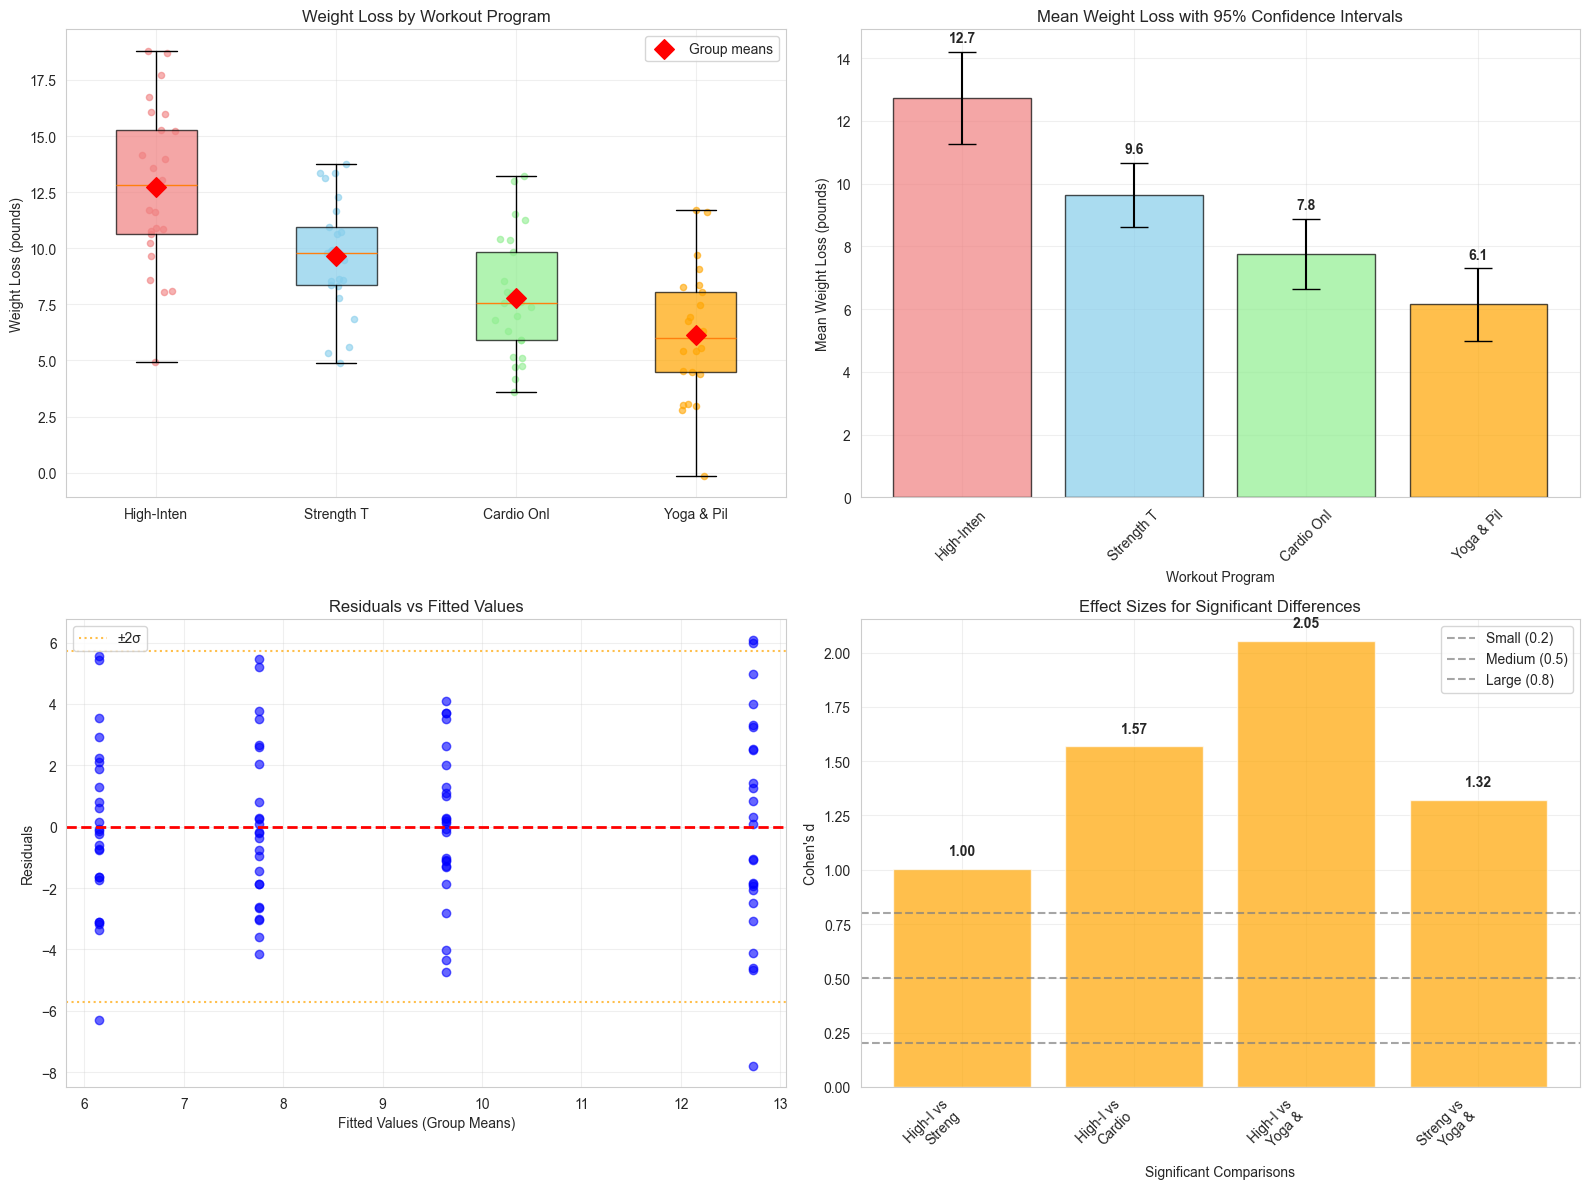


Step 6: Statistical Interpretation
There is statistically significant evidence that at least one workout program
produces different mean weight loss compared to others (F = 23.485, p = 0.000000).
The effect size is large (η² = 0.423).

Specific significant differences:
  High-Intensity Interval Training (HIIT) vs Strength Training: difference = 3.1 lbs (p = 0.0052)
  High-Intensity Interval Training (HIIT) vs Cardio Only: difference = 5.0 lbs (p = 0.0000)
  High-Intensity Interval Training (HIIT) vs Yoga & Pilates: difference = 6.6 lbs (p = 0.0000)
  Strength Training vs Yoga & Pilates: difference = 3.5 lbs (p = 0.0001)

Program effectiveness ranking (by mean weight loss):
  1. HIIT: 12.7 lbs
  2. Strength: 9.6 lbs
  3. Cardio: 7.8 lbs
  4. Yoga: 6.1 lbs

Step 7: Practical Implications
• HIIT appears most effective (12.7 lbs average loss)
• Yoga appears least effective (6.1 lbs average loss)
• Maximum difference between programs: 6.6 lbs
• The 6.6 lb difference is likely practically s

In [ ]:
# Exercise 4: One-Way ANOVA - Weight Loss Program Comparison
print("EXERCISE 4: One-Way ANOVA Analysis")
print("Weight Loss Effectiveness Across Different Workout Programs")
print("="*70)

# Create realistic dataset with moderate effect
np.random.seed(456)

# Define workout programs
programs = ['High-Intensity Interval Training (HIIT)', 'Strength Training', 'Cardio Only', 'Yoga & Pilates']
group_names = ['HIIT', 'Strength', 'Cardio', 'Yoga']

# Create weight loss data with different means (moderate effect)
# HIIT: highest weight loss
# Strength: second highest
# Cardio: moderate
# Yoga: lowest weight loss

groups = [
    np.random.normal(12.0, 3.5, 25),  # HIIT: mean=12, sd=3.5
    np.random.normal(9.5, 3.2, 25),   # Strength: mean=9.5, sd=3.2
    np.random.normal(7.8, 3.0, 25),   # Cardio: mean=7.8, sd=3.0
    np.random.normal(5.2, 2.8, 25)    # Yoga: mean=5.2, sd=2.8
]

# Combine data for overall analysis
all_data = np.concatenate(groups)
group_labels = np.repeat(range(len(programs)), [len(g) for g in groups])

print("Step 1: Data Summary")
print("Sample sizes and descriptive statistics:")
print("Program             n    Mean    SD     Min    Max")
print("-" * 52)
for i, (program, group) in enumerate(zip(programs, groups)):
    print(f"{group_names[i]:12s}   {len(group):2d}   {group.mean():5.1f}  {group.std(ddof=1):4.1f}   {group.min():5.1f}  {group.max():5.1f}")

grand_mean = all_data.mean()
total_n = len(all_data)
print(f"Overall        {total_n:3d}   {grand_mean:5.1f}")

print("\nStep 2: Assumption Testing")

# 1. Normality assumption (Shapiro-Wilk for each group)
print("Normality test (Shapiro-Wilk) for each group:")
print("Program         W-statistic  p-value   Normal?")
print("-" * 45)
normal_assumptions_met = True
for i, (name, group) in enumerate(zip(group_names, groups)):
    sw_stat, sw_p = stats.shapiro(group)
    is_normal = sw_p > 0.05
    if not is_normal:
        normal_assumptions_met = False
    print(f"{name:12s}   {sw_stat:8.4f}    {sw_p:6.4f}    {'Yes' if is_normal else 'No'}")

print(f"Overall normality assumption: {'Met' if normal_assumptions_met else 'Questionable'}")

# 2. Homogeneity of variances (Levene's test)
levene_stat, levene_p = stats.levene(*groups)
equal_variances = levene_p > 0.05
print(f"\nHomogeneity of variances (Levene's test):")
print(f"Levene statistic: {levene_stat:.4f}")
print(f"p-value: {levene_p:.4f}")
print(f"Equal variances assumption: {'Met' if equal_variances else 'Violated'}")

# 3. Outlier detection
print(f"\nOutlier Analysis:")
outliers = []
for i, (name, group) in enumerate(zip(group_names, groups)):
    Q1 = np.percentile(group, 25)
    Q3 = np.percentile(group, 75)
    IQR = Q3 - Q1
    outlier_bounds = (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
    group_outliers = group[(group < outlier_bounds[0]) | (group > outlier_bounds[1])]
    print(f"{name}: {len(group_outliers)} outliers")
    outliers.extend(group_outliers)

print(f"Total outliers: {len(outliers)} ({len(outliers)/total_n*100:.1f}%)")

print("\nStep 3: One-Way ANOVA")
print("Hypotheses:")
print("H₀: μ₁ = μ₂ = μ₃ = μ₄ (all group means are equal)")
print("H₁: At least one group mean differs from the others")

# Manual ANOVA calculation
print(f"\nManual ANOVA Calculation:")

# Calculate group means and overall mean
group_means = [group.mean() for group in groups]
group_sizes = [len(group) for group in groups]
n_groups = len(groups)

print(f"Group means: {[f'{mean:.2f}' for mean in group_means]}")
print(f"Grand mean: {grand_mean:.2f}")

# Sum of Squares Between Groups (SSB)
ss_between = sum(n * (mean - grand_mean)**2 for n, mean in zip(group_sizes, group_means))

# Sum of Squares Within Groups (SSW)
ss_within = sum(sum((x - group_mean)**2 for x in group)
                for group, group_mean in zip(groups, group_means))

# Total Sum of Squares (SST)
ss_total = sum((x - grand_mean)**2 for x in all_data)

# Degrees of freedom
df_between = n_groups - 1
df_within = total_n - n_groups
df_total = total_n - 1

# Mean Squares
ms_between = ss_between / df_between
ms_within = ss_within / df_within

# F-statistic
f_manual = ms_between / ms_within

# P-value
p_value = 1 - stats.f.cdf(f_manual, df_between, df_within)

print(f"\nANOVA Table (Manual Calculation):")
print(f"Source       SS        df    MS        F       p-value")
print(f"-" * 55)
print(f"Between   {ss_between:8.2f}    {df_between:2d}  {ms_between:8.2f}  {f_manual:6.3f}  {p_value:.6f}")
print(f"Within    {ss_within:8.2f}   {df_within:2d}  {ms_within:8.2f}")
print(f"Total     {ss_total:8.2f}   {df_total:2d}")

# Using scipy.stats
f_stat, p_val = stats.f_oneway(*groups)
print(f"\nSciPy validation:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Decision
alpha = 0.05
f_critical = stats.f.ppf(1 - alpha, df_between, df_within)
print(f"\nDecision (α = {alpha}):")
print(f"Critical F-value: {f_critical:.4f}")
print(f"Observed F-value: {f_manual:.4f}")
print(f"Result: {'Reject H₀' if p_value < alpha else 'Fail to reject H₀'}")

print(f"\nStep 4: Effect Size Measures")

# Eta-squared (η²)
eta_squared = ss_between / ss_total
print(f"Eta-squared (η²): {eta_squared:.4f}")

# Omega-squared (ω²) - less biased estimate
omega_squared = (ss_between - df_between * ms_within) / (ss_total + ms_within)
print(f"Omega-squared (ω²): {omega_squared:.4f}")

# Interpret effect size
if eta_squared < 0.01:
    effect_interpretation = "negligible"
elif eta_squared < 0.06:
    effect_interpretation = "small"
elif eta_squared < 0.14:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"

print(f"Effect size interpretation: {effect_interpretation}")

# Create ANOVA summary table
anova_table = pd.DataFrame({
    'Source': ['Between Groups', 'Within Groups', 'Total'],
    'SS': [ss_between, ss_within, ss_total],
    'df': [df_between, df_within, df_total],
    'MS': [ms_between, ms_within, np.nan],
    'F': [f_manual, np.nan, np.nan],
    'p-value': [p_value, np.nan, np.nan]
})

print(f"\nStep 5: Post-Hoc Analysis")
if p_value < 0.05:
    print("Significant overall difference found. Conducting pairwise comparisons...")
    print("Using Bonferroni correction for multiple comparisons.")

    # Pairwise comparisons with Bonferroni correction
    n_comparisons = (n_groups * (n_groups - 1)) // 2
    bonferroni_alpha = alpha / n_comparisons
    print(f"Adjusted α for each comparison: {bonferroni_alpha:.4f}")

    comparisons = []
    for i in range(len(programs)):
        for j in range(i+1, len(programs)):
            # Independent t-test
            t_stat, p_raw = stats.ttest_ind(groups[i], groups[j], equal_var=equal_variances)
            p_adj = min(p_raw * n_comparisons, 1.0)  # Bonferroni correction

            # Cohen's d
            pooled_std = np.sqrt(((len(groups[i])-1)*groups[i].var(ddof=1) +
                                 (len(groups[j])-1)*groups[j].var(ddof=1)) /
                                (len(groups[i]) + len(groups[j]) - 2))
            cohens_d = abs(groups[i].mean() - groups[j].mean()) / pooled_std

            # Practical difference
            mean_diff = groups[i].mean() - groups[j].mean()

            comparisons.append({
                'Group 1': programs[i],
                'Group 2': programs[j],
                'Mean Diff': mean_diff,
                'p-value': p_raw,
                'p-adj': p_adj,
                'Significant': 'Yes' if p_adj < 0.05 else 'No',
                'Cohens_d': cohens_d,
                'Effect Size': 'Small' if cohens_d < 0.5 else 'Medium' if cohens_d < 0.8 else 'Large'
            })

    # Display results
    print(f"\nPairwise Comparison Results:")
    print(f"Comparison                    Mean Diff  p-value  p-adj    Sig  Cohen's d  Effect")
    print(f"-" * 85)

    significant_pairs = []
    for comp in comparisons:
        print(f"{comp['Group 1'][:8]} vs {comp['Group 2'][:8]:8s} {comp['Mean Diff']:8.2f}  {comp['p-value']:.4f}  {comp['p-adj']:.4f}   {comp['Significant']:3s}  {comp['Cohens_d']:8.3f}  {comp['Effect Size']}")
        if comp['Significant'] == 'Yes':
            significant_pairs.append(comp)

    if significant_pairs:
        print(f"\nSignificant differences found:")
        for comp in significant_pairs:
            direction = "lost more weight" if comp['Mean Diff'] > 0 else "lost less weight"
            print(f"  {comp['Group 1']} vs {comp['Group 2']}: {comp['Group 1']} {direction} by {abs(comp['Mean Diff']):.1f} pounds on average")
else:
    print("No significant overall difference found - skipping post-hoc tests")

# Comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plots with individual points
colors = ['lightcoral', 'skyblue', 'lightgreen', 'orange']
bp = ax1.boxplot(groups, labels=[p[:10] for p in programs], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual points with jitter
for i, (group, color) in enumerate(zip(groups, colors)):
    x = np.random.normal(i+1, 0.04, size=len(group))
    ax1.scatter(x, group, alpha=0.6, color=color, s=20)

# Add means
means = [group.mean() for group in groups]
ax1.scatter(range(1, len(programs)+1), means, color='red', s=100, marker='D',
           label='Group means', zorder=10)

ax1.set_ylabel('Weight Loss (pounds)')
ax1.set_title('Weight Loss by Workout Program')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Bar chart with error bars (95% CI)
means = [group.mean() for group in groups]
cis = []
for group in groups:
    n = len(group)
    se = group.std(ddof=1) / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, n-1)
    ci = t_crit * se
    cis.append(ci)

bars = ax2.bar(range(len(programs)), means, yerr=cis, capsize=10,
               color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Workout Program')
ax2.set_ylabel('Mean Weight Loss (pounds)')
ax2.set_title('Mean Weight Loss with 95% Confidence Intervals')
ax2.set_xticks(range(len(programs)))
ax2.set_xticklabels([p[:10] for p in programs], rotation=45)

# Add value labels
for bar, mean, ci in zip(bars, means, cis):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + ci + 0.2,
            f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

ax2.grid(True, alpha=0.3)

# 3. Residuals analysis
residuals = []
fitted_values = []
for group, mean in zip(groups, means):
    residuals.extend(group - mean)
    fitted_values.extend([mean] * len(group))

ax3.scatter(fitted_values, residuals, alpha=0.6, color='blue')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Fitted Values (Group Means)')
ax3.set_ylabel('Residuals')
ax3.set_title('Residuals vs Fitted Values')
ax3.grid(True, alpha=0.3)

# Add reference lines for ±2 standard deviations
residual_std = np.std(residuals)
ax3.axhline(y=2*residual_std, color='orange', linestyle=':', alpha=0.7, label='±2σ')
ax3.axhline(y=-2*residual_std, color='orange', linestyle=':', alpha=0.7)
ax3.legend()

# 4. Effect size visualization and summary
if p_value < 0.05 and significant_pairs:
    # Show effect sizes for significant comparisons
    sig_effects = [comp['Cohens_d'] for comp in significant_pairs]
    sig_labels = [f"{comp['Group 1'][:6]} vs\n{comp['Group 2'][:6]}" for comp in significant_pairs]

    effect_colors = ['lightgreen' if d < 0.5 else 'yellow' if d < 0.8 else 'orange' for d in sig_effects]

    bars = ax4.bar(range(len(sig_effects)), sig_effects, color=effect_colors, alpha=0.7)
    ax4.set_xlabel('Significant Comparisons')
    ax4.set_ylabel("Cohen's d")
    ax4.set_title('Effect Sizes for Significant Differences')
    ax4.set_xticks(range(len(sig_effects)))
    ax4.set_xticklabels(sig_labels, rotation=45, ha='right')

    # Add effect size reference lines
    ax4.axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='Small (0.2)')
    ax4.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Medium (0.5)')
    ax4.axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='Large (0.8)')

    # Add value labels
    for bar, effect in zip(bars, sig_effects):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{effect:.2f}', ha='center', va='bottom', fontweight='bold')

    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    # Show overall means if no significant differences
    ax4.bar(range(len(programs)), means, color=colors, alpha=0.7)
    ax4.set_xlabel('Workout Programs')
    ax4.set_ylabel('Mean Weight Loss (pounds)')
    ax4.set_title('Program Means (No Significant Differences)')
    ax4.set_xticks(range(len(programs)))
    ax4.set_xticklabels([p[:8] for p in programs], rotation=45)

    for i, mean in enumerate(means):
        ax4.text(i, mean + 0.3, f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStep 6: Statistical Interpretation")
if p_value < 0.05:
    print(f"There is statistically significant evidence that at least one workout program")
    print(f"produces different mean weight loss compared to others (F = {f_manual:.3f}, p = {p_value:.6f}).")
    print(f"The effect size is {effect_interpretation} (η² = {eta_squared:.3f}).")

    if significant_pairs:
        print(f"\nSpecific significant differences:")
        for comp in significant_pairs:
            print(f"  {comp['Group 1']} vs {comp['Group 2']}: difference = {abs(comp['Mean Diff']):.1f} lbs (p = {comp['p-adj']:.4f})")

    # Ranking
    ranked_programs = sorted(zip(group_names, group_means), key=lambda x: x[1], reverse=True)
    print(f"\nProgram effectiveness ranking (by mean weight loss):")
    for rank, (name, mean) in enumerate(ranked_programs, 1):
        print(f"  {rank}. {name}: {mean:.1f} lbs")
else:
    print(f"No statistically significant difference found between workout programs")
    print(f"(F = {f_manual:.3f}, p = {p_value:.3f}).")
    print(f"All programs appear equally effective for weight loss.")

print(f"\nStep 7: Practical Implications")
if p_value < 0.05:
    best_program = max(zip(group_names, group_means), key=lambda x: x[1])
    worst_program = min(zip(group_names, group_means), key=lambda x: x[1])
    difference = best_program[1] - worst_program[1]

    print(f"• {best_program[0]} appears most effective ({best_program[1]:.1f} lbs average loss)")
    print(f"• {worst_program[0]} appears least effective ({worst_program[1]:.1f} lbs average loss)")
    print(f"• Maximum difference between programs: {difference:.1f} lbs")

    if difference > 3:  # Practically significant threshold
        print(f"• The {difference:.1f} lb difference is likely practically significant")
        print(f"• Consider recommending {best_program[0]} over {worst_program[0]}")
    else:
        print(f"• The {difference:.1f} lb difference may not be practically significant")
        print(f"• Individual preferences and adherence may be more important")
else:
    print(f"• All programs show similar effectiveness")
    print(f"• Choose based on individual preferences, accessibility, and adherence")
    print(f"• Consider combining elements from different programs")

print(f"\nStep 8: Study Limitations and Next Steps")
print(f"Limitations:")
print(f"• Sample size: {total_n} participants total ({total_n//n_groups} per group)")
print(f"• Study duration and follow-up not specified")
print(f"• Individual factors (diet, genetics, adherence) not controlled")
print(f"• Potential selection bias in program assignment")

print(f"\nRecommended next steps:")
print(f"• Conduct larger randomized controlled trial")
print(f"• Include longer follow-up periods")
print(f"• Control for diet and other lifestyle factors")
print(f"• Measure adherence and dropout rates")
print(f"• Consider individual characteristics as moderators")

print("\n" + "="*70)

---

## Summary and Key Takeaways

### 🎯 **Core Concepts Mastered**

1. **Hypothesis Testing Framework**
   - Formulating null and alternative hypotheses
   - Understanding p-values and significance levels
   - Making statistical decisions and interpreting results

2. **Test Selection Criteria**
   - One-sample vs. two-sample tests
   - Parametric vs. non-parametric approaches
   - Independent vs. dependent samples

3. **Effect Sizes and Practical Significance**
   - Cohen's d for t-tests
   - Cramér's V for chi-square tests
   - Eta-squared for ANOVA
   - Distinguishing statistical from practical significance

4. **Power Analysis Applications**
   - Sample size determination
   - Effect size detection
   - Study planning and interpretation

### 📊 **Statistical Tests Summary**

| Test Type | Use Case | Key Assumptions | Effect Size |
|-----------|----------|-----------------|-------------|
| One-sample t-test | Mean vs. hypothesized value | Normality, independence | Cohen's d |
| Two-sample t-test | Compare two group means | Normality, independence, equal variances* | Cohen's d |
| Paired t-test | Before/after comparisons | Normality of differences | Cohen's d |
| Proportion z-test | Compare proportions | Large samples, independence | Cohen's h |
| Chi-square goodness-of-fit | Test distribution fit | Expected freq ≥ 5 | Cramér's V |
| Chi-square independence | Test association | Expected freq ≥ 5 | Cramér's V |
| One-way ANOVA | Compare 3+ group means | Normality, independence, equal variances | Eta-squared |

*Use Welch t-test when equal variances assumption is violated

### 🔧 **Best Practices for Applied Statistics**

1. **Always check assumptions** - Tests are robust but not bulletproof
2. **Report effect sizes** - Statistical significance ≠ practical importance
3. **Use confidence intervals** - Provide range of plausible values
4. **Consider power analysis** - Plan studies appropriately
5. **Interpret results in context** - Statistics serve the research question
6. **Address limitations** - Be transparent about study constraints

### 🚀 **Next Steps in Your Statistical Journey**

- **Advanced ANOVA**: Two-way ANOVA, repeated measures, mixed effects
- **Non-parametric tests**: Mann-Whitney U, Kruskal-Wallis, Wilcoxon
- **Regression analysis**: Linear, logistic, and multiple regression
- **Bayesian statistics**: Alternative approach to hypothesis testing
- **Machine learning**: Classification, prediction, and model validation

**Remember**: Statistics is a tool for understanding data and making informed decisions. The key is choosing the right tool for your research question and interpreting results thoughtfully!

---

*This interactive notebook provides a comprehensive foundation for hypothesis testing in data science applications. Practice with real datasets and continue exploring advanced statistical methods to deepen your analytical skills.*